In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'

config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])

dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

dataset = get_dataset(dataset_dir,
                                     'validation',
                                     config.batch_size,
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

env = RetinaEnv(config, image_generator=dataset)

if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound

# You might want to adjust the hyperparameters
actor_lr = 0.0001
critic_lr = 0.001
gamma = 0.99
tau = 0.005

buffer_capacity = 10000



# Create actor and critic networks
actor_model = create_actor_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)
critic_model = create_critic_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)

# Create target actor and critic networks
target_actor = create_actor_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)
target_critic = create_critic_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# Experience replay buffer
buffer = Buffer(buffer_capacity, config.batch_size, num_states=num_states, num_actions=num_actions,
                state_reshape_fn=env.unflatten_observation)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [2]:
# Training loop
reward_records = []
epsilon_records = []
episodes = 10000
for ep in range(episodes):
    prev_state = env.reset()
    episodic_reward = 0
    epsilon = epsilon_scheduler(ep)

    while True:
        # tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        
        deterministic_action = policy(env.unflatten_observation(prev_state), actor_model, lower_bound, upper_bound)
        random_action = -2+4*np.random.uniform(size=(config.batch_size,2))

        if env.warmup_done:
            action = epsilon*random_action + (1-epsilon)*deterministic_action
        else:
            action = random_action

        # Recieve state and reward from environment
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            buffer.record((prev_state, action, reward, state))
            episodic_reward += reward

            buffer.learn(actor_model, target_actor, critic_model, target_critic, actor_optimizer, critic_optimizer, gamma, tau)
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)
        # End this episode when `done` is True
        if done:
            break

        #prev_state = state avoid assingment by reference:
        prev_state = np.copy(state)
#         print('debug action: ', action[0])

    print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    reward_records.append(episodic_reward.numpy().mean())
    epsilon_records.append(epsilon)

Episode * 0 * exploration epsilon 1.0 * Episodic Reward is ==> -10.038850784301758
Episode * 1 * exploration epsilon 0.9955 * Episodic Reward is ==> -9.688921928405762
Episode * 2 * exploration epsilon 0.991 * Episodic Reward is ==> -13.024739265441895
Episode * 3 * exploration epsilon 0.9865 * Episodic Reward is ==> -13.196479797363281
Episode * 4 * exploration epsilon 0.982 * Episodic Reward is ==> -12.061836242675781
Episode * 5 * exploration epsilon 0.9775 * Episodic Reward is ==> -10.353747367858887
Episode * 6 * exploration epsilon 0.973 * Episodic Reward is ==> -11.83309268951416
Episode * 7 * exploration epsilon 0.9685 * Episodic Reward is ==> -12.257181167602539
Episode * 8 * exploration epsilon 0.964 * Episodic Reward is ==> -11.968611717224121
Episode * 9 * exploration epsilon 0.9595 * Episodic Reward is ==> -11.197738647460938
Episode * 10 * exploration epsilon 0.955 * Episodic Reward is ==> -10.599702835083008
Episode * 11 * exploration epsilon 0.9505 * Episodic Reward is 

Episode * 24 * exploration epsilon 0.892 * Episodic Reward is ==> -11.043210983276367
Episode * 25 * exploration epsilon 0.8875 * Episodic Reward is ==> -10.025936126708984
Episode * 26 * exploration epsilon 0.883 * Episodic Reward is ==> -12.061942100524902
Episode * 27 * exploration epsilon 0.8785000000000001 * Episodic Reward is ==> -10.339153289794922
Episode * 28 * exploration epsilon 0.874 * Episodic Reward is ==> -11.584127426147461
Episode * 29 * exploration epsilon 0.8694999999999999 * Episodic Reward is ==> -12.434185028076172
Episode * 30 * exploration epsilon 0.865 * Episodic Reward is ==> -11.44228744506836
Episode * 31 * exploration epsilon 0.8605 * Episodic Reward is ==> -12.180964469909668
Episode * 32 * exploration epsilon 0.856 * Episodic Reward is ==> -10.201939582824707
Episode * 33 * exploration epsilon 0.8515 * Episodic Reward is ==> -11.538596153259277
Episode * 34 * exploration epsilon 0.847 * Episodic Reward is ==> -11.07050895690918
Episode * 35 * exploration 

Episode * 48 * exploration epsilon 0.784 * Episodic Reward is ==> -12.532159805297852
Episode * 49 * exploration epsilon 0.7795 * Episodic Reward is ==> -12.230825424194336
Episode * 50 * exploration epsilon 0.775 * Episodic Reward is ==> -10.825708389282227
Episode * 51 * exploration epsilon 0.7705 * Episodic Reward is ==> -10.782968521118164
Episode * 52 * exploration epsilon 0.766 * Episodic Reward is ==> -9.730513572692871
Episode * 53 * exploration epsilon 0.7615 * Episodic Reward is ==> -10.210577011108398
Episode * 54 * exploration epsilon 0.757 * Episodic Reward is ==> -10.876985549926758
Episode * 55 * exploration epsilon 0.7525 * Episodic Reward is ==> -10.412698745727539
Episode * 56 * exploration epsilon 0.748 * Episodic Reward is ==> -10.2772798538208
Episode * 57 * exploration epsilon 0.7435 * Episodic Reward is ==> -10.851825714111328
Episode * 58 * exploration epsilon 0.739 * Episodic Reward is ==> -11.216629028320312
Episode * 59 * exploration epsilon 0.734499999999999

Episode * 72 * exploration epsilon 0.6759999999999999 * Episodic Reward is ==> -11.544388771057129
Episode * 73 * exploration epsilon 0.6715 * Episodic Reward is ==> -10.078859329223633
Episode * 74 * exploration epsilon 0.667 * Episodic Reward is ==> -12.225204467773438
Episode * 75 * exploration epsilon 0.6625 * Episodic Reward is ==> -9.561155319213867
Episode * 76 * exploration epsilon 0.6579999999999999 * Episodic Reward is ==> -10.073383331298828
Episode * 77 * exploration epsilon 0.6535 * Episodic Reward is ==> -10.30191707611084
Episode * 78 * exploration epsilon 0.649 * Episodic Reward is ==> -10.203451156616211
Episode * 79 * exploration epsilon 0.6445 * Episodic Reward is ==> -11.934412002563477
Episode * 80 * exploration epsilon 0.64 * Episodic Reward is ==> -10.817522048950195
Episode * 81 * exploration epsilon 0.6355 * Episodic Reward is ==> -12.457807540893555
Episode * 82 * exploration epsilon 0.631 * Episodic Reward is ==> -10.100397109985352
Episode * 83 * exploration

Episode * 96 * exploration epsilon 0.568 * Episodic Reward is ==> -10.182685852050781
Episode * 97 * exploration epsilon 0.5635 * Episodic Reward is ==> -11.367897033691406
Episode * 98 * exploration epsilon 0.5589999999999999 * Episodic Reward is ==> -12.428251266479492
Episode * 99 * exploration epsilon 0.5545 * Episodic Reward is ==> -13.443239212036133
Episode * 100 * exploration epsilon 0.55 * Episodic Reward is ==> -12.372486114501953
Episode * 101 * exploration epsilon 0.5455 * Episodic Reward is ==> -10.136185646057129
Episode * 102 * exploration epsilon 0.541 * Episodic Reward is ==> -8.866279602050781
Episode * 103 * exploration epsilon 0.5365 * Episodic Reward is ==> -9.764676094055176
Episode * 104 * exploration epsilon 0.532 * Episodic Reward is ==> -13.357982635498047
Episode * 105 * exploration epsilon 0.5275000000000001 * Episodic Reward is ==> -12.416876792907715
Episode * 106 * exploration epsilon 0.5229999999999999 * Episodic Reward is ==> -10.906360626220703
Episode

Episode * 120 * exploration epsilon 0.45999999999999996 * Episodic Reward is ==> -12.47728157043457
Episode * 121 * exploration epsilon 0.4555 * Episodic Reward is ==> -8.126602172851562
Episode * 122 * exploration epsilon 0.45100000000000007 * Episodic Reward is ==> -13.102080345153809
Episode * 123 * exploration epsilon 0.4465 * Episodic Reward is ==> -9.63583755493164
Episode * 124 * exploration epsilon 0.44199999999999995 * Episodic Reward is ==> -9.654024124145508
Episode * 125 * exploration epsilon 0.4375 * Episodic Reward is ==> -9.778888702392578
Episode * 126 * exploration epsilon 0.43299999999999994 * Episodic Reward is ==> -10.172564506530762
Episode * 127 * exploration epsilon 0.4285 * Episodic Reward is ==> -11.818092346191406
Episode * 128 * exploration epsilon 0.42399999999999993 * Episodic Reward is ==> -9.581491470336914
Episode * 129 * exploration epsilon 0.4195 * Episodic Reward is ==> -9.176166534423828
Episode * 130 * exploration epsilon 0.41500000000000004 * Episo

Episode * 143 * exploration epsilon 0.35649999999999993 * Episodic Reward is ==> -10.778608322143555
Episode * 144 * exploration epsilon 0.352 * Episodic Reward is ==> -10.027040481567383
Episode * 145 * exploration epsilon 0.34750000000000003 * Episodic Reward is ==> -9.67219352722168
Episode * 146 * exploration epsilon 0.34299999999999997 * Episodic Reward is ==> -12.389883041381836
Episode * 147 * exploration epsilon 0.3384999999999999 * Episodic Reward is ==> -12.849279403686523
Episode * 148 * exploration epsilon 0.33399999999999996 * Episodic Reward is ==> -10.387481689453125
Episode * 149 * exploration epsilon 0.3295 * Episodic Reward is ==> -11.758312225341797
Episode * 150 * exploration epsilon 0.32499999999999996 * Episodic Reward is ==> -10.27299976348877
Episode * 151 * exploration epsilon 0.3205 * Episodic Reward is ==> -10.238605499267578
Episode * 152 * exploration epsilon 0.31599999999999995 * Episodic Reward is ==> -10.012219429016113
Episode * 153 * exploration epsilo

Episode * 167 * exploration epsilon 0.24849999999999994 * Episodic Reward is ==> -10.611138343811035
Episode * 168 * exploration epsilon 0.24399999999999988 * Episodic Reward is ==> -10.057637214660645
Episode * 169 * exploration epsilon 0.23950000000000005 * Episodic Reward is ==> -11.592366218566895
Episode * 170 * exploration epsilon 0.235 * Episodic Reward is ==> -9.602230072021484
Episode * 171 * exploration epsilon 0.23049999999999993 * Episodic Reward is ==> -11.593907356262207
Episode * 172 * exploration epsilon 0.22599999999999998 * Episodic Reward is ==> -10.357603073120117
Episode * 173 * exploration epsilon 0.22149999999999992 * Episodic Reward is ==> -11.04011344909668
Episode * 174 * exploration epsilon 0.21700000000000008 * Episodic Reward is ==> -10.485634803771973
Episode * 175 * exploration epsilon 0.21250000000000002 * Episodic Reward is ==> -9.974961280822754
Episode * 176 * exploration epsilon 0.20799999999999996 * Episodic Reward is ==> -10.502074241638184
Episode

Episode * 190 * exploration epsilon 0.14500000000000002 * Episodic Reward is ==> -10.059139251708984
Episode * 191 * exploration epsilon 0.14049999999999996 * Episodic Reward is ==> -10.165903091430664
Episode * 192 * exploration epsilon 0.1359999999999999 * Episodic Reward is ==> -9.577116012573242
Episode * 193 * exploration epsilon 0.13149999999999995 * Episodic Reward is ==> -10.783074378967285
Episode * 194 * exploration epsilon 0.127 * Episodic Reward is ==> -11.161786079406738
Episode * 195 * exploration epsilon 0.12250000000000005 * Episodic Reward is ==> -10.066822052001953
Episode * 196 * exploration epsilon 0.118 * Episodic Reward is ==> -10.201459884643555
Episode * 197 * exploration epsilon 0.11349999999999993 * Episodic Reward is ==> -9.20108699798584
Episode * 198 * exploration epsilon 0.10899999999999987 * Episodic Reward is ==> -9.598661422729492
Episode * 199 * exploration epsilon 0.10450000000000004 * Episodic Reward is ==> -11.563790321350098
Episode * 200 * explora

Episode * 214 * exploration epsilon 0.1 * Episodic Reward is ==> -10.770432472229004
Episode * 215 * exploration epsilon 0.1 * Episodic Reward is ==> -10.886683464050293
Episode * 216 * exploration epsilon 0.1 * Episodic Reward is ==> -10.083051681518555
Episode * 217 * exploration epsilon 0.1 * Episodic Reward is ==> -9.65105152130127
Episode * 218 * exploration epsilon 0.1 * Episodic Reward is ==> -10.217174530029297
Episode * 219 * exploration epsilon 0.1 * Episodic Reward is ==> -10.15402603149414
Episode * 220 * exploration epsilon 0.1 * Episodic Reward is ==> -10.507304191589355
Episode * 221 * exploration epsilon 0.1 * Episodic Reward is ==> -11.023317337036133
Episode * 222 * exploration epsilon 0.1 * Episodic Reward is ==> -10.546293258666992
Episode * 223 * exploration epsilon 0.1 * Episodic Reward is ==> -10.810820579528809
Episode * 224 * exploration epsilon 0.1 * Episodic Reward is ==> -9.340867042541504
Episode * 225 * exploration epsilon 0.1 * Episodic Reward is ==> -11.

Episode * 238 * exploration epsilon 0.1 * Episodic Reward is ==> -11.890432357788086
Episode * 239 * exploration epsilon 0.1 * Episodic Reward is ==> -11.494932174682617
Episode * 240 * exploration epsilon 0.1 * Episodic Reward is ==> -9.81865119934082
Episode * 241 * exploration epsilon 0.1 * Episodic Reward is ==> -10.706525802612305
Episode * 242 * exploration epsilon 0.1 * Episodic Reward is ==> -10.811370849609375
Episode * 243 * exploration epsilon 0.1 * Episodic Reward is ==> -10.44764518737793
Episode * 244 * exploration epsilon 0.1 * Episodic Reward is ==> -7.533914089202881
Episode * 245 * exploration epsilon 0.1 * Episodic Reward is ==> -9.603515625
Episode * 246 * exploration epsilon 0.1 * Episodic Reward is ==> -9.628290176391602
Episode * 247 * exploration epsilon 0.1 * Episodic Reward is ==> -10.024398803710938
Episode * 248 * exploration epsilon 0.1 * Episodic Reward is ==> -11.103374481201172
Episode * 249 * exploration epsilon 0.1 * Episodic Reward is ==> -10.19145870

Episode * 262 * exploration epsilon 0.1 * Episodic Reward is ==> -9.620758056640625
Episode * 263 * exploration epsilon 0.1 * Episodic Reward is ==> -10.037675857543945
Episode * 264 * exploration epsilon 0.1 * Episodic Reward is ==> -11.571809768676758
Episode * 265 * exploration epsilon 0.1 * Episodic Reward is ==> -10.984370231628418
Episode * 266 * exploration epsilon 0.1 * Episodic Reward is ==> -10.364437103271484
Episode * 267 * exploration epsilon 0.1 * Episodic Reward is ==> -9.22311782836914
Episode * 268 * exploration epsilon 0.1 * Episodic Reward is ==> -8.128561973571777
Episode * 269 * exploration epsilon 0.1 * Episodic Reward is ==> -11.081127166748047
Episode * 270 * exploration epsilon 0.1 * Episodic Reward is ==> -12.421735763549805
Episode * 271 * exploration epsilon 0.1 * Episodic Reward is ==> -10.047274589538574
Episode * 272 * exploration epsilon 0.1 * Episodic Reward is ==> -9.924152374267578
Episode * 273 * exploration epsilon 0.1 * Episodic Reward is ==> -10.1

Episode * 286 * exploration epsilon 0.1 * Episodic Reward is ==> -10.413192749023438
Episode * 287 * exploration epsilon 0.1 * Episodic Reward is ==> -9.683906555175781
Episode * 288 * exploration epsilon 0.1 * Episodic Reward is ==> -10.777538299560547
Episode * 289 * exploration epsilon 0.1 * Episodic Reward is ==> -9.58309555053711
Episode * 290 * exploration epsilon 0.1 * Episodic Reward is ==> -10.941743850708008
Episode * 291 * exploration epsilon 0.1 * Episodic Reward is ==> -11.409835815429688
Episode * 292 * exploration epsilon 0.1 * Episodic Reward is ==> -13.153848648071289
Episode * 293 * exploration epsilon 0.1 * Episodic Reward is ==> -10.187183380126953
Episode * 294 * exploration epsilon 0.1 * Episodic Reward is ==> -10.386465072631836
Episode * 295 * exploration epsilon 0.1 * Episodic Reward is ==> -10.817440032958984
Episode * 296 * exploration epsilon 0.1 * Episodic Reward is ==> -10.20818042755127
Episode * 297 * exploration epsilon 0.1 * Episodic Reward is ==> -10.

Episode * 310 * exploration epsilon 0.1 * Episodic Reward is ==> -11.98786735534668
Episode * 311 * exploration epsilon 0.1 * Episodic Reward is ==> -10.346799850463867
Episode * 312 * exploration epsilon 0.1 * Episodic Reward is ==> -9.097290992736816
Episode * 313 * exploration epsilon 0.1 * Episodic Reward is ==> -9.839639663696289
Episode * 314 * exploration epsilon 0.1 * Episodic Reward is ==> -11.282916069030762
Episode * 315 * exploration epsilon 0.1 * Episodic Reward is ==> -9.606087684631348
Episode * 316 * exploration epsilon 0.1 * Episodic Reward is ==> -11.906874656677246
Episode * 317 * exploration epsilon 0.1 * Episodic Reward is ==> -10.693389892578125
Episode * 318 * exploration epsilon 0.1 * Episodic Reward is ==> -10.880763053894043
Episode * 319 * exploration epsilon 0.1 * Episodic Reward is ==> -10.11434555053711
Episode * 320 * exploration epsilon 0.1 * Episodic Reward is ==> -14.521831512451172
Episode * 321 * exploration epsilon 0.1 * Episodic Reward is ==> -11.8

Episode * 334 * exploration epsilon 0.1 * Episodic Reward is ==> -10.843526840209961
Episode * 335 * exploration epsilon 0.1 * Episodic Reward is ==> -12.059575080871582
Episode * 336 * exploration epsilon 0.1 * Episodic Reward is ==> -11.48751449584961
Episode * 337 * exploration epsilon 0.1 * Episodic Reward is ==> -10.846233367919922
Episode * 338 * exploration epsilon 0.1 * Episodic Reward is ==> -10.821891784667969
Episode * 339 * exploration epsilon 0.1 * Episodic Reward is ==> -10.254331588745117
Episode * 340 * exploration epsilon 0.1 * Episodic Reward is ==> -10.937576293945312
Episode * 341 * exploration epsilon 0.1 * Episodic Reward is ==> -9.832857131958008
Episode * 342 * exploration epsilon 0.1 * Episodic Reward is ==> -11.514678001403809
Episode * 343 * exploration epsilon 0.1 * Episodic Reward is ==> -11.21135139465332
Episode * 344 * exploration epsilon 0.1 * Episodic Reward is ==> -9.821477890014648
Episode * 345 * exploration epsilon 0.1 * Episodic Reward is ==> -11.

Episode * 358 * exploration epsilon 0.1 * Episodic Reward is ==> -9.650981903076172
Episode * 359 * exploration epsilon 0.1 * Episodic Reward is ==> -9.793769836425781
Episode * 360 * exploration epsilon 0.1 * Episodic Reward is ==> -9.556171417236328
Episode * 361 * exploration epsilon 0.1 * Episodic Reward is ==> -10.45835018157959
Episode * 362 * exploration epsilon 0.1 * Episodic Reward is ==> -10.94552230834961
Episode * 363 * exploration epsilon 0.1 * Episodic Reward is ==> -11.653162002563477
Episode * 364 * exploration epsilon 0.1 * Episodic Reward is ==> -10.991803169250488
Episode * 365 * exploration epsilon 0.1 * Episodic Reward is ==> -10.503305435180664
Episode * 366 * exploration epsilon 0.1 * Episodic Reward is ==> -8.476556777954102
Episode * 367 * exploration epsilon 0.1 * Episodic Reward is ==> -8.905357360839844
Episode * 368 * exploration epsilon 0.1 * Episodic Reward is ==> -10.064567565917969
Episode * 369 * exploration epsilon 0.1 * Episodic Reward is ==> -10.933

Episode * 382 * exploration epsilon 0.1 * Episodic Reward is ==> -13.690126419067383
Episode * 383 * exploration epsilon 0.1 * Episodic Reward is ==> -10.010342597961426
Episode * 384 * exploration epsilon 0.1 * Episodic Reward is ==> -10.033349990844727
Episode * 385 * exploration epsilon 0.1 * Episodic Reward is ==> -12.166189193725586
Episode * 386 * exploration epsilon 0.1 * Episodic Reward is ==> -10.131088256835938
Episode * 387 * exploration epsilon 0.1 * Episodic Reward is ==> -10.720840454101562
Episode * 388 * exploration epsilon 0.1 * Episodic Reward is ==> -11.666763305664062
Episode * 389 * exploration epsilon 0.1 * Episodic Reward is ==> -9.9844331741333
Episode * 390 * exploration epsilon 0.1 * Episodic Reward is ==> -8.922782897949219
Episode * 391 * exploration epsilon 0.1 * Episodic Reward is ==> -10.429525375366211
Episode * 392 * exploration epsilon 0.1 * Episodic Reward is ==> -9.233112335205078
Episode * 393 * exploration epsilon 0.1 * Episodic Reward is ==> -10.1

Episode * 406 * exploration epsilon 0.1 * Episodic Reward is ==> -11.304699897766113
Episode * 407 * exploration epsilon 0.1 * Episodic Reward is ==> -10.24970817565918
Episode * 408 * exploration epsilon 0.1 * Episodic Reward is ==> -10.021900177001953
Episode * 409 * exploration epsilon 0.1 * Episodic Reward is ==> -12.075754165649414
Episode * 410 * exploration epsilon 0.1 * Episodic Reward is ==> -9.869969367980957
Episode * 411 * exploration epsilon 0.1 * Episodic Reward is ==> -8.988458633422852
Episode * 412 * exploration epsilon 0.1 * Episodic Reward is ==> -10.709623336791992
Episode * 413 * exploration epsilon 0.1 * Episodic Reward is ==> -11.543153762817383
Episode * 414 * exploration epsilon 0.1 * Episodic Reward is ==> -10.145223617553711
Episode * 415 * exploration epsilon 0.1 * Episodic Reward is ==> -10.465421676635742
Episode * 416 * exploration epsilon 0.1 * Episodic Reward is ==> -11.022947311401367
Episode * 417 * exploration epsilon 0.1 * Episodic Reward is ==> -10

Episode * 430 * exploration epsilon 0.1 * Episodic Reward is ==> -11.667688369750977
Episode * 431 * exploration epsilon 0.1 * Episodic Reward is ==> -8.699750900268555
Episode * 432 * exploration epsilon 0.1 * Episodic Reward is ==> -10.817327499389648
Episode * 433 * exploration epsilon 0.1 * Episodic Reward is ==> -9.823822975158691
Episode * 434 * exploration epsilon 0.1 * Episodic Reward is ==> -11.97806453704834
Episode * 435 * exploration epsilon 0.1 * Episodic Reward is ==> -9.482583999633789
Episode * 436 * exploration epsilon 0.1 * Episodic Reward is ==> -10.641075134277344
Episode * 437 * exploration epsilon 0.1 * Episodic Reward is ==> -10.082345962524414
Episode * 438 * exploration epsilon 0.1 * Episodic Reward is ==> -9.82247543334961
Episode * 439 * exploration epsilon 0.1 * Episodic Reward is ==> -10.16977310180664
Episode * 440 * exploration epsilon 0.1 * Episodic Reward is ==> -10.536642074584961
Episode * 441 * exploration epsilon 0.1 * Episodic Reward is ==> -9.2730

Episode * 454 * exploration epsilon 0.1 * Episodic Reward is ==> -10.56434154510498
Episode * 455 * exploration epsilon 0.1 * Episodic Reward is ==> -9.412134170532227
Episode * 456 * exploration epsilon 0.1 * Episodic Reward is ==> -9.833524703979492
Episode * 457 * exploration epsilon 0.1 * Episodic Reward is ==> -9.633646965026855
Episode * 458 * exploration epsilon 0.1 * Episodic Reward is ==> -11.51822280883789
Episode * 459 * exploration epsilon 0.1 * Episodic Reward is ==> -12.297954559326172
Episode * 460 * exploration epsilon 0.1 * Episodic Reward is ==> -11.913213729858398
Episode * 461 * exploration epsilon 0.1 * Episodic Reward is ==> -11.174737930297852
Episode * 462 * exploration epsilon 0.1 * Episodic Reward is ==> -10.16292953491211
Episode * 463 * exploration epsilon 0.1 * Episodic Reward is ==> -8.78984260559082
Episode * 464 * exploration epsilon 0.1 * Episodic Reward is ==> -10.34974479675293
Episode * 465 * exploration epsilon 0.1 * Episodic Reward is ==> -10.92476

Episode * 478 * exploration epsilon 0.1 * Episodic Reward is ==> -11.750399589538574
Episode * 479 * exploration epsilon 0.1 * Episodic Reward is ==> -10.84663200378418
Episode * 480 * exploration epsilon 0.1 * Episodic Reward is ==> -10.474754333496094
Episode * 481 * exploration epsilon 0.1 * Episodic Reward is ==> -12.41691780090332
Episode * 482 * exploration epsilon 0.1 * Episodic Reward is ==> -10.683024406433105
Episode * 483 * exploration epsilon 0.1 * Episodic Reward is ==> -11.093372344970703
Episode * 484 * exploration epsilon 0.1 * Episodic Reward is ==> -11.655250549316406
Episode * 485 * exploration epsilon 0.1 * Episodic Reward is ==> -12.472116470336914
Episode * 486 * exploration epsilon 0.1 * Episodic Reward is ==> -12.25758171081543
Episode * 487 * exploration epsilon 0.1 * Episodic Reward is ==> -12.310884475708008
Episode * 488 * exploration epsilon 0.1 * Episodic Reward is ==> -10.094035148620605
Episode * 489 * exploration epsilon 0.1 * Episodic Reward is ==> -9.

Episode * 502 * exploration epsilon 0.1 * Episodic Reward is ==> -13.21893310546875
Episode * 503 * exploration epsilon 0.1 * Episodic Reward is ==> -10.839065551757812
Episode * 504 * exploration epsilon 0.1 * Episodic Reward is ==> -10.889400482177734
Episode * 505 * exploration epsilon 0.1 * Episodic Reward is ==> -12.778653144836426
Episode * 506 * exploration epsilon 0.1 * Episodic Reward is ==> -10.91581916809082
Episode * 507 * exploration epsilon 0.1 * Episodic Reward is ==> -11.713541030883789
Episode * 508 * exploration epsilon 0.1 * Episodic Reward is ==> -11.262752532958984
Episode * 509 * exploration epsilon 0.1 * Episodic Reward is ==> -8.922937393188477
Episode * 510 * exploration epsilon 0.1 * Episodic Reward is ==> -11.59195327758789
Episode * 511 * exploration epsilon 0.1 * Episodic Reward is ==> -12.106033325195312
Episode * 512 * exploration epsilon 0.1 * Episodic Reward is ==> -10.891239166259766
Episode * 513 * exploration epsilon 0.1 * Episodic Reward is ==> -9.9

Episode * 526 * exploration epsilon 0.1 * Episodic Reward is ==> -11.362545013427734
Episode * 527 * exploration epsilon 0.1 * Episodic Reward is ==> -10.478184700012207
Episode * 528 * exploration epsilon 0.1 * Episodic Reward is ==> -9.945411682128906
Episode * 529 * exploration epsilon 0.1 * Episodic Reward is ==> -8.92191219329834
Episode * 530 * exploration epsilon 0.1 * Episodic Reward is ==> -9.703157424926758
Episode * 531 * exploration epsilon 0.1 * Episodic Reward is ==> -11.24696159362793
Episode * 532 * exploration epsilon 0.1 * Episodic Reward is ==> -9.913969993591309
Episode * 533 * exploration epsilon 0.1 * Episodic Reward is ==> -10.492314338684082
Episode * 534 * exploration epsilon 0.1 * Episodic Reward is ==> -10.447040557861328
Episode * 535 * exploration epsilon 0.1 * Episodic Reward is ==> -12.388312339782715
Episode * 536 * exploration epsilon 0.1 * Episodic Reward is ==> -10.239446640014648
Episode * 537 * exploration epsilon 0.1 * Episodic Reward is ==> -10.51

Episode * 550 * exploration epsilon 0.1 * Episodic Reward is ==> -8.337233543395996
Episode * 551 * exploration epsilon 0.1 * Episodic Reward is ==> -9.32826042175293
Episode * 552 * exploration epsilon 0.1 * Episodic Reward is ==> -11.765186309814453
Episode * 553 * exploration epsilon 0.1 * Episodic Reward is ==> -11.548418045043945
Episode * 554 * exploration epsilon 0.1 * Episodic Reward is ==> -10.404546737670898
Episode * 555 * exploration epsilon 0.1 * Episodic Reward is ==> -10.892350196838379
Episode * 556 * exploration epsilon 0.1 * Episodic Reward is ==> -8.820408821105957
Episode * 557 * exploration epsilon 0.1 * Episodic Reward is ==> -10.038745880126953
Episode * 558 * exploration epsilon 0.1 * Episodic Reward is ==> -9.402101516723633
Episode * 559 * exploration epsilon 0.1 * Episodic Reward is ==> -10.86262321472168
Episode * 560 * exploration epsilon 0.1 * Episodic Reward is ==> -10.89355754852295
Episode * 561 * exploration epsilon 0.1 * Episodic Reward is ==> -11.209

Episode * 574 * exploration epsilon 0.1 * Episodic Reward is ==> -9.415818214416504
Episode * 575 * exploration epsilon 0.1 * Episodic Reward is ==> -9.740856170654297
Episode * 576 * exploration epsilon 0.1 * Episodic Reward is ==> -9.367071151733398
Episode * 577 * exploration epsilon 0.1 * Episodic Reward is ==> -10.911393165588379
Episode * 578 * exploration epsilon 0.1 * Episodic Reward is ==> -9.894950866699219
Episode * 579 * exploration epsilon 0.1 * Episodic Reward is ==> -11.050737380981445
Episode * 580 * exploration epsilon 0.1 * Episodic Reward is ==> -11.516159057617188
Episode * 581 * exploration epsilon 0.1 * Episodic Reward is ==> -10.939125061035156
Episode * 582 * exploration epsilon 0.1 * Episodic Reward is ==> -10.364412307739258
Episode * 583 * exploration epsilon 0.1 * Episodic Reward is ==> -10.264476776123047
Episode * 584 * exploration epsilon 0.1 * Episodic Reward is ==> -10.721638679504395
Episode * 585 * exploration epsilon 0.1 * Episodic Reward is ==> -12.

Episode * 598 * exploration epsilon 0.1 * Episodic Reward is ==> -12.439800262451172
Episode * 599 * exploration epsilon 0.1 * Episodic Reward is ==> -11.532788276672363
Episode * 600 * exploration epsilon 0.1 * Episodic Reward is ==> -12.230245590209961
Episode * 601 * exploration epsilon 0.1 * Episodic Reward is ==> -12.527180671691895
Episode * 602 * exploration epsilon 0.1 * Episodic Reward is ==> -9.585253715515137
Episode * 603 * exploration epsilon 0.1 * Episodic Reward is ==> -13.154781341552734
Episode * 604 * exploration epsilon 0.1 * Episodic Reward is ==> -11.010268211364746
Episode * 605 * exploration epsilon 0.1 * Episodic Reward is ==> -10.271750450134277
Episode * 606 * exploration epsilon 0.1 * Episodic Reward is ==> -9.161441802978516
Episode * 607 * exploration epsilon 0.1 * Episodic Reward is ==> -10.763826370239258
Episode * 608 * exploration epsilon 0.1 * Episodic Reward is ==> -11.43845272064209
Episode * 609 * exploration epsilon 0.1 * Episodic Reward is ==> -8.

Episode * 622 * exploration epsilon 0.1 * Episodic Reward is ==> -10.298909187316895
Episode * 623 * exploration epsilon 0.1 * Episodic Reward is ==> -9.325679779052734
Episode * 624 * exploration epsilon 0.1 * Episodic Reward is ==> -8.717331886291504
Episode * 625 * exploration epsilon 0.1 * Episodic Reward is ==> -10.71357536315918
Episode * 626 * exploration epsilon 0.1 * Episodic Reward is ==> -10.262857437133789
Episode * 627 * exploration epsilon 0.1 * Episodic Reward is ==> -12.997092247009277
Episode * 628 * exploration epsilon 0.1 * Episodic Reward is ==> -9.942619323730469
Episode * 629 * exploration epsilon 0.1 * Episodic Reward is ==> -9.04952335357666
Episode * 630 * exploration epsilon 0.1 * Episodic Reward is ==> -9.358796119689941
Episode * 631 * exploration epsilon 0.1 * Episodic Reward is ==> -11.489887237548828
Episode * 632 * exploration epsilon 0.1 * Episodic Reward is ==> -9.5571870803833
Episode * 633 * exploration epsilon 0.1 * Episodic Reward is ==> -11.370852

Episode * 646 * exploration epsilon 0.1 * Episodic Reward is ==> -9.226533889770508
Episode * 647 * exploration epsilon 0.1 * Episodic Reward is ==> -9.67065143585205
Episode * 648 * exploration epsilon 0.1 * Episodic Reward is ==> -11.342660903930664
Episode * 649 * exploration epsilon 0.1 * Episodic Reward is ==> -10.759405136108398
Episode * 650 * exploration epsilon 0.1 * Episodic Reward is ==> -10.712894439697266
Episode * 651 * exploration epsilon 0.1 * Episodic Reward is ==> -10.629664421081543
Episode * 652 * exploration epsilon 0.1 * Episodic Reward is ==> -9.70643138885498
Episode * 653 * exploration epsilon 0.1 * Episodic Reward is ==> -9.068389892578125
Episode * 654 * exploration epsilon 0.1 * Episodic Reward is ==> -11.86329460144043
Episode * 655 * exploration epsilon 0.1 * Episodic Reward is ==> -10.546003341674805
Episode * 656 * exploration epsilon 0.1 * Episodic Reward is ==> -10.312650680541992
Episode * 657 * exploration epsilon 0.1 * Episodic Reward is ==> -10.818

Episode * 670 * exploration epsilon 0.1 * Episodic Reward is ==> -11.390993118286133
Episode * 671 * exploration epsilon 0.1 * Episodic Reward is ==> -8.55097484588623
Episode * 672 * exploration epsilon 0.1 * Episodic Reward is ==> -10.178885459899902
Episode * 673 * exploration epsilon 0.1 * Episodic Reward is ==> -9.376279830932617
Episode * 674 * exploration epsilon 0.1 * Episodic Reward is ==> -12.440275192260742
Episode * 675 * exploration epsilon 0.1 * Episodic Reward is ==> -10.380802154541016
Episode * 676 * exploration epsilon 0.1 * Episodic Reward is ==> -9.962320327758789
Episode * 677 * exploration epsilon 0.1 * Episodic Reward is ==> -10.27559757232666
Episode * 678 * exploration epsilon 0.1 * Episodic Reward is ==> -10.435958862304688
Episode * 679 * exploration epsilon 0.1 * Episodic Reward is ==> -11.378785133361816
Episode * 680 * exploration epsilon 0.1 * Episodic Reward is ==> -11.1874418258667
Episode * 681 * exploration epsilon 0.1 * Episodic Reward is ==> -10.010

Episode * 694 * exploration epsilon 0.1 * Episodic Reward is ==> -10.407564163208008
Episode * 695 * exploration epsilon 0.1 * Episodic Reward is ==> -9.987931251525879
Episode * 696 * exploration epsilon 0.1 * Episodic Reward is ==> -9.68392276763916
Episode * 697 * exploration epsilon 0.1 * Episodic Reward is ==> -9.92237377166748
Episode * 698 * exploration epsilon 0.1 * Episodic Reward is ==> -9.79806137084961
Episode * 699 * exploration epsilon 0.1 * Episodic Reward is ==> -11.573745727539062
Episode * 700 * exploration epsilon 0.1 * Episodic Reward is ==> -10.751893997192383
Episode * 701 * exploration epsilon 0.1 * Episodic Reward is ==> -11.986592292785645
Episode * 702 * exploration epsilon 0.1 * Episodic Reward is ==> -10.308525085449219
Episode * 703 * exploration epsilon 0.1 * Episodic Reward is ==> -11.388633728027344
Episode * 704 * exploration epsilon 0.1 * Episodic Reward is ==> -10.606535911560059
Episode * 705 * exploration epsilon 0.1 * Episodic Reward is ==> -11.265

Episode * 718 * exploration epsilon 0.1 * Episodic Reward is ==> -11.332271575927734
Episode * 719 * exploration epsilon 0.1 * Episodic Reward is ==> -10.92989730834961
Episode * 720 * exploration epsilon 0.1 * Episodic Reward is ==> -10.79672908782959
Episode * 721 * exploration epsilon 0.1 * Episodic Reward is ==> -9.320270538330078
Episode * 722 * exploration epsilon 0.1 * Episodic Reward is ==> -12.363161087036133
Episode * 723 * exploration epsilon 0.1 * Episodic Reward is ==> -10.684687614440918
Episode * 724 * exploration epsilon 0.1 * Episodic Reward is ==> -9.513836860656738
Episode * 725 * exploration epsilon 0.1 * Episodic Reward is ==> -10.705663681030273
Episode * 726 * exploration epsilon 0.1 * Episodic Reward is ==> -11.79463005065918
Episode * 727 * exploration epsilon 0.1 * Episodic Reward is ==> -11.10391902923584
Episode * 728 * exploration epsilon 0.1 * Episodic Reward is ==> -10.970531463623047
Episode * 729 * exploration epsilon 0.1 * Episodic Reward is ==> -10.93

Episode * 742 * exploration epsilon 0.1 * Episodic Reward is ==> -11.724355697631836
Episode * 743 * exploration epsilon 0.1 * Episodic Reward is ==> -10.495050430297852
Episode * 744 * exploration epsilon 0.1 * Episodic Reward is ==> -10.349455833435059
Episode * 745 * exploration epsilon 0.1 * Episodic Reward is ==> -10.735998153686523
Episode * 746 * exploration epsilon 0.1 * Episodic Reward is ==> -11.268478393554688
Episode * 747 * exploration epsilon 0.1 * Episodic Reward is ==> -9.55877685546875
Episode * 748 * exploration epsilon 0.1 * Episodic Reward is ==> -10.311346054077148
Episode * 749 * exploration epsilon 0.1 * Episodic Reward is ==> -9.588794708251953
Episode * 750 * exploration epsilon 0.1 * Episodic Reward is ==> -11.641630172729492
Episode * 751 * exploration epsilon 0.1 * Episodic Reward is ==> -10.278160095214844
Episode * 752 * exploration epsilon 0.1 * Episodic Reward is ==> -10.499075889587402
Episode * 753 * exploration epsilon 0.1 * Episodic Reward is ==> -11

Episode * 766 * exploration epsilon 0.1 * Episodic Reward is ==> -8.499157905578613
Episode * 767 * exploration epsilon 0.1 * Episodic Reward is ==> -9.03060531616211
Episode * 768 * exploration epsilon 0.1 * Episodic Reward is ==> -9.650466918945312
Episode * 769 * exploration epsilon 0.1 * Episodic Reward is ==> -9.844996452331543
Episode * 770 * exploration epsilon 0.1 * Episodic Reward is ==> -10.294328689575195
Episode * 771 * exploration epsilon 0.1 * Episodic Reward is ==> -10.655860900878906
Episode * 772 * exploration epsilon 0.1 * Episodic Reward is ==> -10.029764175415039
Episode * 773 * exploration epsilon 0.1 * Episodic Reward is ==> -10.267379760742188
Episode * 774 * exploration epsilon 0.1 * Episodic Reward is ==> -10.63747787475586
Episode * 775 * exploration epsilon 0.1 * Episodic Reward is ==> -9.853541374206543
Episode * 776 * exploration epsilon 0.1 * Episodic Reward is ==> -11.19778823852539
Episode * 777 * exploration epsilon 0.1 * Episodic Reward is ==> -11.5221

Episode * 790 * exploration epsilon 0.1 * Episodic Reward is ==> -10.748113632202148
Episode * 791 * exploration epsilon 0.1 * Episodic Reward is ==> -10.333504676818848
Episode * 792 * exploration epsilon 0.1 * Episodic Reward is ==> -10.471012115478516
Episode * 793 * exploration epsilon 0.1 * Episodic Reward is ==> -10.919281959533691
Episode * 794 * exploration epsilon 0.1 * Episodic Reward is ==> -10.191415786743164
Episode * 795 * exploration epsilon 0.1 * Episodic Reward is ==> -9.898334503173828
Episode * 796 * exploration epsilon 0.1 * Episodic Reward is ==> -11.940849304199219
Episode * 797 * exploration epsilon 0.1 * Episodic Reward is ==> -11.650989532470703
Episode * 798 * exploration epsilon 0.1 * Episodic Reward is ==> -10.980621337890625
Episode * 799 * exploration epsilon 0.1 * Episodic Reward is ==> -9.944783210754395
Episode * 800 * exploration epsilon 0.1 * Episodic Reward is ==> -8.897584915161133
Episode * 801 * exploration epsilon 0.1 * Episodic Reward is ==> -11

Episode * 814 * exploration epsilon 0.1 * Episodic Reward is ==> -11.382420539855957
Episode * 815 * exploration epsilon 0.1 * Episodic Reward is ==> -10.829440116882324
Episode * 816 * exploration epsilon 0.1 * Episodic Reward is ==> -9.480329513549805
Episode * 817 * exploration epsilon 0.1 * Episodic Reward is ==> -10.583253860473633
Episode * 818 * exploration epsilon 0.1 * Episodic Reward is ==> -13.393648147583008
Episode * 819 * exploration epsilon 0.1 * Episodic Reward is ==> -10.33554458618164
Episode * 820 * exploration epsilon 0.1 * Episodic Reward is ==> -8.95549488067627
Episode * 821 * exploration epsilon 0.1 * Episodic Reward is ==> -11.549844741821289
Episode * 822 * exploration epsilon 0.1 * Episodic Reward is ==> -10.185763359069824
Episode * 823 * exploration epsilon 0.1 * Episodic Reward is ==> -10.280797958374023
Episode * 824 * exploration epsilon 0.1 * Episodic Reward is ==> -10.359152793884277
Episode * 825 * exploration epsilon 0.1 * Episodic Reward is ==> -11.

Episode * 838 * exploration epsilon 0.1 * Episodic Reward is ==> -10.136695861816406
Episode * 839 * exploration epsilon 0.1 * Episodic Reward is ==> -11.375150680541992
Episode * 840 * exploration epsilon 0.1 * Episodic Reward is ==> -9.863883972167969
Episode * 841 * exploration epsilon 0.1 * Episodic Reward is ==> -10.616049766540527
Episode * 842 * exploration epsilon 0.1 * Episodic Reward is ==> -11.32443618774414
Episode * 843 * exploration epsilon 0.1 * Episodic Reward is ==> -9.76321792602539
Episode * 844 * exploration epsilon 0.1 * Episodic Reward is ==> -9.418400764465332
Episode * 845 * exploration epsilon 0.1 * Episodic Reward is ==> -11.958646774291992
Episode * 846 * exploration epsilon 0.1 * Episodic Reward is ==> -10.569525718688965
Episode * 847 * exploration epsilon 0.1 * Episodic Reward is ==> -10.571857452392578
Episode * 848 * exploration epsilon 0.1 * Episodic Reward is ==> -10.310724258422852
Episode * 849 * exploration epsilon 0.1 * Episodic Reward is ==> -10.0

Episode * 862 * exploration epsilon 0.1 * Episodic Reward is ==> -10.82402229309082
Episode * 863 * exploration epsilon 0.1 * Episodic Reward is ==> -9.879131317138672
Episode * 864 * exploration epsilon 0.1 * Episodic Reward is ==> -12.154180526733398
Episode * 865 * exploration epsilon 0.1 * Episodic Reward is ==> -10.111823081970215
Episode * 866 * exploration epsilon 0.1 * Episodic Reward is ==> -9.948527336120605
Episode * 867 * exploration epsilon 0.1 * Episodic Reward is ==> -11.642817497253418
Episode * 868 * exploration epsilon 0.1 * Episodic Reward is ==> -11.448881149291992
Episode * 869 * exploration epsilon 0.1 * Episodic Reward is ==> -11.717094421386719
Episode * 870 * exploration epsilon 0.1 * Episodic Reward is ==> -10.118757247924805
Episode * 871 * exploration epsilon 0.1 * Episodic Reward is ==> -9.858969688415527
Episode * 872 * exploration epsilon 0.1 * Episodic Reward is ==> -8.059561729431152
Episode * 873 * exploration epsilon 0.1 * Episodic Reward is ==> -11.1

Episode * 886 * exploration epsilon 0.1 * Episodic Reward is ==> -10.238992691040039
Episode * 887 * exploration epsilon 0.1 * Episodic Reward is ==> -12.15140151977539
Episode * 888 * exploration epsilon 0.1 * Episodic Reward is ==> -11.666210174560547
Episode * 889 * exploration epsilon 0.1 * Episodic Reward is ==> -10.96782112121582
Episode * 890 * exploration epsilon 0.1 * Episodic Reward is ==> -11.132026672363281
Episode * 891 * exploration epsilon 0.1 * Episodic Reward is ==> -9.714223861694336
Episode * 892 * exploration epsilon 0.1 * Episodic Reward is ==> -11.910537719726562
Episode * 893 * exploration epsilon 0.1 * Episodic Reward is ==> -10.335403442382812
Episode * 894 * exploration epsilon 0.1 * Episodic Reward is ==> -11.76597785949707
Episode * 895 * exploration epsilon 0.1 * Episodic Reward is ==> -10.274565696716309
Episode * 896 * exploration epsilon 0.1 * Episodic Reward is ==> -8.581917762756348
Episode * 897 * exploration epsilon 0.1 * Episodic Reward is ==> -12.6

Episode * 910 * exploration epsilon 0.1 * Episodic Reward is ==> -9.690381050109863
Episode * 911 * exploration epsilon 0.1 * Episodic Reward is ==> -10.687017440795898
Episode * 912 * exploration epsilon 0.1 * Episodic Reward is ==> -12.008195877075195
Episode * 913 * exploration epsilon 0.1 * Episodic Reward is ==> -11.273032188415527
Episode * 914 * exploration epsilon 0.1 * Episodic Reward is ==> -10.099769592285156
Episode * 915 * exploration epsilon 0.1 * Episodic Reward is ==> -12.26291561126709
Episode * 916 * exploration epsilon 0.1 * Episodic Reward is ==> -10.759968757629395
Episode * 917 * exploration epsilon 0.1 * Episodic Reward is ==> -9.621761322021484
Episode * 918 * exploration epsilon 0.1 * Episodic Reward is ==> -10.867778778076172
Episode * 919 * exploration epsilon 0.1 * Episodic Reward is ==> -10.20515251159668
Episode * 920 * exploration epsilon 0.1 * Episodic Reward is ==> -10.466400146484375
Episode * 921 * exploration epsilon 0.1 * Episodic Reward is ==> -10.

Episode * 934 * exploration epsilon 0.1 * Episodic Reward is ==> -12.132335662841797
Episode * 935 * exploration epsilon 0.1 * Episodic Reward is ==> -12.055683135986328
Episode * 936 * exploration epsilon 0.1 * Episodic Reward is ==> -10.258528709411621
Episode * 937 * exploration epsilon 0.1 * Episodic Reward is ==> -12.923799514770508
Episode * 938 * exploration epsilon 0.1 * Episodic Reward is ==> -11.002408027648926
Episode * 939 * exploration epsilon 0.1 * Episodic Reward is ==> -11.371129989624023
Episode * 940 * exploration epsilon 0.1 * Episodic Reward is ==> -11.727092742919922
Episode * 941 * exploration epsilon 0.1 * Episodic Reward is ==> -9.829617500305176
Episode * 942 * exploration epsilon 0.1 * Episodic Reward is ==> -10.098892211914062
Episode * 943 * exploration epsilon 0.1 * Episodic Reward is ==> -10.481435775756836
Episode * 944 * exploration epsilon 0.1 * Episodic Reward is ==> -10.141850471496582
Episode * 945 * exploration epsilon 0.1 * Episodic Reward is ==> -

Episode * 958 * exploration epsilon 0.1 * Episodic Reward is ==> -9.565491676330566
Episode * 959 * exploration epsilon 0.1 * Episodic Reward is ==> -9.2420072555542
Episode * 960 * exploration epsilon 0.1 * Episodic Reward is ==> -11.595003128051758
Episode * 961 * exploration epsilon 0.1 * Episodic Reward is ==> -10.2720947265625
Episode * 962 * exploration epsilon 0.1 * Episodic Reward is ==> -9.939769744873047
Episode * 963 * exploration epsilon 0.1 * Episodic Reward is ==> -8.85667610168457
Episode * 964 * exploration epsilon 0.1 * Episodic Reward is ==> -11.28114128112793
Episode * 965 * exploration epsilon 0.1 * Episodic Reward is ==> -10.477391242980957
Episode * 966 * exploration epsilon 0.1 * Episodic Reward is ==> -9.825959205627441
Episode * 967 * exploration epsilon 0.1 * Episodic Reward is ==> -11.856293678283691
Episode * 968 * exploration epsilon 0.1 * Episodic Reward is ==> -10.886295318603516
Episode * 969 * exploration epsilon 0.1 * Episodic Reward is ==> -8.28255653

Episode * 982 * exploration epsilon 0.1 * Episodic Reward is ==> -11.733438491821289
Episode * 983 * exploration epsilon 0.1 * Episodic Reward is ==> -9.483999252319336
Episode * 984 * exploration epsilon 0.1 * Episodic Reward is ==> -9.385129928588867
Episode * 985 * exploration epsilon 0.1 * Episodic Reward is ==> -11.483314514160156
Episode * 986 * exploration epsilon 0.1 * Episodic Reward is ==> -11.223003387451172
Episode * 987 * exploration epsilon 0.1 * Episodic Reward is ==> -10.749837875366211
Episode * 988 * exploration epsilon 0.1 * Episodic Reward is ==> -12.145243644714355
Episode * 989 * exploration epsilon 0.1 * Episodic Reward is ==> -10.204964637756348
Episode * 990 * exploration epsilon 0.1 * Episodic Reward is ==> -13.948769569396973
Episode * 991 * exploration epsilon 0.1 * Episodic Reward is ==> -11.802127838134766
Episode * 992 * exploration epsilon 0.1 * Episodic Reward is ==> -10.565668106079102
Episode * 993 * exploration epsilon 0.1 * Episodic Reward is ==> -9

Episode * 1006 * exploration epsilon 0.1 * Episodic Reward is ==> -10.331283569335938
Episode * 1007 * exploration epsilon 0.1 * Episodic Reward is ==> -10.699478149414062
Episode * 1008 * exploration epsilon 0.1 * Episodic Reward is ==> -9.797218322753906
Episode * 1009 * exploration epsilon 0.1 * Episodic Reward is ==> -11.95581340789795
Episode * 1010 * exploration epsilon 0.1 * Episodic Reward is ==> -10.231412887573242
Episode * 1011 * exploration epsilon 0.1 * Episodic Reward is ==> -10.228401184082031
Episode * 1012 * exploration epsilon 0.1 * Episodic Reward is ==> -10.849742889404297
Episode * 1013 * exploration epsilon 0.1 * Episodic Reward is ==> -9.816413879394531
Episode * 1014 * exploration epsilon 0.1 * Episodic Reward is ==> -10.562602996826172
Episode * 1015 * exploration epsilon 0.1 * Episodic Reward is ==> -9.95465087890625
Episode * 1016 * exploration epsilon 0.1 * Episodic Reward is ==> -9.8095121383667
Episode * 1017 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 1030 * exploration epsilon 0.1 * Episodic Reward is ==> -10.383462905883789
Episode * 1031 * exploration epsilon 0.1 * Episodic Reward is ==> -8.456310272216797
Episode * 1032 * exploration epsilon 0.1 * Episodic Reward is ==> -10.412899017333984
Episode * 1033 * exploration epsilon 0.1 * Episodic Reward is ==> -11.973883628845215
Episode * 1034 * exploration epsilon 0.1 * Episodic Reward is ==> -9.069948196411133
Episode * 1035 * exploration epsilon 0.1 * Episodic Reward is ==> -10.987725257873535
Episode * 1036 * exploration epsilon 0.1 * Episodic Reward is ==> -9.265583038330078
Episode * 1037 * exploration epsilon 0.1 * Episodic Reward is ==> -10.556327819824219
Episode * 1038 * exploration epsilon 0.1 * Episodic Reward is ==> -8.815621376037598
Episode * 1039 * exploration epsilon 0.1 * Episodic Reward is ==> -8.514449119567871
Episode * 1040 * exploration epsilon 0.1 * Episodic Reward is ==> -10.427967071533203
Episode * 1041 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1054 * exploration epsilon 0.1 * Episodic Reward is ==> -10.911940574645996
Episode * 1055 * exploration epsilon 0.1 * Episodic Reward is ==> -9.253030776977539
Episode * 1056 * exploration epsilon 0.1 * Episodic Reward is ==> -9.416654586791992
Episode * 1057 * exploration epsilon 0.1 * Episodic Reward is ==> -10.214924812316895
Episode * 1058 * exploration epsilon 0.1 * Episodic Reward is ==> -10.490886688232422
Episode * 1059 * exploration epsilon 0.1 * Episodic Reward is ==> -10.638710021972656
Episode * 1060 * exploration epsilon 0.1 * Episodic Reward is ==> -11.5216703414917
Episode * 1061 * exploration epsilon 0.1 * Episodic Reward is ==> -12.300817489624023
Episode * 1062 * exploration epsilon 0.1 * Episodic Reward is ==> -8.304935455322266
Episode * 1063 * exploration epsilon 0.1 * Episodic Reward is ==> -10.284154891967773
Episode * 1064 * exploration epsilon 0.1 * Episodic Reward is ==> -10.694256782531738
Episode * 1065 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1078 * exploration epsilon 0.1 * Episodic Reward is ==> -8.164979934692383
Episode * 1079 * exploration epsilon 0.1 * Episodic Reward is ==> -11.604307174682617
Episode * 1080 * exploration epsilon 0.1 * Episodic Reward is ==> -9.498464584350586
Episode * 1081 * exploration epsilon 0.1 * Episodic Reward is ==> -10.306784629821777
Episode * 1082 * exploration epsilon 0.1 * Episodic Reward is ==> -10.418933868408203
Episode * 1083 * exploration epsilon 0.1 * Episodic Reward is ==> -10.451327323913574
Episode * 1084 * exploration epsilon 0.1 * Episodic Reward is ==> -9.805220603942871
Episode * 1085 * exploration epsilon 0.1 * Episodic Reward is ==> -12.581642150878906
Episode * 1086 * exploration epsilon 0.1 * Episodic Reward is ==> -10.539012908935547
Episode * 1087 * exploration epsilon 0.1 * Episodic Reward is ==> -11.103734970092773
Episode * 1088 * exploration epsilon 0.1 * Episodic Reward is ==> -10.044821739196777
Episode * 1089 * exploration epsilon 0.1 * Episodic Rewar

Episode * 1102 * exploration epsilon 0.1 * Episodic Reward is ==> -10.030102729797363
Episode * 1103 * exploration epsilon 0.1 * Episodic Reward is ==> -10.238523483276367
Episode * 1104 * exploration epsilon 0.1 * Episodic Reward is ==> -12.338909149169922
Episode * 1105 * exploration epsilon 0.1 * Episodic Reward is ==> -11.024296760559082
Episode * 1106 * exploration epsilon 0.1 * Episodic Reward is ==> -11.677634239196777
Episode * 1107 * exploration epsilon 0.1 * Episodic Reward is ==> -10.983285903930664
Episode * 1108 * exploration epsilon 0.1 * Episodic Reward is ==> -10.946006774902344
Episode * 1109 * exploration epsilon 0.1 * Episodic Reward is ==> -10.467862129211426
Episode * 1110 * exploration epsilon 0.1 * Episodic Reward is ==> -11.719857215881348
Episode * 1111 * exploration epsilon 0.1 * Episodic Reward is ==> -8.482351303100586
Episode * 1112 * exploration epsilon 0.1 * Episodic Reward is ==> -9.516155242919922
Episode * 1113 * exploration epsilon 0.1 * Episodic Rewa

Episode * 1126 * exploration epsilon 0.1 * Episodic Reward is ==> -12.282831192016602
Episode * 1127 * exploration epsilon 0.1 * Episodic Reward is ==> -9.880796432495117
Episode * 1128 * exploration epsilon 0.1 * Episodic Reward is ==> -9.961073875427246
Episode * 1129 * exploration epsilon 0.1 * Episodic Reward is ==> -9.784219741821289
Episode * 1130 * exploration epsilon 0.1 * Episodic Reward is ==> -12.374610900878906
Episode * 1131 * exploration epsilon 0.1 * Episodic Reward is ==> -10.168874740600586
Episode * 1132 * exploration epsilon 0.1 * Episodic Reward is ==> -10.09945297241211
Episode * 1133 * exploration epsilon 0.1 * Episodic Reward is ==> -9.985990524291992
Episode * 1134 * exploration epsilon 0.1 * Episodic Reward is ==> -9.885051727294922
Episode * 1135 * exploration epsilon 0.1 * Episodic Reward is ==> -12.016263961791992
Episode * 1136 * exploration epsilon 0.1 * Episodic Reward is ==> -8.628839492797852
Episode * 1137 * exploration epsilon 0.1 * Episodic Reward is

Episode * 1150 * exploration epsilon 0.1 * Episodic Reward is ==> -11.481741905212402
Episode * 1151 * exploration epsilon 0.1 * Episodic Reward is ==> -10.56134033203125
Episode * 1152 * exploration epsilon 0.1 * Episodic Reward is ==> -9.234735488891602
Episode * 1153 * exploration epsilon 0.1 * Episodic Reward is ==> -8.857383728027344
Episode * 1154 * exploration epsilon 0.1 * Episodic Reward is ==> -11.300117492675781
Episode * 1155 * exploration epsilon 0.1 * Episodic Reward is ==> -11.120122909545898
Episode * 1156 * exploration epsilon 0.1 * Episodic Reward is ==> -9.81946086883545
Episode * 1157 * exploration epsilon 0.1 * Episodic Reward is ==> -11.979508399963379
Episode * 1158 * exploration epsilon 0.1 * Episodic Reward is ==> -9.609664916992188
Episode * 1159 * exploration epsilon 0.1 * Episodic Reward is ==> -11.445073127746582
Episode * 1160 * exploration epsilon 0.1 * Episodic Reward is ==> -9.208070755004883
Episode * 1161 * exploration epsilon 0.1 * Episodic Reward is

Episode * 1174 * exploration epsilon 0.1 * Episodic Reward is ==> -12.363985061645508
Episode * 1175 * exploration epsilon 0.1 * Episodic Reward is ==> -10.313555717468262
Episode * 1176 * exploration epsilon 0.1 * Episodic Reward is ==> -9.663494110107422
Episode * 1177 * exploration epsilon 0.1 * Episodic Reward is ==> -11.34310245513916
Episode * 1178 * exploration epsilon 0.1 * Episodic Reward is ==> -12.162586212158203
Episode * 1179 * exploration epsilon 0.1 * Episodic Reward is ==> -10.254213333129883
Episode * 1180 * exploration epsilon 0.1 * Episodic Reward is ==> -10.283672332763672
Episode * 1181 * exploration epsilon 0.1 * Episodic Reward is ==> -12.071823120117188
Episode * 1182 * exploration epsilon 0.1 * Episodic Reward is ==> -8.892383575439453
Episode * 1183 * exploration epsilon 0.1 * Episodic Reward is ==> -10.904179573059082
Episode * 1184 * exploration epsilon 0.1 * Episodic Reward is ==> -11.557356834411621
Episode * 1185 * exploration epsilon 0.1 * Episodic Rewar

Episode * 1198 * exploration epsilon 0.1 * Episodic Reward is ==> -11.240621566772461
Episode * 1199 * exploration epsilon 0.1 * Episodic Reward is ==> -10.285530090332031
Episode * 1200 * exploration epsilon 0.1 * Episodic Reward is ==> -11.46978759765625
Episode * 1201 * exploration epsilon 0.1 * Episodic Reward is ==> -11.149171829223633
Episode * 1202 * exploration epsilon 0.1 * Episodic Reward is ==> -9.664785385131836
Episode * 1203 * exploration epsilon 0.1 * Episodic Reward is ==> -9.735965728759766
Episode * 1204 * exploration epsilon 0.1 * Episodic Reward is ==> -9.325606346130371
Episode * 1205 * exploration epsilon 0.1 * Episodic Reward is ==> -11.096409797668457
Episode * 1206 * exploration epsilon 0.1 * Episodic Reward is ==> -9.88602352142334
Episode * 1207 * exploration epsilon 0.1 * Episodic Reward is ==> -10.77772331237793
Episode * 1208 * exploration epsilon 0.1 * Episodic Reward is ==> -12.559865951538086
Episode * 1209 * exploration epsilon 0.1 * Episodic Reward is

Episode * 1222 * exploration epsilon 0.1 * Episodic Reward is ==> -9.95169448852539
Episode * 1223 * exploration epsilon 0.1 * Episodic Reward is ==> -9.413047790527344
Episode * 1224 * exploration epsilon 0.1 * Episodic Reward is ==> -9.204242706298828
Episode * 1225 * exploration epsilon 0.1 * Episodic Reward is ==> -9.828310012817383
Episode * 1226 * exploration epsilon 0.1 * Episodic Reward is ==> -11.442877769470215
Episode * 1227 * exploration epsilon 0.1 * Episodic Reward is ==> -11.855548858642578
Episode * 1228 * exploration epsilon 0.1 * Episodic Reward is ==> -12.057787895202637
Episode * 1229 * exploration epsilon 0.1 * Episodic Reward is ==> -8.959026336669922
Episode * 1230 * exploration epsilon 0.1 * Episodic Reward is ==> -12.208755493164062
Episode * 1231 * exploration epsilon 0.1 * Episodic Reward is ==> -12.436417579650879
Episode * 1232 * exploration epsilon 0.1 * Episodic Reward is ==> -9.889701843261719
Episode * 1233 * exploration epsilon 0.1 * Episodic Reward is

Episode * 1246 * exploration epsilon 0.1 * Episodic Reward is ==> -13.423255920410156
Episode * 1247 * exploration epsilon 0.1 * Episodic Reward is ==> -8.933332443237305
Episode * 1248 * exploration epsilon 0.1 * Episodic Reward is ==> -9.259897232055664
Episode * 1249 * exploration epsilon 0.1 * Episodic Reward is ==> -10.107320785522461
Episode * 1250 * exploration epsilon 0.1 * Episodic Reward is ==> -10.12149429321289
Episode * 1251 * exploration epsilon 0.1 * Episodic Reward is ==> -11.851155281066895
Episode * 1252 * exploration epsilon 0.1 * Episodic Reward is ==> -9.847896575927734
Episode * 1253 * exploration epsilon 0.1 * Episodic Reward is ==> -9.519966125488281
Episode * 1254 * exploration epsilon 0.1 * Episodic Reward is ==> -10.264087677001953
Episode * 1255 * exploration epsilon 0.1 * Episodic Reward is ==> -10.614052772521973
Episode * 1256 * exploration epsilon 0.1 * Episodic Reward is ==> -10.661149978637695
Episode * 1257 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1270 * exploration epsilon 0.1 * Episodic Reward is ==> -11.420040130615234
Episode * 1271 * exploration epsilon 0.1 * Episodic Reward is ==> -11.17739200592041
Episode * 1272 * exploration epsilon 0.1 * Episodic Reward is ==> -10.673368453979492
Episode * 1273 * exploration epsilon 0.1 * Episodic Reward is ==> -9.402414321899414
Episode * 1274 * exploration epsilon 0.1 * Episodic Reward is ==> -10.383964538574219
Episode * 1275 * exploration epsilon 0.1 * Episodic Reward is ==> -10.33365249633789
Episode * 1276 * exploration epsilon 0.1 * Episodic Reward is ==> -10.14151668548584
Episode * 1277 * exploration epsilon 0.1 * Episodic Reward is ==> -9.310785293579102
Episode * 1278 * exploration epsilon 0.1 * Episodic Reward is ==> -10.221921920776367
Episode * 1279 * exploration epsilon 0.1 * Episodic Reward is ==> -12.117859840393066
Episode * 1280 * exploration epsilon 0.1 * Episodic Reward is ==> -10.336496353149414
Episode * 1281 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1294 * exploration epsilon 0.1 * Episodic Reward is ==> -10.49569320678711
Episode * 1295 * exploration epsilon 0.1 * Episodic Reward is ==> -11.346909523010254
Episode * 1296 * exploration epsilon 0.1 * Episodic Reward is ==> -11.085144996643066
Episode * 1297 * exploration epsilon 0.1 * Episodic Reward is ==> -10.353358268737793
Episode * 1298 * exploration epsilon 0.1 * Episodic Reward is ==> -11.877274513244629
Episode * 1299 * exploration epsilon 0.1 * Episodic Reward is ==> -9.823338508605957
Episode * 1300 * exploration epsilon 0.1 * Episodic Reward is ==> -11.719061851501465
Episode * 1301 * exploration epsilon 0.1 * Episodic Reward is ==> -10.648624420166016
Episode * 1302 * exploration epsilon 0.1 * Episodic Reward is ==> -9.768522262573242
Episode * 1303 * exploration epsilon 0.1 * Episodic Reward is ==> -10.431583404541016
Episode * 1304 * exploration epsilon 0.1 * Episodic Reward is ==> -11.645467758178711
Episode * 1305 * exploration epsilon 0.1 * Episodic Rewar

Episode * 1318 * exploration epsilon 0.1 * Episodic Reward is ==> -10.412439346313477
Episode * 1319 * exploration epsilon 0.1 * Episodic Reward is ==> -10.470705032348633
Episode * 1320 * exploration epsilon 0.1 * Episodic Reward is ==> -11.517904281616211
Episode * 1321 * exploration epsilon 0.1 * Episodic Reward is ==> -8.884692192077637
Episode * 1322 * exploration epsilon 0.1 * Episodic Reward is ==> -9.814546585083008
Episode * 1323 * exploration epsilon 0.1 * Episodic Reward is ==> -9.796205520629883
Episode * 1324 * exploration epsilon 0.1 * Episodic Reward is ==> -11.33509349822998
Episode * 1325 * exploration epsilon 0.1 * Episodic Reward is ==> -10.828459739685059
Episode * 1326 * exploration epsilon 0.1 * Episodic Reward is ==> -11.948243141174316
Episode * 1327 * exploration epsilon 0.1 * Episodic Reward is ==> -11.333044052124023
Episode * 1328 * exploration epsilon 0.1 * Episodic Reward is ==> -9.941402435302734
Episode * 1329 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1342 * exploration epsilon 0.1 * Episodic Reward is ==> -13.355256080627441
Episode * 1343 * exploration epsilon 0.1 * Episodic Reward is ==> -10.541421890258789
Episode * 1344 * exploration epsilon 0.1 * Episodic Reward is ==> -9.809523582458496
Episode * 1345 * exploration epsilon 0.1 * Episodic Reward is ==> -10.56257438659668
Episode * 1346 * exploration epsilon 0.1 * Episodic Reward is ==> -9.614439010620117
Episode * 1347 * exploration epsilon 0.1 * Episodic Reward is ==> -9.190245628356934
Episode * 1348 * exploration epsilon 0.1 * Episodic Reward is ==> -10.850372314453125
Episode * 1349 * exploration epsilon 0.1 * Episodic Reward is ==> -10.026978492736816
Episode * 1350 * exploration epsilon 0.1 * Episodic Reward is ==> -9.312918663024902
Episode * 1351 * exploration epsilon 0.1 * Episodic Reward is ==> -12.772222518920898
Episode * 1352 * exploration epsilon 0.1 * Episodic Reward is ==> -9.75224494934082
Episode * 1353 * exploration epsilon 0.1 * Episodic Reward is

Episode * 1366 * exploration epsilon 0.1 * Episodic Reward is ==> -11.544919967651367
Episode * 1367 * exploration epsilon 0.1 * Episodic Reward is ==> -10.751700401306152
Episode * 1368 * exploration epsilon 0.1 * Episodic Reward is ==> -10.829538345336914
Episode * 1369 * exploration epsilon 0.1 * Episodic Reward is ==> -10.734052658081055
Episode * 1370 * exploration epsilon 0.1 * Episodic Reward is ==> -11.214598655700684
Episode * 1371 * exploration epsilon 0.1 * Episodic Reward is ==> -8.971458435058594
Episode * 1372 * exploration epsilon 0.1 * Episodic Reward is ==> -12.103771209716797
Episode * 1373 * exploration epsilon 0.1 * Episodic Reward is ==> -10.639168739318848
Episode * 1374 * exploration epsilon 0.1 * Episodic Reward is ==> -11.289039611816406
Episode * 1375 * exploration epsilon 0.1 * Episodic Reward is ==> -10.707327842712402
Episode * 1376 * exploration epsilon 0.1 * Episodic Reward is ==> -11.722532272338867
Episode * 1377 * exploration epsilon 0.1 * Episodic Rew

Episode * 1390 * exploration epsilon 0.1 * Episodic Reward is ==> -10.72909927368164
Episode * 1391 * exploration epsilon 0.1 * Episodic Reward is ==> -9.332810401916504
Episode * 1392 * exploration epsilon 0.1 * Episodic Reward is ==> -11.237907409667969
Episode * 1393 * exploration epsilon 0.1 * Episodic Reward is ==> -11.685998916625977
Episode * 1394 * exploration epsilon 0.1 * Episodic Reward is ==> -12.286191940307617
Episode * 1395 * exploration epsilon 0.1 * Episodic Reward is ==> -12.163415908813477
Episode * 1396 * exploration epsilon 0.1 * Episodic Reward is ==> -9.701847076416016
Episode * 1397 * exploration epsilon 0.1 * Episodic Reward is ==> -12.175934791564941
Episode * 1398 * exploration epsilon 0.1 * Episodic Reward is ==> -10.168179512023926
Episode * 1399 * exploration epsilon 0.1 * Episodic Reward is ==> -9.403450012207031
Episode * 1400 * exploration epsilon 0.1 * Episodic Reward is ==> -10.078442573547363
Episode * 1401 * exploration epsilon 0.1 * Episodic Reward

Episode * 1414 * exploration epsilon 0.1 * Episodic Reward is ==> -10.386356353759766
Episode * 1415 * exploration epsilon 0.1 * Episodic Reward is ==> -10.56120491027832
Episode * 1416 * exploration epsilon 0.1 * Episodic Reward is ==> -10.279825210571289
Episode * 1417 * exploration epsilon 0.1 * Episodic Reward is ==> -11.300491333007812
Episode * 1418 * exploration epsilon 0.1 * Episodic Reward is ==> -10.84212875366211
Episode * 1419 * exploration epsilon 0.1 * Episodic Reward is ==> -11.533604621887207
Episode * 1420 * exploration epsilon 0.1 * Episodic Reward is ==> -12.639629364013672
Episode * 1421 * exploration epsilon 0.1 * Episodic Reward is ==> -8.927776336669922
Episode * 1422 * exploration epsilon 0.1 * Episodic Reward is ==> -12.073781967163086
Episode * 1423 * exploration epsilon 0.1 * Episodic Reward is ==> -11.808866500854492
Episode * 1424 * exploration epsilon 0.1 * Episodic Reward is ==> -9.302014350891113
Episode * 1425 * exploration epsilon 0.1 * Episodic Reward

Episode * 1438 * exploration epsilon 0.1 * Episodic Reward is ==> -9.004425048828125
Episode * 1439 * exploration epsilon 0.1 * Episodic Reward is ==> -11.855501174926758
Episode * 1440 * exploration epsilon 0.1 * Episodic Reward is ==> -10.319992065429688
Episode * 1441 * exploration epsilon 0.1 * Episodic Reward is ==> -9.142786979675293
Episode * 1442 * exploration epsilon 0.1 * Episodic Reward is ==> -9.110357284545898
Episode * 1443 * exploration epsilon 0.1 * Episodic Reward is ==> -10.698673248291016
Episode * 1444 * exploration epsilon 0.1 * Episodic Reward is ==> -11.26362133026123
Episode * 1445 * exploration epsilon 0.1 * Episodic Reward is ==> -9.975519180297852
Episode * 1446 * exploration epsilon 0.1 * Episodic Reward is ==> -11.009998321533203
Episode * 1447 * exploration epsilon 0.1 * Episodic Reward is ==> -11.00179672241211
Episode * 1448 * exploration epsilon 0.1 * Episodic Reward is ==> -12.492900848388672
Episode * 1449 * exploration epsilon 0.1 * Episodic Reward i

Episode * 1462 * exploration epsilon 0.1 * Episodic Reward is ==> -12.243371963500977
Episode * 1463 * exploration epsilon 0.1 * Episodic Reward is ==> -11.304683685302734
Episode * 1464 * exploration epsilon 0.1 * Episodic Reward is ==> -10.31464958190918
Episode * 1465 * exploration epsilon 0.1 * Episodic Reward is ==> -9.459770202636719
Episode * 1466 * exploration epsilon 0.1 * Episodic Reward is ==> -10.640381813049316
Episode * 1467 * exploration epsilon 0.1 * Episodic Reward is ==> -10.403135299682617
Episode * 1468 * exploration epsilon 0.1 * Episodic Reward is ==> -10.934127807617188
Episode * 1469 * exploration epsilon 0.1 * Episodic Reward is ==> -9.411812782287598
Episode * 1470 * exploration epsilon 0.1 * Episodic Reward is ==> -10.04198932647705
Episode * 1471 * exploration epsilon 0.1 * Episodic Reward is ==> -9.192825317382812
Episode * 1472 * exploration epsilon 0.1 * Episodic Reward is ==> -10.779592514038086
Episode * 1473 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1486 * exploration epsilon 0.1 * Episodic Reward is ==> -12.99545669555664
Episode * 1487 * exploration epsilon 0.1 * Episodic Reward is ==> -12.012762069702148
Episode * 1488 * exploration epsilon 0.1 * Episodic Reward is ==> -9.923267364501953
Episode * 1489 * exploration epsilon 0.1 * Episodic Reward is ==> -10.027451515197754
Episode * 1490 * exploration epsilon 0.1 * Episodic Reward is ==> -10.459633827209473
Episode * 1491 * exploration epsilon 0.1 * Episodic Reward is ==> -11.32064437866211
Episode * 1492 * exploration epsilon 0.1 * Episodic Reward is ==> -9.409427642822266
Episode * 1493 * exploration epsilon 0.1 * Episodic Reward is ==> -11.393510818481445
Episode * 1494 * exploration epsilon 0.1 * Episodic Reward is ==> -11.363636016845703
Episode * 1495 * exploration epsilon 0.1 * Episodic Reward is ==> -11.338088989257812
Episode * 1496 * exploration epsilon 0.1 * Episodic Reward is ==> -9.731061935424805
Episode * 1497 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1510 * exploration epsilon 0.1 * Episodic Reward is ==> -9.980923652648926
Episode * 1511 * exploration epsilon 0.1 * Episodic Reward is ==> -10.545686721801758
Episode * 1512 * exploration epsilon 0.1 * Episodic Reward is ==> -11.016375541687012
Episode * 1513 * exploration epsilon 0.1 * Episodic Reward is ==> -8.951730728149414
Episode * 1514 * exploration epsilon 0.1 * Episodic Reward is ==> -9.915456771850586
Episode * 1515 * exploration epsilon 0.1 * Episodic Reward is ==> -9.85800552368164
Episode * 1516 * exploration epsilon 0.1 * Episodic Reward is ==> -10.078266143798828
Episode * 1517 * exploration epsilon 0.1 * Episodic Reward is ==> -9.410964012145996
Episode * 1518 * exploration epsilon 0.1 * Episodic Reward is ==> -12.552522659301758
Episode * 1519 * exploration epsilon 0.1 * Episodic Reward is ==> -10.404911041259766
Episode * 1520 * exploration epsilon 0.1 * Episodic Reward is ==> -13.111845970153809
Episode * 1521 * exploration epsilon 0.1 * Episodic Reward i

Episode * 1534 * exploration epsilon 0.1 * Episodic Reward is ==> -9.013483047485352
Episode * 1535 * exploration epsilon 0.1 * Episodic Reward is ==> -10.809913635253906
Episode * 1536 * exploration epsilon 0.1 * Episodic Reward is ==> -13.237051963806152
Episode * 1537 * exploration epsilon 0.1 * Episodic Reward is ==> -9.750386238098145
Episode * 1538 * exploration epsilon 0.1 * Episodic Reward is ==> -11.798407554626465
Episode * 1539 * exploration epsilon 0.1 * Episodic Reward is ==> -10.92470932006836
Episode * 1540 * exploration epsilon 0.1 * Episodic Reward is ==> -10.720758438110352
Episode * 1541 * exploration epsilon 0.1 * Episodic Reward is ==> -11.097225189208984
Episode * 1542 * exploration epsilon 0.1 * Episodic Reward is ==> -10.427549362182617
Episode * 1543 * exploration epsilon 0.1 * Episodic Reward is ==> -12.016756057739258
Episode * 1544 * exploration epsilon 0.1 * Episodic Reward is ==> -11.283554077148438
Episode * 1545 * exploration epsilon 0.1 * Episodic Rewar

Episode * 1558 * exploration epsilon 0.1 * Episodic Reward is ==> -8.968116760253906
Episode * 1559 * exploration epsilon 0.1 * Episodic Reward is ==> -13.909811019897461
Episode * 1560 * exploration epsilon 0.1 * Episodic Reward is ==> -11.998106002807617
Episode * 1561 * exploration epsilon 0.1 * Episodic Reward is ==> -10.402116775512695
Episode * 1562 * exploration epsilon 0.1 * Episodic Reward is ==> -12.339340209960938
Episode * 1563 * exploration epsilon 0.1 * Episodic Reward is ==> -9.654078483581543
Episode * 1564 * exploration epsilon 0.1 * Episodic Reward is ==> -11.793701171875
Episode * 1565 * exploration epsilon 0.1 * Episodic Reward is ==> -10.149468421936035
Episode * 1566 * exploration epsilon 0.1 * Episodic Reward is ==> -10.862568855285645
Episode * 1567 * exploration epsilon 0.1 * Episodic Reward is ==> -9.710000991821289
Episode * 1568 * exploration epsilon 0.1 * Episodic Reward is ==> -9.394792556762695
Episode * 1569 * exploration epsilon 0.1 * Episodic Reward is

Episode * 1582 * exploration epsilon 0.1 * Episodic Reward is ==> -10.282361030578613
Episode * 1583 * exploration epsilon 0.1 * Episodic Reward is ==> -9.995437622070312
Episode * 1584 * exploration epsilon 0.1 * Episodic Reward is ==> -9.157415390014648
Episode * 1585 * exploration epsilon 0.1 * Episodic Reward is ==> -9.449254989624023
Episode * 1586 * exploration epsilon 0.1 * Episodic Reward is ==> -10.925043106079102
Episode * 1587 * exploration epsilon 0.1 * Episodic Reward is ==> -10.130086898803711
Episode * 1588 * exploration epsilon 0.1 * Episodic Reward is ==> -11.964349746704102
Episode * 1589 * exploration epsilon 0.1 * Episodic Reward is ==> -10.208620071411133
Episode * 1590 * exploration epsilon 0.1 * Episodic Reward is ==> -10.755619049072266
Episode * 1591 * exploration epsilon 0.1 * Episodic Reward is ==> -12.202978134155273
Episode * 1592 * exploration epsilon 0.1 * Episodic Reward is ==> -8.443254470825195
Episode * 1593 * exploration epsilon 0.1 * Episodic Reward

Episode * 1606 * exploration epsilon 0.1 * Episodic Reward is ==> -9.622276306152344
Episode * 1607 * exploration epsilon 0.1 * Episodic Reward is ==> -10.266990661621094
Episode * 1608 * exploration epsilon 0.1 * Episodic Reward is ==> -10.057923316955566
Episode * 1609 * exploration epsilon 0.1 * Episodic Reward is ==> -9.74945068359375
Episode * 1610 * exploration epsilon 0.1 * Episodic Reward is ==> -10.5281982421875
Episode * 1611 * exploration epsilon 0.1 * Episodic Reward is ==> -10.008148193359375
Episode * 1612 * exploration epsilon 0.1 * Episodic Reward is ==> -11.29090404510498
Episode * 1613 * exploration epsilon 0.1 * Episodic Reward is ==> -9.721794128417969
Episode * 1614 * exploration epsilon 0.1 * Episodic Reward is ==> -9.74911880493164
Episode * 1615 * exploration epsilon 0.1 * Episodic Reward is ==> -9.480680465698242
Episode * 1616 * exploration epsilon 0.1 * Episodic Reward is ==> -9.365931510925293
Episode * 1617 * exploration epsilon 0.1 * Episodic Reward is ==>

Episode * 1630 * exploration epsilon 0.1 * Episodic Reward is ==> -10.485389709472656
Episode * 1631 * exploration epsilon 0.1 * Episodic Reward is ==> -10.835491180419922
Episode * 1632 * exploration epsilon 0.1 * Episodic Reward is ==> -9.266386985778809
Episode * 1633 * exploration epsilon 0.1 * Episodic Reward is ==> -10.14555835723877
Episode * 1634 * exploration epsilon 0.1 * Episodic Reward is ==> -9.322866439819336
Episode * 1635 * exploration epsilon 0.1 * Episodic Reward is ==> -10.20516300201416
Episode * 1636 * exploration epsilon 0.1 * Episodic Reward is ==> -11.874316215515137
Episode * 1637 * exploration epsilon 0.1 * Episodic Reward is ==> -10.179981231689453
Episode * 1638 * exploration epsilon 0.1 * Episodic Reward is ==> -10.592201232910156
Episode * 1639 * exploration epsilon 0.1 * Episodic Reward is ==> -11.384089469909668
Episode * 1640 * exploration epsilon 0.1 * Episodic Reward is ==> -9.757424354553223
Episode * 1641 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1654 * exploration epsilon 0.1 * Episodic Reward is ==> -10.803848266601562
Episode * 1655 * exploration epsilon 0.1 * Episodic Reward is ==> -13.478522300720215
Episode * 1656 * exploration epsilon 0.1 * Episodic Reward is ==> -11.037768363952637
Episode * 1657 * exploration epsilon 0.1 * Episodic Reward is ==> -8.790626525878906
Episode * 1658 * exploration epsilon 0.1 * Episodic Reward is ==> -11.657432556152344
Episode * 1659 * exploration epsilon 0.1 * Episodic Reward is ==> -9.74874210357666
Episode * 1660 * exploration epsilon 0.1 * Episodic Reward is ==> -9.838062286376953
Episode * 1661 * exploration epsilon 0.1 * Episodic Reward is ==> -9.898809432983398
Episode * 1662 * exploration epsilon 0.1 * Episodic Reward is ==> -11.921838760375977
Episode * 1663 * exploration epsilon 0.1 * Episodic Reward is ==> -10.137474060058594
Episode * 1664 * exploration epsilon 0.1 * Episodic Reward is ==> -8.815439224243164
Episode * 1665 * exploration epsilon 0.1 * Episodic Reward i

Episode * 1678 * exploration epsilon 0.1 * Episodic Reward is ==> -12.601848602294922
Episode * 1679 * exploration epsilon 0.1 * Episodic Reward is ==> -9.939302444458008
Episode * 1680 * exploration epsilon 0.1 * Episodic Reward is ==> -9.749186515808105
Episode * 1681 * exploration epsilon 0.1 * Episodic Reward is ==> -8.708538055419922
Episode * 1682 * exploration epsilon 0.1 * Episodic Reward is ==> -9.458539962768555
Episode * 1683 * exploration epsilon 0.1 * Episodic Reward is ==> -9.429174423217773
Episode * 1684 * exploration epsilon 0.1 * Episodic Reward is ==> -9.929201126098633
Episode * 1685 * exploration epsilon 0.1 * Episodic Reward is ==> -11.008796691894531
Episode * 1686 * exploration epsilon 0.1 * Episodic Reward is ==> -11.613784790039062
Episode * 1687 * exploration epsilon 0.1 * Episodic Reward is ==> -9.491727828979492
Episode * 1688 * exploration epsilon 0.1 * Episodic Reward is ==> -12.724626541137695
Episode * 1689 * exploration epsilon 0.1 * Episodic Reward is

Episode * 1702 * exploration epsilon 0.1 * Episodic Reward is ==> -10.112968444824219
Episode * 1703 * exploration epsilon 0.1 * Episodic Reward is ==> -10.911526679992676
Episode * 1704 * exploration epsilon 0.1 * Episodic Reward is ==> -10.829246520996094
Episode * 1705 * exploration epsilon 0.1 * Episodic Reward is ==> -9.678377151489258
Episode * 1706 * exploration epsilon 0.1 * Episodic Reward is ==> -11.186513900756836
Episode * 1707 * exploration epsilon 0.1 * Episodic Reward is ==> -10.470316886901855
Episode * 1708 * exploration epsilon 0.1 * Episodic Reward is ==> -11.207658767700195
Episode * 1709 * exploration epsilon 0.1 * Episodic Reward is ==> -10.467277526855469
Episode * 1710 * exploration epsilon 0.1 * Episodic Reward is ==> -9.95327377319336
Episode * 1711 * exploration epsilon 0.1 * Episodic Reward is ==> -10.919052124023438
Episode * 1712 * exploration epsilon 0.1 * Episodic Reward is ==> -9.40576171875
Episode * 1713 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 1726 * exploration epsilon 0.1 * Episodic Reward is ==> -9.814183235168457
Episode * 1727 * exploration epsilon 0.1 * Episodic Reward is ==> -10.086915016174316
Episode * 1728 * exploration epsilon 0.1 * Episodic Reward is ==> -10.916057586669922
Episode * 1729 * exploration epsilon 0.1 * Episodic Reward is ==> -11.6849365234375
Episode * 1730 * exploration epsilon 0.1 * Episodic Reward is ==> -9.952033996582031
Episode * 1731 * exploration epsilon 0.1 * Episodic Reward is ==> -9.743346214294434
Episode * 1732 * exploration epsilon 0.1 * Episodic Reward is ==> -10.137999534606934
Episode * 1733 * exploration epsilon 0.1 * Episodic Reward is ==> -11.401802062988281
Episode * 1734 * exploration epsilon 0.1 * Episodic Reward is ==> -12.049808502197266
Episode * 1735 * exploration epsilon 0.1 * Episodic Reward is ==> -9.077629089355469
Episode * 1736 * exploration epsilon 0.1 * Episodic Reward is ==> -10.030669212341309
Episode * 1737 * exploration epsilon 0.1 * Episodic Reward i

Episode * 1750 * exploration epsilon 0.1 * Episodic Reward is ==> -10.762020111083984
Episode * 1751 * exploration epsilon 0.1 * Episodic Reward is ==> -10.043595314025879
Episode * 1752 * exploration epsilon 0.1 * Episodic Reward is ==> -12.80206298828125
Episode * 1753 * exploration epsilon 0.1 * Episodic Reward is ==> -9.659263610839844
Episode * 1754 * exploration epsilon 0.1 * Episodic Reward is ==> -12.031415939331055
Episode * 1755 * exploration epsilon 0.1 * Episodic Reward is ==> -9.710315704345703
Episode * 1756 * exploration epsilon 0.1 * Episodic Reward is ==> -10.042403221130371
Episode * 1757 * exploration epsilon 0.1 * Episodic Reward is ==> -10.36503791809082
Episode * 1758 * exploration epsilon 0.1 * Episodic Reward is ==> -11.630098342895508
Episode * 1759 * exploration epsilon 0.1 * Episodic Reward is ==> -10.601520538330078
Episode * 1760 * exploration epsilon 0.1 * Episodic Reward is ==> -9.455160140991211
Episode * 1761 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1774 * exploration epsilon 0.1 * Episodic Reward is ==> -11.880057334899902
Episode * 1775 * exploration epsilon 0.1 * Episodic Reward is ==> -13.36674690246582
Episode * 1776 * exploration epsilon 0.1 * Episodic Reward is ==> -12.396614074707031
Episode * 1777 * exploration epsilon 0.1 * Episodic Reward is ==> -10.620546340942383
Episode * 1778 * exploration epsilon 0.1 * Episodic Reward is ==> -10.507204055786133
Episode * 1779 * exploration epsilon 0.1 * Episodic Reward is ==> -10.909032821655273
Episode * 1780 * exploration epsilon 0.1 * Episodic Reward is ==> -10.790458679199219
Episode * 1781 * exploration epsilon 0.1 * Episodic Reward is ==> -9.712329864501953
Episode * 1782 * exploration epsilon 0.1 * Episodic Reward is ==> -10.878615379333496
Episode * 1783 * exploration epsilon 0.1 * Episodic Reward is ==> -12.803241729736328
Episode * 1784 * exploration epsilon 0.1 * Episodic Reward is ==> -11.506864547729492
Episode * 1785 * exploration epsilon 0.1 * Episodic Rewa

Episode * 1798 * exploration epsilon 0.1 * Episodic Reward is ==> -10.447372436523438
Episode * 1799 * exploration epsilon 0.1 * Episodic Reward is ==> -12.562978744506836
Episode * 1800 * exploration epsilon 0.1 * Episodic Reward is ==> -10.714151382446289
Episode * 1801 * exploration epsilon 0.1 * Episodic Reward is ==> -9.577919006347656
Episode * 1802 * exploration epsilon 0.1 * Episodic Reward is ==> -10.879714965820312
Episode * 1803 * exploration epsilon 0.1 * Episodic Reward is ==> -8.958505630493164
Episode * 1804 * exploration epsilon 0.1 * Episodic Reward is ==> -11.372480392456055
Episode * 1805 * exploration epsilon 0.1 * Episodic Reward is ==> -9.04058837890625
Episode * 1806 * exploration epsilon 0.1 * Episodic Reward is ==> -8.926313400268555
Episode * 1807 * exploration epsilon 0.1 * Episodic Reward is ==> -12.049960136413574
Episode * 1808 * exploration epsilon 0.1 * Episodic Reward is ==> -10.930925369262695
Episode * 1809 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1822 * exploration epsilon 0.1 * Episodic Reward is ==> -9.572120666503906
Episode * 1823 * exploration epsilon 0.1 * Episodic Reward is ==> -9.930984497070312
Episode * 1824 * exploration epsilon 0.1 * Episodic Reward is ==> -9.918078422546387
Episode * 1825 * exploration epsilon 0.1 * Episodic Reward is ==> -10.313481330871582
Episode * 1826 * exploration epsilon 0.1 * Episodic Reward is ==> -9.911258697509766
Episode * 1827 * exploration epsilon 0.1 * Episodic Reward is ==> -9.742046356201172
Episode * 1828 * exploration epsilon 0.1 * Episodic Reward is ==> -9.571821212768555
Episode * 1829 * exploration epsilon 0.1 * Episodic Reward is ==> -9.800640106201172
Episode * 1830 * exploration epsilon 0.1 * Episodic Reward is ==> -10.312660217285156
Episode * 1831 * exploration epsilon 0.1 * Episodic Reward is ==> -10.449668884277344
Episode * 1832 * exploration epsilon 0.1 * Episodic Reward is ==> -9.87227725982666
Episode * 1833 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 1846 * exploration epsilon 0.1 * Episodic Reward is ==> -10.286710739135742
Episode * 1847 * exploration epsilon 0.1 * Episodic Reward is ==> -9.488814353942871
Episode * 1848 * exploration epsilon 0.1 * Episodic Reward is ==> -11.515704154968262
Episode * 1849 * exploration epsilon 0.1 * Episodic Reward is ==> -9.83297348022461
Episode * 1850 * exploration epsilon 0.1 * Episodic Reward is ==> -10.303396224975586
Episode * 1851 * exploration epsilon 0.1 * Episodic Reward is ==> -11.144095420837402
Episode * 1852 * exploration epsilon 0.1 * Episodic Reward is ==> -10.348814964294434
Episode * 1853 * exploration epsilon 0.1 * Episodic Reward is ==> -10.243631362915039
Episode * 1854 * exploration epsilon 0.1 * Episodic Reward is ==> -11.1973876953125
Episode * 1855 * exploration epsilon 0.1 * Episodic Reward is ==> -9.743461608886719
Episode * 1856 * exploration epsilon 0.1 * Episodic Reward is ==> -12.103511810302734
Episode * 1857 * exploration epsilon 0.1 * Episodic Reward i

Episode * 1870 * exploration epsilon 0.1 * Episodic Reward is ==> -11.174293518066406
Episode * 1871 * exploration epsilon 0.1 * Episodic Reward is ==> -11.42355728149414
Episode * 1872 * exploration epsilon 0.1 * Episodic Reward is ==> -11.80504322052002
Episode * 1873 * exploration epsilon 0.1 * Episodic Reward is ==> -11.451329231262207
Episode * 1874 * exploration epsilon 0.1 * Episodic Reward is ==> -9.8832368850708
Episode * 1875 * exploration epsilon 0.1 * Episodic Reward is ==> -11.668964385986328
Episode * 1876 * exploration epsilon 0.1 * Episodic Reward is ==> -9.622566223144531
Episode * 1877 * exploration epsilon 0.1 * Episodic Reward is ==> -10.105009078979492
Episode * 1878 * exploration epsilon 0.1 * Episodic Reward is ==> -8.986769676208496
Episode * 1879 * exploration epsilon 0.1 * Episodic Reward is ==> -11.061067581176758
Episode * 1880 * exploration epsilon 0.1 * Episodic Reward is ==> -10.908327102661133
Episode * 1881 * exploration epsilon 0.1 * Episodic Reward is

Episode * 1894 * exploration epsilon 0.1 * Episodic Reward is ==> -11.079347610473633
Episode * 1895 * exploration epsilon 0.1 * Episodic Reward is ==> -10.474891662597656
Episode * 1896 * exploration epsilon 0.1 * Episodic Reward is ==> -9.877744674682617
Episode * 1897 * exploration epsilon 0.1 * Episodic Reward is ==> -11.352410316467285
Episode * 1898 * exploration epsilon 0.1 * Episodic Reward is ==> -10.86451530456543
Episode * 1899 * exploration epsilon 0.1 * Episodic Reward is ==> -10.218291282653809
Episode * 1900 * exploration epsilon 0.1 * Episodic Reward is ==> -8.481410026550293
Episode * 1901 * exploration epsilon 0.1 * Episodic Reward is ==> -10.561416625976562
Episode * 1902 * exploration epsilon 0.1 * Episodic Reward is ==> -11.106430053710938
Episode * 1903 * exploration epsilon 0.1 * Episodic Reward is ==> -10.65211009979248
Episode * 1904 * exploration epsilon 0.1 * Episodic Reward is ==> -11.281487464904785
Episode * 1905 * exploration epsilon 0.1 * Episodic Reward

Episode * 1918 * exploration epsilon 0.1 * Episodic Reward is ==> -10.238551139831543
Episode * 1919 * exploration epsilon 0.1 * Episodic Reward is ==> -9.746318817138672
Episode * 1920 * exploration epsilon 0.1 * Episodic Reward is ==> -10.714595794677734
Episode * 1921 * exploration epsilon 0.1 * Episodic Reward is ==> -11.78561019897461
Episode * 1922 * exploration epsilon 0.1 * Episodic Reward is ==> -10.71082878112793
Episode * 1923 * exploration epsilon 0.1 * Episodic Reward is ==> -10.477777481079102
Episode * 1924 * exploration epsilon 0.1 * Episodic Reward is ==> -9.758015632629395
Episode * 1925 * exploration epsilon 0.1 * Episodic Reward is ==> -10.054434776306152
Episode * 1926 * exploration epsilon 0.1 * Episodic Reward is ==> -11.009939193725586
Episode * 1927 * exploration epsilon 0.1 * Episodic Reward is ==> -11.577108383178711
Episode * 1928 * exploration epsilon 0.1 * Episodic Reward is ==> -11.193681716918945
Episode * 1929 * exploration epsilon 0.1 * Episodic Reward

Episode * 1942 * exploration epsilon 0.1 * Episodic Reward is ==> -10.39073657989502
Episode * 1943 * exploration epsilon 0.1 * Episodic Reward is ==> -10.795392990112305
Episode * 1944 * exploration epsilon 0.1 * Episodic Reward is ==> -11.267233848571777
Episode * 1945 * exploration epsilon 0.1 * Episodic Reward is ==> -10.492223739624023
Episode * 1946 * exploration epsilon 0.1 * Episodic Reward is ==> -8.997133255004883
Episode * 1947 * exploration epsilon 0.1 * Episodic Reward is ==> -9.929824829101562
Episode * 1948 * exploration epsilon 0.1 * Episodic Reward is ==> -9.377887725830078
Episode * 1949 * exploration epsilon 0.1 * Episodic Reward is ==> -10.3603515625
Episode * 1950 * exploration epsilon 0.1 * Episodic Reward is ==> -10.708192825317383
Episode * 1951 * exploration epsilon 0.1 * Episodic Reward is ==> -8.856466293334961
Episode * 1952 * exploration epsilon 0.1 * Episodic Reward is ==> -9.129034042358398
Episode * 1953 * exploration epsilon 0.1 * Episodic Reward is ==>

Episode * 1966 * exploration epsilon 0.1 * Episodic Reward is ==> -10.087729454040527
Episode * 1967 * exploration epsilon 0.1 * Episodic Reward is ==> -13.032063484191895
Episode * 1968 * exploration epsilon 0.1 * Episodic Reward is ==> -9.704792976379395
Episode * 1969 * exploration epsilon 0.1 * Episodic Reward is ==> -11.238282203674316
Episode * 1970 * exploration epsilon 0.1 * Episodic Reward is ==> -9.872657775878906
Episode * 1971 * exploration epsilon 0.1 * Episodic Reward is ==> -11.852919578552246
Episode * 1972 * exploration epsilon 0.1 * Episodic Reward is ==> -9.191349029541016
Episode * 1973 * exploration epsilon 0.1 * Episodic Reward is ==> -9.722574234008789
Episode * 1974 * exploration epsilon 0.1 * Episodic Reward is ==> -10.525262832641602
Episode * 1975 * exploration epsilon 0.1 * Episodic Reward is ==> -9.680974960327148
Episode * 1976 * exploration epsilon 0.1 * Episodic Reward is ==> -11.027811050415039
Episode * 1977 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1990 * exploration epsilon 0.1 * Episodic Reward is ==> -10.947540283203125
Episode * 1991 * exploration epsilon 0.1 * Episodic Reward is ==> -9.72262954711914
Episode * 1992 * exploration epsilon 0.1 * Episodic Reward is ==> -9.967269897460938
Episode * 1993 * exploration epsilon 0.1 * Episodic Reward is ==> -10.66164493560791
Episode * 1994 * exploration epsilon 0.1 * Episodic Reward is ==> -8.942160606384277
Episode * 1995 * exploration epsilon 0.1 * Episodic Reward is ==> -10.955604553222656
Episode * 1996 * exploration epsilon 0.1 * Episodic Reward is ==> -10.380139350891113
Episode * 1997 * exploration epsilon 0.1 * Episodic Reward is ==> -12.792009353637695
Episode * 1998 * exploration epsilon 0.1 * Episodic Reward is ==> -11.467424392700195
Episode * 1999 * exploration epsilon 0.1 * Episodic Reward is ==> -11.486109733581543
Episode * 2000 * exploration epsilon 0.1 * Episodic Reward is ==> -10.022674560546875
Episode * 2001 * exploration epsilon 0.1 * Episodic Reward 

Episode * 2014 * exploration epsilon 0.1 * Episodic Reward is ==> -10.663749694824219
Episode * 2015 * exploration epsilon 0.1 * Episodic Reward is ==> -10.534568786621094
Episode * 2016 * exploration epsilon 0.1 * Episodic Reward is ==> -10.428277969360352
Episode * 2017 * exploration epsilon 0.1 * Episodic Reward is ==> -9.959687232971191
Episode * 2018 * exploration epsilon 0.1 * Episodic Reward is ==> -9.692584991455078
Episode * 2019 * exploration epsilon 0.1 * Episodic Reward is ==> -9.41906452178955
Episode * 2020 * exploration epsilon 0.1 * Episodic Reward is ==> -9.207438468933105
Episode * 2021 * exploration epsilon 0.1 * Episodic Reward is ==> -11.121883392333984
Episode * 2022 * exploration epsilon 0.1 * Episodic Reward is ==> -11.098027229309082
Episode * 2023 * exploration epsilon 0.1 * Episodic Reward is ==> -10.951549530029297
Episode * 2024 * exploration epsilon 0.1 * Episodic Reward is ==> -10.661863327026367
Episode * 2025 * exploration epsilon 0.1 * Episodic Reward 

Episode * 2038 * exploration epsilon 0.1 * Episodic Reward is ==> -10.78115177154541
Episode * 2039 * exploration epsilon 0.1 * Episodic Reward is ==> -12.115151405334473
Episode * 2040 * exploration epsilon 0.1 * Episodic Reward is ==> -11.373174667358398
Episode * 2041 * exploration epsilon 0.1 * Episodic Reward is ==> -9.88325309753418
Episode * 2042 * exploration epsilon 0.1 * Episodic Reward is ==> -11.444982528686523
Episode * 2043 * exploration epsilon 0.1 * Episodic Reward is ==> -10.505088806152344
Episode * 2044 * exploration epsilon 0.1 * Episodic Reward is ==> -11.0662841796875
Episode * 2045 * exploration epsilon 0.1 * Episodic Reward is ==> -9.650152206420898
Episode * 2046 * exploration epsilon 0.1 * Episodic Reward is ==> -10.95180892944336
Episode * 2047 * exploration epsilon 0.1 * Episodic Reward is ==> -10.548818588256836
Episode * 2048 * exploration epsilon 0.1 * Episodic Reward is ==> -11.073066711425781
Episode * 2049 * exploration epsilon 0.1 * Episodic Reward is

Episode * 2062 * exploration epsilon 0.1 * Episodic Reward is ==> -9.962772369384766
Episode * 2063 * exploration epsilon 0.1 * Episodic Reward is ==> -9.371917724609375
Episode * 2064 * exploration epsilon 0.1 * Episodic Reward is ==> -10.144430160522461
Episode * 2065 * exploration epsilon 0.1 * Episodic Reward is ==> -12.9962158203125
Episode * 2066 * exploration epsilon 0.1 * Episodic Reward is ==> -9.951425552368164
Episode * 2067 * exploration epsilon 0.1 * Episodic Reward is ==> -10.252534866333008
Episode * 2068 * exploration epsilon 0.1 * Episodic Reward is ==> -10.122268676757812
Episode * 2069 * exploration epsilon 0.1 * Episodic Reward is ==> -10.469498634338379
Episode * 2070 * exploration epsilon 0.1 * Episodic Reward is ==> -11.924337387084961
Episode * 2071 * exploration epsilon 0.1 * Episodic Reward is ==> -12.391361236572266
Episode * 2072 * exploration epsilon 0.1 * Episodic Reward is ==> -9.996444702148438
Episode * 2073 * exploration epsilon 0.1 * Episodic Reward i

Episode * 2086 * exploration epsilon 0.1 * Episodic Reward is ==> -11.983402252197266
Episode * 2087 * exploration epsilon 0.1 * Episodic Reward is ==> -11.234149932861328
Episode * 2088 * exploration epsilon 0.1 * Episodic Reward is ==> -10.415840148925781
Episode * 2089 * exploration epsilon 0.1 * Episodic Reward is ==> -9.088979721069336
Episode * 2090 * exploration epsilon 0.1 * Episodic Reward is ==> -10.417427062988281
Episode * 2091 * exploration epsilon 0.1 * Episodic Reward is ==> -9.811351776123047
Episode * 2092 * exploration epsilon 0.1 * Episodic Reward is ==> -10.588644027709961
Episode * 2093 * exploration epsilon 0.1 * Episodic Reward is ==> -9.402316093444824
Episode * 2094 * exploration epsilon 0.1 * Episodic Reward is ==> -9.310949325561523
Episode * 2095 * exploration epsilon 0.1 * Episodic Reward is ==> -10.188392639160156
Episode * 2096 * exploration epsilon 0.1 * Episodic Reward is ==> -10.919554710388184
Episode * 2097 * exploration epsilon 0.1 * Episodic Reward

Episode * 2110 * exploration epsilon 0.1 * Episodic Reward is ==> -10.891485214233398
Episode * 2111 * exploration epsilon 0.1 * Episodic Reward is ==> -9.661698341369629
Episode * 2112 * exploration epsilon 0.1 * Episodic Reward is ==> -9.634100914001465
Episode * 2113 * exploration epsilon 0.1 * Episodic Reward is ==> -11.266115188598633
Episode * 2114 * exploration epsilon 0.1 * Episodic Reward is ==> -10.553024291992188
Episode * 2115 * exploration epsilon 0.1 * Episodic Reward is ==> -10.933748245239258
Episode * 2116 * exploration epsilon 0.1 * Episodic Reward is ==> -10.747713088989258
Episode * 2117 * exploration epsilon 0.1 * Episodic Reward is ==> -8.647659301757812
Episode * 2118 * exploration epsilon 0.1 * Episodic Reward is ==> -11.677799224853516
Episode * 2119 * exploration epsilon 0.1 * Episodic Reward is ==> -10.528570175170898
Episode * 2120 * exploration epsilon 0.1 * Episodic Reward is ==> -10.71537971496582
Episode * 2121 * exploration epsilon 0.1 * Episodic Reward

Episode * 2134 * exploration epsilon 0.1 * Episodic Reward is ==> -12.148860931396484
Episode * 2135 * exploration epsilon 0.1 * Episodic Reward is ==> -8.989082336425781
Episode * 2136 * exploration epsilon 0.1 * Episodic Reward is ==> -11.365802764892578
Episode * 2137 * exploration epsilon 0.1 * Episodic Reward is ==> -11.648807525634766
Episode * 2138 * exploration epsilon 0.1 * Episodic Reward is ==> -11.41861343383789
Episode * 2139 * exploration epsilon 0.1 * Episodic Reward is ==> -8.801565170288086
Episode * 2140 * exploration epsilon 0.1 * Episodic Reward is ==> -12.044642448425293
Episode * 2141 * exploration epsilon 0.1 * Episodic Reward is ==> -9.43106746673584
Episode * 2142 * exploration epsilon 0.1 * Episodic Reward is ==> -10.070481300354004
Episode * 2143 * exploration epsilon 0.1 * Episodic Reward is ==> -10.5338134765625
Episode * 2144 * exploration epsilon 0.1 * Episodic Reward is ==> -10.10805892944336
Episode * 2145 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 2158 * exploration epsilon 0.1 * Episodic Reward is ==> -10.600479125976562
Episode * 2159 * exploration epsilon 0.1 * Episodic Reward is ==> -9.667154312133789
Episode * 2160 * exploration epsilon 0.1 * Episodic Reward is ==> -10.484424591064453
Episode * 2161 * exploration epsilon 0.1 * Episodic Reward is ==> -12.98399543762207
Episode * 2162 * exploration epsilon 0.1 * Episodic Reward is ==> -9.515003204345703
Episode * 2163 * exploration epsilon 0.1 * Episodic Reward is ==> -10.647790908813477
Episode * 2164 * exploration epsilon 0.1 * Episodic Reward is ==> -9.479007720947266
Episode * 2165 * exploration epsilon 0.1 * Episodic Reward is ==> -11.674341201782227
Episode * 2166 * exploration epsilon 0.1 * Episodic Reward is ==> -9.851858139038086
Episode * 2167 * exploration epsilon 0.1 * Episodic Reward is ==> -10.92628288269043
Episode * 2168 * exploration epsilon 0.1 * Episodic Reward is ==> -8.30564022064209
Episode * 2169 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 2182 * exploration epsilon 0.1 * Episodic Reward is ==> -11.47215747833252
Episode * 2183 * exploration epsilon 0.1 * Episodic Reward is ==> -11.622522354125977
Episode * 2184 * exploration epsilon 0.1 * Episodic Reward is ==> -12.127130508422852
Episode * 2185 * exploration epsilon 0.1 * Episodic Reward is ==> -9.64315128326416
Episode * 2186 * exploration epsilon 0.1 * Episodic Reward is ==> -11.39016056060791
Episode * 2187 * exploration epsilon 0.1 * Episodic Reward is ==> -10.567861557006836
Episode * 2188 * exploration epsilon 0.1 * Episodic Reward is ==> -9.60929012298584
Episode * 2189 * exploration epsilon 0.1 * Episodic Reward is ==> -11.501813888549805
Episode * 2190 * exploration epsilon 0.1 * Episodic Reward is ==> -11.939453125
Episode * 2191 * exploration epsilon 0.1 * Episodic Reward is ==> -11.21992301940918
Episode * 2192 * exploration epsilon 0.1 * Episodic Reward is ==> -13.052431106567383
Episode * 2193 * exploration epsilon 0.1 * Episodic Reward is ==> -

Episode * 2206 * exploration epsilon 0.1 * Episodic Reward is ==> -10.17343521118164
Episode * 2207 * exploration epsilon 0.1 * Episodic Reward is ==> -12.295166015625
Episode * 2208 * exploration epsilon 0.1 * Episodic Reward is ==> -11.096500396728516
Episode * 2209 * exploration epsilon 0.1 * Episodic Reward is ==> -9.893108367919922
Episode * 2210 * exploration epsilon 0.1 * Episodic Reward is ==> -9.248380661010742
Episode * 2211 * exploration epsilon 0.1 * Episodic Reward is ==> -9.946931838989258
Episode * 2212 * exploration epsilon 0.1 * Episodic Reward is ==> -10.666589736938477
Episode * 2213 * exploration epsilon 0.1 * Episodic Reward is ==> -10.307533264160156
Episode * 2214 * exploration epsilon 0.1 * Episodic Reward is ==> -9.436590194702148
Episode * 2215 * exploration epsilon 0.1 * Episodic Reward is ==> -9.630114555358887
Episode * 2216 * exploration epsilon 0.1 * Episodic Reward is ==> -10.542064666748047
Episode * 2217 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 2230 * exploration epsilon 0.1 * Episodic Reward is ==> -13.648265838623047
Episode * 2231 * exploration epsilon 0.1 * Episodic Reward is ==> -11.135079383850098
Episode * 2232 * exploration epsilon 0.1 * Episodic Reward is ==> -10.634148597717285
Episode * 2233 * exploration epsilon 0.1 * Episodic Reward is ==> -9.744304656982422
Episode * 2234 * exploration epsilon 0.1 * Episodic Reward is ==> -10.662294387817383
Episode * 2235 * exploration epsilon 0.1 * Episodic Reward is ==> -11.29891586303711
Episode * 2236 * exploration epsilon 0.1 * Episodic Reward is ==> -10.843568801879883
Episode * 2237 * exploration epsilon 0.1 * Episodic Reward is ==> -9.999185562133789
Episode * 2238 * exploration epsilon 0.1 * Episodic Reward is ==> -10.240442276000977
Episode * 2239 * exploration epsilon 0.1 * Episodic Reward is ==> -12.016358375549316
Episode * 2240 * exploration epsilon 0.1 * Episodic Reward is ==> -9.4399995803833
Episode * 2241 * exploration epsilon 0.1 * Episodic Reward i

Episode * 2254 * exploration epsilon 0.1 * Episodic Reward is ==> -11.172224044799805
Episode * 2255 * exploration epsilon 0.1 * Episodic Reward is ==> -11.779106140136719
Episode * 2256 * exploration epsilon 0.1 * Episodic Reward is ==> -9.056623458862305
Episode * 2257 * exploration epsilon 0.1 * Episodic Reward is ==> -9.479740142822266
Episode * 2258 * exploration epsilon 0.1 * Episodic Reward is ==> -9.78276252746582
Episode * 2259 * exploration epsilon 0.1 * Episodic Reward is ==> -9.911836624145508
Episode * 2260 * exploration epsilon 0.1 * Episodic Reward is ==> -11.953882217407227
Episode * 2261 * exploration epsilon 0.1 * Episodic Reward is ==> -9.397345542907715
Episode * 2262 * exploration epsilon 0.1 * Episodic Reward is ==> -11.858501434326172
Episode * 2263 * exploration epsilon 0.1 * Episodic Reward is ==> -9.863567352294922
Episode * 2264 * exploration epsilon 0.1 * Episodic Reward is ==> -11.355107307434082
Episode * 2265 * exploration epsilon 0.1 * Episodic Reward is

Episode * 2278 * exploration epsilon 0.1 * Episodic Reward is ==> -11.73190689086914
Episode * 2279 * exploration epsilon 0.1 * Episodic Reward is ==> -9.756786346435547
Episode * 2280 * exploration epsilon 0.1 * Episodic Reward is ==> -11.318599700927734
Episode * 2281 * exploration epsilon 0.1 * Episodic Reward is ==> -10.557367324829102
Episode * 2282 * exploration epsilon 0.1 * Episodic Reward is ==> -9.94102954864502
Episode * 2283 * exploration epsilon 0.1 * Episodic Reward is ==> -9.717397689819336
Episode * 2284 * exploration epsilon 0.1 * Episodic Reward is ==> -10.436702728271484
Episode * 2285 * exploration epsilon 0.1 * Episodic Reward is ==> -10.831146240234375
Episode * 2286 * exploration epsilon 0.1 * Episodic Reward is ==> -8.72469425201416
Episode * 2287 * exploration epsilon 0.1 * Episodic Reward is ==> -11.112451553344727
Episode * 2288 * exploration epsilon 0.1 * Episodic Reward is ==> -9.916543960571289
Episode * 2289 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 2302 * exploration epsilon 0.1 * Episodic Reward is ==> -7.958580017089844
Episode * 2303 * exploration epsilon 0.1 * Episodic Reward is ==> -10.148025512695312
Episode * 2304 * exploration epsilon 0.1 * Episodic Reward is ==> -9.48900032043457
Episode * 2305 * exploration epsilon 0.1 * Episodic Reward is ==> -10.964630126953125
Episode * 2306 * exploration epsilon 0.1 * Episodic Reward is ==> -9.937690734863281
Episode * 2307 * exploration epsilon 0.1 * Episodic Reward is ==> -10.990583419799805
Episode * 2308 * exploration epsilon 0.1 * Episodic Reward is ==> -10.668675422668457
Episode * 2309 * exploration epsilon 0.1 * Episodic Reward is ==> -11.18170166015625
Episode * 2310 * exploration epsilon 0.1 * Episodic Reward is ==> -10.205753326416016
Episode * 2311 * exploration epsilon 0.1 * Episodic Reward is ==> -11.520530700683594
Episode * 2312 * exploration epsilon 0.1 * Episodic Reward is ==> -11.25633430480957
Episode * 2313 * exploration epsilon 0.1 * Episodic Reward i

Episode * 2326 * exploration epsilon 0.1 * Episodic Reward is ==> -10.021970748901367
Episode * 2327 * exploration epsilon 0.1 * Episodic Reward is ==> -8.920648574829102
Episode * 2328 * exploration epsilon 0.1 * Episodic Reward is ==> -11.969497680664062
Episode * 2329 * exploration epsilon 0.1 * Episodic Reward is ==> -10.93985366821289
Episode * 2330 * exploration epsilon 0.1 * Episodic Reward is ==> -10.081832885742188
Episode * 2331 * exploration epsilon 0.1 * Episodic Reward is ==> -10.639839172363281
Episode * 2332 * exploration epsilon 0.1 * Episodic Reward is ==> -10.684782981872559
Episode * 2333 * exploration epsilon 0.1 * Episodic Reward is ==> -9.807051658630371
Episode * 2334 * exploration epsilon 0.1 * Episodic Reward is ==> -8.010929107666016
Episode * 2335 * exploration epsilon 0.1 * Episodic Reward is ==> -8.750972747802734
Episode * 2336 * exploration epsilon 0.1 * Episodic Reward is ==> -12.02720832824707
Episode * 2337 * exploration epsilon 0.1 * Episodic Reward i

Episode * 2350 * exploration epsilon 0.1 * Episodic Reward is ==> -9.48464584350586
Episode * 2351 * exploration epsilon 0.1 * Episodic Reward is ==> -9.506050109863281
Episode * 2352 * exploration epsilon 0.1 * Episodic Reward is ==> -11.15890121459961
Episode * 2353 * exploration epsilon 0.1 * Episodic Reward is ==> -9.694164276123047
Episode * 2354 * exploration epsilon 0.1 * Episodic Reward is ==> -11.053550720214844
Episode * 2355 * exploration epsilon 0.1 * Episodic Reward is ==> -10.016351699829102
Episode * 2356 * exploration epsilon 0.1 * Episodic Reward is ==> -9.798954010009766
Episode * 2357 * exploration epsilon 0.1 * Episodic Reward is ==> -10.41457462310791
Episode * 2358 * exploration epsilon 0.1 * Episodic Reward is ==> -9.405094146728516
Episode * 2359 * exploration epsilon 0.1 * Episodic Reward is ==> -11.26180648803711
Episode * 2360 * exploration epsilon 0.1 * Episodic Reward is ==> -10.830854415893555
Episode * 2361 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 2374 * exploration epsilon 0.1 * Episodic Reward is ==> -10.722709655761719
Episode * 2375 * exploration epsilon 0.1 * Episodic Reward is ==> -10.295233726501465
Episode * 2376 * exploration epsilon 0.1 * Episodic Reward is ==> -12.28298282623291
Episode * 2377 * exploration epsilon 0.1 * Episodic Reward is ==> -9.179238319396973
Episode * 2378 * exploration epsilon 0.1 * Episodic Reward is ==> -11.644562721252441
Episode * 2379 * exploration epsilon 0.1 * Episodic Reward is ==> -10.433298110961914
Episode * 2380 * exploration epsilon 0.1 * Episodic Reward is ==> -9.373952865600586
Episode * 2381 * exploration epsilon 0.1 * Episodic Reward is ==> -10.01418685913086
Episode * 2382 * exploration epsilon 0.1 * Episodic Reward is ==> -9.280282974243164
Episode * 2383 * exploration epsilon 0.1 * Episodic Reward is ==> -11.100208282470703
Episode * 2384 * exploration epsilon 0.1 * Episodic Reward is ==> -10.41492748260498
Episode * 2385 * exploration epsilon 0.1 * Episodic Reward i

Episode * 2398 * exploration epsilon 0.1 * Episodic Reward is ==> -12.734906196594238
Episode * 2399 * exploration epsilon 0.1 * Episodic Reward is ==> -10.018896102905273
Episode * 2400 * exploration epsilon 0.1 * Episodic Reward is ==> -11.104540824890137
Episode * 2401 * exploration epsilon 0.1 * Episodic Reward is ==> -9.591673851013184
Episode * 2402 * exploration epsilon 0.1 * Episodic Reward is ==> -10.783792495727539
Episode * 2403 * exploration epsilon 0.1 * Episodic Reward is ==> -12.199691772460938
Episode * 2404 * exploration epsilon 0.1 * Episodic Reward is ==> -9.365814208984375
Episode * 2405 * exploration epsilon 0.1 * Episodic Reward is ==> -10.925416946411133
Episode * 2406 * exploration epsilon 0.1 * Episodic Reward is ==> -10.749420166015625
Episode * 2407 * exploration epsilon 0.1 * Episodic Reward is ==> -11.11062240600586
Episode * 2408 * exploration epsilon 0.1 * Episodic Reward is ==> -10.843928337097168
Episode * 2409 * exploration epsilon 0.1 * Episodic Rewar

Episode * 2422 * exploration epsilon 0.1 * Episodic Reward is ==> -11.052173614501953
Episode * 2423 * exploration epsilon 0.1 * Episodic Reward is ==> -12.23956298828125
Episode * 2424 * exploration epsilon 0.1 * Episodic Reward is ==> -11.90092658996582
Episode * 2425 * exploration epsilon 0.1 * Episodic Reward is ==> -10.584964752197266
Episode * 2426 * exploration epsilon 0.1 * Episodic Reward is ==> -11.61336612701416
Episode * 2427 * exploration epsilon 0.1 * Episodic Reward is ==> -10.629315376281738
Episode * 2428 * exploration epsilon 0.1 * Episodic Reward is ==> -9.801905632019043
Episode * 2429 * exploration epsilon 0.1 * Episodic Reward is ==> -11.146194458007812
Episode * 2430 * exploration epsilon 0.1 * Episodic Reward is ==> -11.794025421142578
Episode * 2431 * exploration epsilon 0.1 * Episodic Reward is ==> -9.367164611816406
Episode * 2432 * exploration epsilon 0.1 * Episodic Reward is ==> -9.937725067138672
Episode * 2433 * exploration epsilon 0.1 * Episodic Reward i

Episode * 2446 * exploration epsilon 0.1 * Episodic Reward is ==> -11.60322093963623
Episode * 2447 * exploration epsilon 0.1 * Episodic Reward is ==> -10.624470710754395
Episode * 2448 * exploration epsilon 0.1 * Episodic Reward is ==> -10.583139419555664
Episode * 2449 * exploration epsilon 0.1 * Episodic Reward is ==> -11.04849624633789
Episode * 2450 * exploration epsilon 0.1 * Episodic Reward is ==> -10.776596069335938
Episode * 2451 * exploration epsilon 0.1 * Episodic Reward is ==> -9.070067405700684
Episode * 2452 * exploration epsilon 0.1 * Episodic Reward is ==> -11.168270111083984
Episode * 2453 * exploration epsilon 0.1 * Episodic Reward is ==> -8.515604019165039
Episode * 2454 * exploration epsilon 0.1 * Episodic Reward is ==> -11.341787338256836
Episode * 2455 * exploration epsilon 0.1 * Episodic Reward is ==> -8.433509826660156
Episode * 2456 * exploration epsilon 0.1 * Episodic Reward is ==> -11.139461517333984
Episode * 2457 * exploration epsilon 0.1 * Episodic Reward 

Episode * 2470 * exploration epsilon 0.1 * Episodic Reward is ==> -10.418436050415039
Episode * 2471 * exploration epsilon 0.1 * Episodic Reward is ==> -10.065248489379883
Episode * 2472 * exploration epsilon 0.1 * Episodic Reward is ==> -9.700544357299805
Episode * 2473 * exploration epsilon 0.1 * Episodic Reward is ==> -10.006141662597656
Episode * 2474 * exploration epsilon 0.1 * Episodic Reward is ==> -10.420830726623535
Episode * 2475 * exploration epsilon 0.1 * Episodic Reward is ==> -9.32188606262207
Episode * 2476 * exploration epsilon 0.1 * Episodic Reward is ==> -10.164350509643555
Episode * 2477 * exploration epsilon 0.1 * Episodic Reward is ==> -11.77338981628418
Episode * 2478 * exploration epsilon 0.1 * Episodic Reward is ==> -10.03939437866211
Episode * 2479 * exploration epsilon 0.1 * Episodic Reward is ==> -11.146610260009766
Episode * 2480 * exploration epsilon 0.1 * Episodic Reward is ==> -12.04604721069336
Episode * 2481 * exploration epsilon 0.1 * Episodic Reward i

Episode * 2494 * exploration epsilon 0.1 * Episodic Reward is ==> -11.117733001708984
Episode * 2495 * exploration epsilon 0.1 * Episodic Reward is ==> -9.921748161315918
Episode * 2496 * exploration epsilon 0.1 * Episodic Reward is ==> -12.02243423461914
Episode * 2497 * exploration epsilon 0.1 * Episodic Reward is ==> -10.698969841003418
Episode * 2498 * exploration epsilon 0.1 * Episodic Reward is ==> -14.94449234008789
Episode * 2499 * exploration epsilon 0.1 * Episodic Reward is ==> -10.918435096740723
Episode * 2500 * exploration epsilon 0.1 * Episodic Reward is ==> -10.112702369689941
Episode * 2501 * exploration epsilon 0.1 * Episodic Reward is ==> -10.029901504516602
Episode * 2502 * exploration epsilon 0.1 * Episodic Reward is ==> -9.579849243164062
Episode * 2503 * exploration epsilon 0.1 * Episodic Reward is ==> -11.489425659179688
Episode * 2504 * exploration epsilon 0.1 * Episodic Reward is ==> -11.021728515625
Episode * 2505 * exploration epsilon 0.1 * Episodic Reward is

Episode * 2518 * exploration epsilon 0.1 * Episodic Reward is ==> -9.533613204956055
Episode * 2519 * exploration epsilon 0.1 * Episodic Reward is ==> -9.778095245361328
Episode * 2520 * exploration epsilon 0.1 * Episodic Reward is ==> -11.824451446533203
Episode * 2521 * exploration epsilon 0.1 * Episodic Reward is ==> -8.864716529846191
Episode * 2522 * exploration epsilon 0.1 * Episodic Reward is ==> -8.82223892211914
Episode * 2523 * exploration epsilon 0.1 * Episodic Reward is ==> -11.722740173339844
Episode * 2524 * exploration epsilon 0.1 * Episodic Reward is ==> -9.950165748596191
Episode * 2525 * exploration epsilon 0.1 * Episodic Reward is ==> -12.259352684020996
Episode * 2526 * exploration epsilon 0.1 * Episodic Reward is ==> -12.04737377166748
Episode * 2527 * exploration epsilon 0.1 * Episodic Reward is ==> -11.69791316986084
Episode * 2528 * exploration epsilon 0.1 * Episodic Reward is ==> -14.416923522949219
Episode * 2529 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 2542 * exploration epsilon 0.1 * Episodic Reward is ==> -11.159801483154297
Episode * 2543 * exploration epsilon 0.1 * Episodic Reward is ==> -9.181900024414062
Episode * 2544 * exploration epsilon 0.1 * Episodic Reward is ==> -10.262927055358887
Episode * 2545 * exploration epsilon 0.1 * Episodic Reward is ==> -11.173420906066895
Episode * 2546 * exploration epsilon 0.1 * Episodic Reward is ==> -11.00002670288086
Episode * 2547 * exploration epsilon 0.1 * Episodic Reward is ==> -12.455574035644531
Episode * 2548 * exploration epsilon 0.1 * Episodic Reward is ==> -9.677285194396973
Episode * 2549 * exploration epsilon 0.1 * Episodic Reward is ==> -10.554478645324707
Episode * 2550 * exploration epsilon 0.1 * Episodic Reward is ==> -9.59333610534668
Episode * 2551 * exploration epsilon 0.1 * Episodic Reward is ==> -11.026000022888184
Episode * 2552 * exploration epsilon 0.1 * Episodic Reward is ==> -10.795294761657715
Episode * 2553 * exploration epsilon 0.1 * Episodic Reward 

Episode * 2566 * exploration epsilon 0.1 * Episodic Reward is ==> -9.532712936401367
Episode * 2567 * exploration epsilon 0.1 * Episodic Reward is ==> -12.033032417297363
Episode * 2568 * exploration epsilon 0.1 * Episodic Reward is ==> -11.88365364074707
Episode * 2569 * exploration epsilon 0.1 * Episodic Reward is ==> -11.5353364944458
Episode * 2570 * exploration epsilon 0.1 * Episodic Reward is ==> -11.409629821777344
Episode * 2571 * exploration epsilon 0.1 * Episodic Reward is ==> -10.429338455200195
Episode * 2572 * exploration epsilon 0.1 * Episodic Reward is ==> -9.985512733459473
Episode * 2573 * exploration epsilon 0.1 * Episodic Reward is ==> -11.375463485717773
Episode * 2574 * exploration epsilon 0.1 * Episodic Reward is ==> -9.822347640991211
Episode * 2575 * exploration epsilon 0.1 * Episodic Reward is ==> -10.246419906616211
Episode * 2576 * exploration epsilon 0.1 * Episodic Reward is ==> -9.305339813232422
Episode * 2577 * exploration epsilon 0.1 * Episodic Reward is

Episode * 2590 * exploration epsilon 0.1 * Episodic Reward is ==> -10.419301986694336
Episode * 2591 * exploration epsilon 0.1 * Episodic Reward is ==> -12.011650085449219
Episode * 2592 * exploration epsilon 0.1 * Episodic Reward is ==> -10.66773509979248
Episode * 2593 * exploration epsilon 0.1 * Episodic Reward is ==> -11.177224159240723
Episode * 2594 * exploration epsilon 0.1 * Episodic Reward is ==> -11.243346214294434
Episode * 2595 * exploration epsilon 0.1 * Episodic Reward is ==> -9.922669410705566
Episode * 2596 * exploration epsilon 0.1 * Episodic Reward is ==> -10.186758995056152
Episode * 2597 * exploration epsilon 0.1 * Episodic Reward is ==> -12.158935546875
Episode * 2598 * exploration epsilon 0.1 * Episodic Reward is ==> -11.8687105178833
Episode * 2599 * exploration epsilon 0.1 * Episodic Reward is ==> -11.170673370361328
Episode * 2600 * exploration epsilon 0.1 * Episodic Reward is ==> -10.727980613708496
Episode * 2601 * exploration epsilon 0.1 * Episodic Reward is

Episode * 2614 * exploration epsilon 0.1 * Episodic Reward is ==> -11.41784381866455
Episode * 2615 * exploration epsilon 0.1 * Episodic Reward is ==> -9.872218132019043
Episode * 2616 * exploration epsilon 0.1 * Episodic Reward is ==> -9.433403015136719
Episode * 2617 * exploration epsilon 0.1 * Episodic Reward is ==> -12.447113037109375
Episode * 2618 * exploration epsilon 0.1 * Episodic Reward is ==> -9.819916725158691
Episode * 2619 * exploration epsilon 0.1 * Episodic Reward is ==> -9.8463134765625
Episode * 2620 * exploration epsilon 0.1 * Episodic Reward is ==> -11.80817699432373
Episode * 2621 * exploration epsilon 0.1 * Episodic Reward is ==> -12.247740745544434
Episode * 2622 * exploration epsilon 0.1 * Episodic Reward is ==> -10.114828109741211
Episode * 2623 * exploration epsilon 0.1 * Episodic Reward is ==> -11.150264739990234
Episode * 2624 * exploration epsilon 0.1 * Episodic Reward is ==> -9.78314208984375
Episode * 2625 * exploration epsilon 0.1 * Episodic Reward is ==

Episode * 2638 * exploration epsilon 0.1 * Episodic Reward is ==> -10.129546165466309
Episode * 2639 * exploration epsilon 0.1 * Episodic Reward is ==> -12.424097061157227
Episode * 2640 * exploration epsilon 0.1 * Episodic Reward is ==> -9.996307373046875
Episode * 2641 * exploration epsilon 0.1 * Episodic Reward is ==> -10.16982364654541
Episode * 2642 * exploration epsilon 0.1 * Episodic Reward is ==> -11.411270141601562
Episode * 2643 * exploration epsilon 0.1 * Episodic Reward is ==> -12.01447582244873
Episode * 2644 * exploration epsilon 0.1 * Episodic Reward is ==> -9.473827362060547
Episode * 2645 * exploration epsilon 0.1 * Episodic Reward is ==> -8.47546672821045
Episode * 2646 * exploration epsilon 0.1 * Episodic Reward is ==> -8.597345352172852
Episode * 2647 * exploration epsilon 0.1 * Episodic Reward is ==> -9.104423522949219
Episode * 2648 * exploration epsilon 0.1 * Episodic Reward is ==> -10.063966751098633
Episode * 2649 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 2662 * exploration epsilon 0.1 * Episodic Reward is ==> -8.903485298156738
Episode * 2663 * exploration epsilon 0.1 * Episodic Reward is ==> -9.180213928222656
Episode * 2664 * exploration epsilon 0.1 * Episodic Reward is ==> -9.348350524902344
Episode * 2665 * exploration epsilon 0.1 * Episodic Reward is ==> -10.868941307067871
Episode * 2666 * exploration epsilon 0.1 * Episodic Reward is ==> -11.743864059448242
Episode * 2667 * exploration epsilon 0.1 * Episodic Reward is ==> -11.563362121582031
Episode * 2668 * exploration epsilon 0.1 * Episodic Reward is ==> -11.334015846252441
Episode * 2669 * exploration epsilon 0.1 * Episodic Reward is ==> -9.650056838989258
Episode * 2670 * exploration epsilon 0.1 * Episodic Reward is ==> -10.872507095336914
Episode * 2671 * exploration epsilon 0.1 * Episodic Reward is ==> -11.425851821899414
Episode * 2672 * exploration epsilon 0.1 * Episodic Reward is ==> -11.582202911376953
Episode * 2673 * exploration epsilon 0.1 * Episodic Reward

Episode * 2686 * exploration epsilon 0.1 * Episodic Reward is ==> -9.860404968261719
Episode * 2687 * exploration epsilon 0.1 * Episodic Reward is ==> -10.8572998046875
Episode * 2688 * exploration epsilon 0.1 * Episodic Reward is ==> -10.386833190917969
Episode * 2689 * exploration epsilon 0.1 * Episodic Reward is ==> -9.26765251159668
Episode * 2690 * exploration epsilon 0.1 * Episodic Reward is ==> -10.756591796875
Episode * 2691 * exploration epsilon 0.1 * Episodic Reward is ==> -12.555578231811523
Episode * 2692 * exploration epsilon 0.1 * Episodic Reward is ==> -9.814386367797852
Episode * 2693 * exploration epsilon 0.1 * Episodic Reward is ==> -9.907821655273438
Episode * 2694 * exploration epsilon 0.1 * Episodic Reward is ==> -9.929876327514648
Episode * 2695 * exploration epsilon 0.1 * Episodic Reward is ==> -12.268299102783203
Episode * 2696 * exploration epsilon 0.1 * Episodic Reward is ==> -9.273433685302734
Episode * 2697 * exploration epsilon 0.1 * Episodic Reward is ==> 

Episode * 2710 * exploration epsilon 0.1 * Episodic Reward is ==> -11.950647354125977
Episode * 2711 * exploration epsilon 0.1 * Episodic Reward is ==> -10.072998046875
Episode * 2712 * exploration epsilon 0.1 * Episodic Reward is ==> -9.994661331176758
Episode * 2713 * exploration epsilon 0.1 * Episodic Reward is ==> -10.187726974487305
Episode * 2714 * exploration epsilon 0.1 * Episodic Reward is ==> -11.524835586547852
Episode * 2715 * exploration epsilon 0.1 * Episodic Reward is ==> -9.730518341064453
Episode * 2716 * exploration epsilon 0.1 * Episodic Reward is ==> -13.41440200805664
Episode * 2717 * exploration epsilon 0.1 * Episodic Reward is ==> -11.195087432861328
Episode * 2718 * exploration epsilon 0.1 * Episodic Reward is ==> -11.851534843444824
Episode * 2719 * exploration epsilon 0.1 * Episodic Reward is ==> -12.050947189331055
Episode * 2720 * exploration epsilon 0.1 * Episodic Reward is ==> -8.544649124145508
Episode * 2721 * exploration epsilon 0.1 * Episodic Reward is

Episode * 2734 * exploration epsilon 0.1 * Episodic Reward is ==> -11.011512756347656
Episode * 2735 * exploration epsilon 0.1 * Episodic Reward is ==> -11.835224151611328
Episode * 2736 * exploration epsilon 0.1 * Episodic Reward is ==> -9.237373352050781
Episode * 2737 * exploration epsilon 0.1 * Episodic Reward is ==> -8.938464164733887
Episode * 2738 * exploration epsilon 0.1 * Episodic Reward is ==> -9.831900596618652
Episode * 2739 * exploration epsilon 0.1 * Episodic Reward is ==> -11.266984939575195
Episode * 2740 * exploration epsilon 0.1 * Episodic Reward is ==> -10.236634254455566
Episode * 2741 * exploration epsilon 0.1 * Episodic Reward is ==> -10.600700378417969
Episode * 2742 * exploration epsilon 0.1 * Episodic Reward is ==> -10.872091293334961
Episode * 2743 * exploration epsilon 0.1 * Episodic Reward is ==> -10.956303596496582
Episode * 2744 * exploration epsilon 0.1 * Episodic Reward is ==> -10.857097625732422
Episode * 2745 * exploration epsilon 0.1 * Episodic Rewar

Episode * 2758 * exploration epsilon 0.1 * Episodic Reward is ==> -9.458335876464844
Episode * 2759 * exploration epsilon 0.1 * Episodic Reward is ==> -10.32276725769043
Episode * 2760 * exploration epsilon 0.1 * Episodic Reward is ==> -10.498565673828125
Episode * 2761 * exploration epsilon 0.1 * Episodic Reward is ==> -11.36003303527832
Episode * 2762 * exploration epsilon 0.1 * Episodic Reward is ==> -10.08871078491211
Episode * 2763 * exploration epsilon 0.1 * Episodic Reward is ==> -12.921401023864746
Episode * 2764 * exploration epsilon 0.1 * Episodic Reward is ==> -9.761859893798828
Episode * 2765 * exploration epsilon 0.1 * Episodic Reward is ==> -9.480315208435059
Episode * 2766 * exploration epsilon 0.1 * Episodic Reward is ==> -10.593196868896484
Episode * 2767 * exploration epsilon 0.1 * Episodic Reward is ==> -12.611238479614258
Episode * 2768 * exploration epsilon 0.1 * Episodic Reward is ==> -10.659566879272461
Episode * 2769 * exploration epsilon 0.1 * Episodic Reward i

Episode * 2782 * exploration epsilon 0.1 * Episodic Reward is ==> -9.099114418029785
Episode * 2783 * exploration epsilon 0.1 * Episodic Reward is ==> -12.695440292358398
Episode * 2784 * exploration epsilon 0.1 * Episodic Reward is ==> -10.610020637512207
Episode * 2785 * exploration epsilon 0.1 * Episodic Reward is ==> -10.366950988769531
Episode * 2786 * exploration epsilon 0.1 * Episodic Reward is ==> -9.687248229980469
Episode * 2787 * exploration epsilon 0.1 * Episodic Reward is ==> -11.039737701416016
Episode * 2788 * exploration epsilon 0.1 * Episodic Reward is ==> -8.975150108337402
Episode * 2789 * exploration epsilon 0.1 * Episodic Reward is ==> -10.45583724975586
Episode * 2790 * exploration epsilon 0.1 * Episodic Reward is ==> -9.410320281982422
Episode * 2791 * exploration epsilon 0.1 * Episodic Reward is ==> -10.530387878417969
Episode * 2792 * exploration epsilon 0.1 * Episodic Reward is ==> -9.932634353637695
Episode * 2793 * exploration epsilon 0.1 * Episodic Reward i

Episode * 2806 * exploration epsilon 0.1 * Episodic Reward is ==> -10.081214904785156
Episode * 2807 * exploration epsilon 0.1 * Episodic Reward is ==> -11.932920455932617
Episode * 2808 * exploration epsilon 0.1 * Episodic Reward is ==> -9.903104782104492
Episode * 2809 * exploration epsilon 0.1 * Episodic Reward is ==> -10.564498901367188
Episode * 2810 * exploration epsilon 0.1 * Episodic Reward is ==> -10.744565963745117
Episode * 2811 * exploration epsilon 0.1 * Episodic Reward is ==> -12.912979125976562
Episode * 2812 * exploration epsilon 0.1 * Episodic Reward is ==> -11.855304718017578
Episode * 2813 * exploration epsilon 0.1 * Episodic Reward is ==> -11.051156997680664
Episode * 2814 * exploration epsilon 0.1 * Episodic Reward is ==> -11.099081039428711
Episode * 2815 * exploration epsilon 0.1 * Episodic Reward is ==> -9.701077461242676
Episode * 2816 * exploration epsilon 0.1 * Episodic Reward is ==> -11.196887016296387
Episode * 2817 * exploration epsilon 0.1 * Episodic Rewa

Episode * 2830 * exploration epsilon 0.1 * Episodic Reward is ==> -10.381874084472656
Episode * 2831 * exploration epsilon 0.1 * Episodic Reward is ==> -9.349782943725586
Episode * 2832 * exploration epsilon 0.1 * Episodic Reward is ==> -13.350577354431152
Episode * 2833 * exploration epsilon 0.1 * Episodic Reward is ==> -10.428426742553711
Episode * 2834 * exploration epsilon 0.1 * Episodic Reward is ==> -11.087830543518066
Episode * 2835 * exploration epsilon 0.1 * Episodic Reward is ==> -9.914520263671875
Episode * 2836 * exploration epsilon 0.1 * Episodic Reward is ==> -9.502643585205078
Episode * 2837 * exploration epsilon 0.1 * Episodic Reward is ==> -10.660235404968262
Episode * 2838 * exploration epsilon 0.1 * Episodic Reward is ==> -10.060137748718262
Episode * 2839 * exploration epsilon 0.1 * Episodic Reward is ==> -8.873559951782227
Episode * 2840 * exploration epsilon 0.1 * Episodic Reward is ==> -10.511571884155273
Episode * 2841 * exploration epsilon 0.1 * Episodic Reward

Episode * 2854 * exploration epsilon 0.1 * Episodic Reward is ==> -10.997504234313965
Episode * 2855 * exploration epsilon 0.1 * Episodic Reward is ==> -9.441850662231445
Episode * 2856 * exploration epsilon 0.1 * Episodic Reward is ==> -11.042139053344727
Episode * 2857 * exploration epsilon 0.1 * Episodic Reward is ==> -11.454004287719727
Episode * 2858 * exploration epsilon 0.1 * Episodic Reward is ==> -9.622495651245117
Episode * 2859 * exploration epsilon 0.1 * Episodic Reward is ==> -10.514270782470703
Episode * 2860 * exploration epsilon 0.1 * Episodic Reward is ==> -10.483695983886719
Episode * 2861 * exploration epsilon 0.1 * Episodic Reward is ==> -10.54187297821045
Episode * 2862 * exploration epsilon 0.1 * Episodic Reward is ==> -12.8859281539917
Episode * 2863 * exploration epsilon 0.1 * Episodic Reward is ==> -9.725269317626953
Episode * 2864 * exploration epsilon 0.1 * Episodic Reward is ==> -11.899921417236328
Episode * 2865 * exploration epsilon 0.1 * Episodic Reward i

Episode * 2878 * exploration epsilon 0.1 * Episodic Reward is ==> -9.376583099365234
Episode * 2879 * exploration epsilon 0.1 * Episodic Reward is ==> -9.234972953796387
Episode * 2880 * exploration epsilon 0.1 * Episodic Reward is ==> -11.071197509765625
Episode * 2881 * exploration epsilon 0.1 * Episodic Reward is ==> -10.478957176208496
Episode * 2882 * exploration epsilon 0.1 * Episodic Reward is ==> -9.58968734741211
Episode * 2883 * exploration epsilon 0.1 * Episodic Reward is ==> -11.152484893798828
Episode * 2884 * exploration epsilon 0.1 * Episodic Reward is ==> -11.14187240600586
Episode * 2885 * exploration epsilon 0.1 * Episodic Reward is ==> -11.756474494934082
Episode * 2886 * exploration epsilon 0.1 * Episodic Reward is ==> -10.035139083862305
Episode * 2887 * exploration epsilon 0.1 * Episodic Reward is ==> -9.489612579345703
Episode * 2888 * exploration epsilon 0.1 * Episodic Reward is ==> -10.988080978393555
Episode * 2889 * exploration epsilon 0.1 * Episodic Reward i

Episode * 2902 * exploration epsilon 0.1 * Episodic Reward is ==> -9.984222412109375
Episode * 2903 * exploration epsilon 0.1 * Episodic Reward is ==> -11.368592262268066
Episode * 2904 * exploration epsilon 0.1 * Episodic Reward is ==> -9.829889297485352
Episode * 2905 * exploration epsilon 0.1 * Episodic Reward is ==> -9.387361526489258
Episode * 2906 * exploration epsilon 0.1 * Episodic Reward is ==> -10.394611358642578
Episode * 2907 * exploration epsilon 0.1 * Episodic Reward is ==> -10.899194717407227
Episode * 2908 * exploration epsilon 0.1 * Episodic Reward is ==> -10.801775932312012
Episode * 2909 * exploration epsilon 0.1 * Episodic Reward is ==> -12.923358917236328
Episode * 2910 * exploration epsilon 0.1 * Episodic Reward is ==> -11.029953956604004
Episode * 2911 * exploration epsilon 0.1 * Episodic Reward is ==> -11.894179344177246
Episode * 2912 * exploration epsilon 0.1 * Episodic Reward is ==> -12.124460220336914
Episode * 2913 * exploration epsilon 0.1 * Episodic Rewar

Episode * 2926 * exploration epsilon 0.1 * Episodic Reward is ==> -11.601125717163086
Episode * 2927 * exploration epsilon 0.1 * Episodic Reward is ==> -10.624736785888672
Episode * 2928 * exploration epsilon 0.1 * Episodic Reward is ==> -10.667455673217773
Episode * 2929 * exploration epsilon 0.1 * Episodic Reward is ==> -9.82757568359375
Episode * 2930 * exploration epsilon 0.1 * Episodic Reward is ==> -11.015775680541992
Episode * 2931 * exploration epsilon 0.1 * Episodic Reward is ==> -11.217536926269531
Episode * 2932 * exploration epsilon 0.1 * Episodic Reward is ==> -10.507619857788086
Episode * 2933 * exploration epsilon 0.1 * Episodic Reward is ==> -9.50588607788086
Episode * 2934 * exploration epsilon 0.1 * Episodic Reward is ==> -8.959402084350586
Episode * 2935 * exploration epsilon 0.1 * Episodic Reward is ==> -9.531837463378906
Episode * 2936 * exploration epsilon 0.1 * Episodic Reward is ==> -9.78439998626709
Episode * 2937 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 2950 * exploration epsilon 0.1 * Episodic Reward is ==> -12.119711875915527
Episode * 2951 * exploration epsilon 0.1 * Episodic Reward is ==> -10.962462425231934
Episode * 2952 * exploration epsilon 0.1 * Episodic Reward is ==> -10.888178825378418
Episode * 2953 * exploration epsilon 0.1 * Episodic Reward is ==> -9.975412368774414
Episode * 2954 * exploration epsilon 0.1 * Episodic Reward is ==> -12.193489074707031
Episode * 2955 * exploration epsilon 0.1 * Episodic Reward is ==> -10.285388946533203
Episode * 2956 * exploration epsilon 0.1 * Episodic Reward is ==> -11.085128784179688
Episode * 2957 * exploration epsilon 0.1 * Episodic Reward is ==> -10.296265602111816
Episode * 2958 * exploration epsilon 0.1 * Episodic Reward is ==> -11.226837158203125
Episode * 2959 * exploration epsilon 0.1 * Episodic Reward is ==> -11.311729431152344
Episode * 2960 * exploration epsilon 0.1 * Episodic Reward is ==> -9.863173484802246
Episode * 2961 * exploration epsilon 0.1 * Episodic Rewa

Episode * 2974 * exploration epsilon 0.1 * Episodic Reward is ==> -12.640190124511719
Episode * 2975 * exploration epsilon 0.1 * Episodic Reward is ==> -11.032742500305176
Episode * 2976 * exploration epsilon 0.1 * Episodic Reward is ==> -11.509883880615234
Episode * 2977 * exploration epsilon 0.1 * Episodic Reward is ==> -11.393860816955566
Episode * 2978 * exploration epsilon 0.1 * Episodic Reward is ==> -9.876118659973145
Episode * 2979 * exploration epsilon 0.1 * Episodic Reward is ==> -10.763056755065918
Episode * 2980 * exploration epsilon 0.1 * Episodic Reward is ==> -10.686236381530762
Episode * 2981 * exploration epsilon 0.1 * Episodic Reward is ==> -10.477375030517578
Episode * 2982 * exploration epsilon 0.1 * Episodic Reward is ==> -10.962684631347656
Episode * 2983 * exploration epsilon 0.1 * Episodic Reward is ==> -10.491528511047363
Episode * 2984 * exploration epsilon 0.1 * Episodic Reward is ==> -11.006998062133789
Episode * 2985 * exploration epsilon 0.1 * Episodic Rew

Episode * 2998 * exploration epsilon 0.1 * Episodic Reward is ==> -10.114310264587402
Episode * 2999 * exploration epsilon 0.1 * Episodic Reward is ==> -11.859270095825195
Episode * 3000 * exploration epsilon 0.1 * Episodic Reward is ==> -10.358478546142578
Episode * 3001 * exploration epsilon 0.1 * Episodic Reward is ==> -11.233610153198242
Episode * 3002 * exploration epsilon 0.1 * Episodic Reward is ==> -11.44817066192627
Episode * 3003 * exploration epsilon 0.1 * Episodic Reward is ==> -12.041576385498047
Episode * 3004 * exploration epsilon 0.1 * Episodic Reward is ==> -11.164292335510254
Episode * 3005 * exploration epsilon 0.1 * Episodic Reward is ==> -10.524679183959961
Episode * 3006 * exploration epsilon 0.1 * Episodic Reward is ==> -11.325580596923828
Episode * 3007 * exploration epsilon 0.1 * Episodic Reward is ==> -11.349920272827148
Episode * 3008 * exploration epsilon 0.1 * Episodic Reward is ==> -11.561141014099121
Episode * 3009 * exploration epsilon 0.1 * Episodic Rew

Episode * 3022 * exploration epsilon 0.1 * Episodic Reward is ==> -11.426526069641113
Episode * 3023 * exploration epsilon 0.1 * Episodic Reward is ==> -10.448511123657227
Episode * 3024 * exploration epsilon 0.1 * Episodic Reward is ==> -10.73618221282959
Episode * 3025 * exploration epsilon 0.1 * Episodic Reward is ==> -9.830080032348633
Episode * 3026 * exploration epsilon 0.1 * Episodic Reward is ==> -12.336318969726562
Episode * 3027 * exploration epsilon 0.1 * Episodic Reward is ==> -10.420358657836914
Episode * 3028 * exploration epsilon 0.1 * Episodic Reward is ==> -9.322344779968262
Episode * 3029 * exploration epsilon 0.1 * Episodic Reward is ==> -10.986153602600098
Episode * 3030 * exploration epsilon 0.1 * Episodic Reward is ==> -9.76695442199707
Episode * 3031 * exploration epsilon 0.1 * Episodic Reward is ==> -8.705709457397461
Episode * 3032 * exploration epsilon 0.1 * Episodic Reward is ==> -8.747259140014648
Episode * 3033 * exploration epsilon 0.1 * Episodic Reward is

Episode * 3046 * exploration epsilon 0.1 * Episodic Reward is ==> -9.627731323242188
Episode * 3047 * exploration epsilon 0.1 * Episodic Reward is ==> -10.673641204833984
Episode * 3048 * exploration epsilon 0.1 * Episodic Reward is ==> -10.241962432861328
Episode * 3049 * exploration epsilon 0.1 * Episodic Reward is ==> -11.536149978637695
Episode * 3050 * exploration epsilon 0.1 * Episodic Reward is ==> -11.364370346069336
Episode * 3051 * exploration epsilon 0.1 * Episodic Reward is ==> -11.47563648223877
Episode * 3052 * exploration epsilon 0.1 * Episodic Reward is ==> -9.756093978881836
Episode * 3053 * exploration epsilon 0.1 * Episodic Reward is ==> -9.164169311523438
Episode * 3054 * exploration epsilon 0.1 * Episodic Reward is ==> -10.007681846618652
Episode * 3055 * exploration epsilon 0.1 * Episodic Reward is ==> -11.312118530273438
Episode * 3056 * exploration epsilon 0.1 * Episodic Reward is ==> -9.701894760131836
Episode * 3057 * exploration epsilon 0.1 * Episodic Reward 

Episode * 3070 * exploration epsilon 0.1 * Episodic Reward is ==> -11.265433311462402
Episode * 3071 * exploration epsilon 0.1 * Episodic Reward is ==> -11.408973693847656
Episode * 3072 * exploration epsilon 0.1 * Episodic Reward is ==> -9.796754837036133
Episode * 3073 * exploration epsilon 0.1 * Episodic Reward is ==> -10.26449966430664
Episode * 3074 * exploration epsilon 0.1 * Episodic Reward is ==> -9.871871948242188
Episode * 3075 * exploration epsilon 0.1 * Episodic Reward is ==> -9.960984230041504
Episode * 3076 * exploration epsilon 0.1 * Episodic Reward is ==> -12.201984405517578
Episode * 3077 * exploration epsilon 0.1 * Episodic Reward is ==> -10.562183380126953
Episode * 3078 * exploration epsilon 0.1 * Episodic Reward is ==> -8.852133750915527
Episode * 3079 * exploration epsilon 0.1 * Episodic Reward is ==> -12.048822402954102
Episode * 3080 * exploration epsilon 0.1 * Episodic Reward is ==> -10.651941299438477
Episode * 3081 * exploration epsilon 0.1 * Episodic Reward 

Episode * 3094 * exploration epsilon 0.1 * Episodic Reward is ==> -11.57354736328125
Episode * 3095 * exploration epsilon 0.1 * Episodic Reward is ==> -10.894651412963867
Episode * 3096 * exploration epsilon 0.1 * Episodic Reward is ==> -10.643321990966797
Episode * 3097 * exploration epsilon 0.1 * Episodic Reward is ==> -11.417991638183594
Episode * 3098 * exploration epsilon 0.1 * Episodic Reward is ==> -10.578916549682617
Episode * 3099 * exploration epsilon 0.1 * Episodic Reward is ==> -12.008018493652344
Episode * 3100 * exploration epsilon 0.1 * Episodic Reward is ==> -10.053464889526367
Episode * 3101 * exploration epsilon 0.1 * Episodic Reward is ==> -9.934873580932617
Episode * 3102 * exploration epsilon 0.1 * Episodic Reward is ==> -11.728788375854492
Episode * 3103 * exploration epsilon 0.1 * Episodic Reward is ==> -11.342803955078125
Episode * 3104 * exploration epsilon 0.1 * Episodic Reward is ==> -11.046452522277832
Episode * 3105 * exploration epsilon 0.1 * Episodic Rewa

Episode * 3118 * exploration epsilon 0.1 * Episodic Reward is ==> -10.596190452575684
Episode * 3119 * exploration epsilon 0.1 * Episodic Reward is ==> -11.13121509552002
Episode * 3120 * exploration epsilon 0.1 * Episodic Reward is ==> -11.283595085144043
Episode * 3121 * exploration epsilon 0.1 * Episodic Reward is ==> -11.720714569091797
Episode * 3122 * exploration epsilon 0.1 * Episodic Reward is ==> -9.432384490966797
Episode * 3123 * exploration epsilon 0.1 * Episodic Reward is ==> -11.13701057434082
Episode * 3124 * exploration epsilon 0.1 * Episodic Reward is ==> -11.508508682250977
Episode * 3125 * exploration epsilon 0.1 * Episodic Reward is ==> -10.431535720825195
Episode * 3126 * exploration epsilon 0.1 * Episodic Reward is ==> -11.302424430847168
Episode * 3127 * exploration epsilon 0.1 * Episodic Reward is ==> -11.549661636352539
Episode * 3128 * exploration epsilon 0.1 * Episodic Reward is ==> -11.73480224609375
Episode * 3129 * exploration epsilon 0.1 * Episodic Reward

Episode * 3142 * exploration epsilon 0.1 * Episodic Reward is ==> -8.30020809173584
Episode * 3143 * exploration epsilon 0.1 * Episodic Reward is ==> -10.124074935913086
Episode * 3144 * exploration epsilon 0.1 * Episodic Reward is ==> -9.129404067993164
Episode * 3145 * exploration epsilon 0.1 * Episodic Reward is ==> -13.618302345275879
Episode * 3146 * exploration epsilon 0.1 * Episodic Reward is ==> -10.736137390136719
Episode * 3147 * exploration epsilon 0.1 * Episodic Reward is ==> -10.379596710205078
Episode * 3148 * exploration epsilon 0.1 * Episodic Reward is ==> -12.29366683959961
Episode * 3149 * exploration epsilon 0.1 * Episodic Reward is ==> -12.048410415649414
Episode * 3150 * exploration epsilon 0.1 * Episodic Reward is ==> -9.617188453674316
Episode * 3151 * exploration epsilon 0.1 * Episodic Reward is ==> -11.154343605041504
Episode * 3152 * exploration epsilon 0.1 * Episodic Reward is ==> -9.730707168579102
Episode * 3153 * exploration epsilon 0.1 * Episodic Reward i

Episode * 3166 * exploration epsilon 0.1 * Episodic Reward is ==> -12.024565696716309
Episode * 3167 * exploration epsilon 0.1 * Episodic Reward is ==> -11.307734489440918
Episode * 3168 * exploration epsilon 0.1 * Episodic Reward is ==> -11.261041641235352
Episode * 3169 * exploration epsilon 0.1 * Episodic Reward is ==> -10.222282409667969
Episode * 3170 * exploration epsilon 0.1 * Episodic Reward is ==> -9.312599182128906
Episode * 3171 * exploration epsilon 0.1 * Episodic Reward is ==> -9.403684616088867
Episode * 3172 * exploration epsilon 0.1 * Episodic Reward is ==> -10.146417617797852
Episode * 3173 * exploration epsilon 0.1 * Episodic Reward is ==> -9.868561744689941
Episode * 3174 * exploration epsilon 0.1 * Episodic Reward is ==> -10.989313125610352
Episode * 3175 * exploration epsilon 0.1 * Episodic Reward is ==> -9.999917984008789
Episode * 3176 * exploration epsilon 0.1 * Episodic Reward is ==> -10.488035202026367
Episode * 3177 * exploration epsilon 0.1 * Episodic Reward

Episode * 3190 * exploration epsilon 0.1 * Episodic Reward is ==> -9.933679580688477
Episode * 3191 * exploration epsilon 0.1 * Episodic Reward is ==> -9.898492813110352
Episode * 3192 * exploration epsilon 0.1 * Episodic Reward is ==> -11.967782974243164
Episode * 3193 * exploration epsilon 0.1 * Episodic Reward is ==> -11.042898178100586
Episode * 3194 * exploration epsilon 0.1 * Episodic Reward is ==> -8.784026145935059
Episode * 3195 * exploration epsilon 0.1 * Episodic Reward is ==> -12.32698917388916
Episode * 3196 * exploration epsilon 0.1 * Episodic Reward is ==> -9.802064895629883
Episode * 3197 * exploration epsilon 0.1 * Episodic Reward is ==> -11.158259391784668
Episode * 3198 * exploration epsilon 0.1 * Episodic Reward is ==> -11.446516036987305
Episode * 3199 * exploration epsilon 0.1 * Episodic Reward is ==> -10.271492004394531
Episode * 3200 * exploration epsilon 0.1 * Episodic Reward is ==> -8.928497314453125
Episode * 3201 * exploration epsilon 0.1 * Episodic Reward i

Episode * 3214 * exploration epsilon 0.1 * Episodic Reward is ==> -11.477418899536133
Episode * 3215 * exploration epsilon 0.1 * Episodic Reward is ==> -10.009302139282227
Episode * 3216 * exploration epsilon 0.1 * Episodic Reward is ==> -11.02867317199707
Episode * 3217 * exploration epsilon 0.1 * Episodic Reward is ==> -11.789064407348633
Episode * 3218 * exploration epsilon 0.1 * Episodic Reward is ==> -9.617077827453613
Episode * 3219 * exploration epsilon 0.1 * Episodic Reward is ==> -10.840832710266113
Episode * 3220 * exploration epsilon 0.1 * Episodic Reward is ==> -10.382999420166016
Episode * 3221 * exploration epsilon 0.1 * Episodic Reward is ==> -9.775814056396484
Episode * 3222 * exploration epsilon 0.1 * Episodic Reward is ==> -9.98568344116211
Episode * 3223 * exploration epsilon 0.1 * Episodic Reward is ==> -10.924809455871582
Episode * 3224 * exploration epsilon 0.1 * Episodic Reward is ==> -9.679439544677734
Episode * 3225 * exploration epsilon 0.1 * Episodic Reward i

Episode * 3238 * exploration epsilon 0.1 * Episodic Reward is ==> -9.482977867126465
Episode * 3239 * exploration epsilon 0.1 * Episodic Reward is ==> -11.163552284240723
Episode * 3240 * exploration epsilon 0.1 * Episodic Reward is ==> -12.154119491577148
Episode * 3241 * exploration epsilon 0.1 * Episodic Reward is ==> -11.140556335449219
Episode * 3242 * exploration epsilon 0.1 * Episodic Reward is ==> -11.006856918334961
Episode * 3243 * exploration epsilon 0.1 * Episodic Reward is ==> -10.49450969696045
Episode * 3244 * exploration epsilon 0.1 * Episodic Reward is ==> -10.673501014709473
Episode * 3245 * exploration epsilon 0.1 * Episodic Reward is ==> -11.049781799316406
Episode * 3246 * exploration epsilon 0.1 * Episodic Reward is ==> -9.229825973510742
Episode * 3247 * exploration epsilon 0.1 * Episodic Reward is ==> -9.730850219726562
Episode * 3248 * exploration epsilon 0.1 * Episodic Reward is ==> -9.429826736450195
Episode * 3249 * exploration epsilon 0.1 * Episodic Reward 

Episode * 3262 * exploration epsilon 0.1 * Episodic Reward is ==> -11.09616470336914
Episode * 3263 * exploration epsilon 0.1 * Episodic Reward is ==> -9.590697288513184
Episode * 3264 * exploration epsilon 0.1 * Episodic Reward is ==> -10.081161499023438
Episode * 3265 * exploration epsilon 0.1 * Episodic Reward is ==> -11.016277313232422
Episode * 3266 * exploration epsilon 0.1 * Episodic Reward is ==> -9.982730865478516
Episode * 3267 * exploration epsilon 0.1 * Episodic Reward is ==> -11.38223648071289
Episode * 3268 * exploration epsilon 0.1 * Episodic Reward is ==> -12.918172836303711
Episode * 3269 * exploration epsilon 0.1 * Episodic Reward is ==> -10.791586875915527
Episode * 3270 * exploration epsilon 0.1 * Episodic Reward is ==> -11.07275676727295
Episode * 3271 * exploration epsilon 0.1 * Episodic Reward is ==> -9.381696701049805
Episode * 3272 * exploration epsilon 0.1 * Episodic Reward is ==> -11.49051284790039
Episode * 3273 * exploration epsilon 0.1 * Episodic Reward is

Episode * 3286 * exploration epsilon 0.1 * Episodic Reward is ==> -11.444097518920898
Episode * 3287 * exploration epsilon 0.1 * Episodic Reward is ==> -10.247716903686523
Episode * 3288 * exploration epsilon 0.1 * Episodic Reward is ==> -9.922613143920898
Episode * 3289 * exploration epsilon 0.1 * Episodic Reward is ==> -10.650259017944336
Episode * 3290 * exploration epsilon 0.1 * Episodic Reward is ==> -9.66204833984375
Episode * 3291 * exploration epsilon 0.1 * Episodic Reward is ==> -11.008576393127441
Episode * 3292 * exploration epsilon 0.1 * Episodic Reward is ==> -9.791293144226074
Episode * 3293 * exploration epsilon 0.1 * Episodic Reward is ==> -9.762530326843262
Episode * 3294 * exploration epsilon 0.1 * Episodic Reward is ==> -9.673466682434082
Episode * 3295 * exploration epsilon 0.1 * Episodic Reward is ==> -10.798205375671387
Episode * 3296 * exploration epsilon 0.1 * Episodic Reward is ==> -10.471246719360352
Episode * 3297 * exploration epsilon 0.1 * Episodic Reward i

Episode * 3310 * exploration epsilon 0.1 * Episodic Reward is ==> -9.111271858215332
Episode * 3311 * exploration epsilon 0.1 * Episodic Reward is ==> -10.327740669250488
Episode * 3312 * exploration epsilon 0.1 * Episodic Reward is ==> -8.682502746582031
Episode * 3313 * exploration epsilon 0.1 * Episodic Reward is ==> -13.493077278137207
Episode * 3314 * exploration epsilon 0.1 * Episodic Reward is ==> -10.327722549438477
Episode * 3315 * exploration epsilon 0.1 * Episodic Reward is ==> -11.999653816223145
Episode * 3316 * exploration epsilon 0.1 * Episodic Reward is ==> -10.598350524902344
Episode * 3317 * exploration epsilon 0.1 * Episodic Reward is ==> -11.649513244628906
Episode * 3318 * exploration epsilon 0.1 * Episodic Reward is ==> -11.137941360473633
Episode * 3319 * exploration epsilon 0.1 * Episodic Reward is ==> -10.820683479309082
Episode * 3320 * exploration epsilon 0.1 * Episodic Reward is ==> -9.60963249206543
Episode * 3321 * exploration epsilon 0.1 * Episodic Reward

Episode * 3334 * exploration epsilon 0.1 * Episodic Reward is ==> -11.618265151977539
Episode * 3335 * exploration epsilon 0.1 * Episodic Reward is ==> -11.726752281188965
Episode * 3336 * exploration epsilon 0.1 * Episodic Reward is ==> -9.77444839477539
Episode * 3337 * exploration epsilon 0.1 * Episodic Reward is ==> -9.636054992675781
Episode * 3338 * exploration epsilon 0.1 * Episodic Reward is ==> -12.428569793701172
Episode * 3339 * exploration epsilon 0.1 * Episodic Reward is ==> -11.389573097229004
Episode * 3340 * exploration epsilon 0.1 * Episodic Reward is ==> -10.549657821655273
Episode * 3341 * exploration epsilon 0.1 * Episodic Reward is ==> -9.284835815429688
Episode * 3342 * exploration epsilon 0.1 * Episodic Reward is ==> -9.81218147277832
Episode * 3343 * exploration epsilon 0.1 * Episodic Reward is ==> -11.1058931350708
Episode * 3344 * exploration epsilon 0.1 * Episodic Reward is ==> -10.384502410888672
Episode * 3345 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 3358 * exploration epsilon 0.1 * Episodic Reward is ==> -10.733820915222168
Episode * 3359 * exploration epsilon 0.1 * Episodic Reward is ==> -12.001264572143555
Episode * 3360 * exploration epsilon 0.1 * Episodic Reward is ==> -10.570612907409668
Episode * 3361 * exploration epsilon 0.1 * Episodic Reward is ==> -10.450583457946777
Episode * 3362 * exploration epsilon 0.1 * Episodic Reward is ==> -11.145790100097656
Episode * 3363 * exploration epsilon 0.1 * Episodic Reward is ==> -9.112621307373047
Episode * 3364 * exploration epsilon 0.1 * Episodic Reward is ==> -10.817537307739258
Episode * 3365 * exploration epsilon 0.1 * Episodic Reward is ==> -9.700740814208984
Episode * 3366 * exploration epsilon 0.1 * Episodic Reward is ==> -11.03486442565918
Episode * 3367 * exploration epsilon 0.1 * Episodic Reward is ==> -11.276437759399414
Episode * 3368 * exploration epsilon 0.1 * Episodic Reward is ==> -10.008045196533203
Episode * 3369 * exploration epsilon 0.1 * Episodic Rewar

Episode * 3382 * exploration epsilon 0.1 * Episodic Reward is ==> -8.194167137145996
Episode * 3383 * exploration epsilon 0.1 * Episodic Reward is ==> -10.537010192871094
Episode * 3384 * exploration epsilon 0.1 * Episodic Reward is ==> -10.939313888549805
Episode * 3385 * exploration epsilon 0.1 * Episodic Reward is ==> -8.24913215637207
Episode * 3386 * exploration epsilon 0.1 * Episodic Reward is ==> -9.032990455627441
Episode * 3387 * exploration epsilon 0.1 * Episodic Reward is ==> -10.749460220336914
Episode * 3388 * exploration epsilon 0.1 * Episodic Reward is ==> -11.34535026550293
Episode * 3389 * exploration epsilon 0.1 * Episodic Reward is ==> -9.700848579406738
Episode * 3390 * exploration epsilon 0.1 * Episodic Reward is ==> -10.580525398254395
Episode * 3391 * exploration epsilon 0.1 * Episodic Reward is ==> -11.161086082458496
Episode * 3392 * exploration epsilon 0.1 * Episodic Reward is ==> -9.269999504089355
Episode * 3393 * exploration epsilon 0.1 * Episodic Reward is

Episode * 3406 * exploration epsilon 0.1 * Episodic Reward is ==> -11.248787879943848
Episode * 3407 * exploration epsilon 0.1 * Episodic Reward is ==> -11.145697593688965
Episode * 3408 * exploration epsilon 0.1 * Episodic Reward is ==> -12.723323822021484
Episode * 3409 * exploration epsilon 0.1 * Episodic Reward is ==> -9.956657409667969
Episode * 3410 * exploration epsilon 0.1 * Episodic Reward is ==> -9.719572067260742
Episode * 3411 * exploration epsilon 0.1 * Episodic Reward is ==> -10.291999816894531
Episode * 3412 * exploration epsilon 0.1 * Episodic Reward is ==> -10.16256332397461
Episode * 3413 * exploration epsilon 0.1 * Episodic Reward is ==> -9.895223617553711
Episode * 3414 * exploration epsilon 0.1 * Episodic Reward is ==> -10.170645713806152
Episode * 3415 * exploration epsilon 0.1 * Episodic Reward is ==> -11.8956298828125
Episode * 3416 * exploration epsilon 0.1 * Episodic Reward is ==> -9.70228385925293
Episode * 3417 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 3430 * exploration epsilon 0.1 * Episodic Reward is ==> -11.857549667358398
Episode * 3431 * exploration epsilon 0.1 * Episodic Reward is ==> -11.195977210998535
Episode * 3432 * exploration epsilon 0.1 * Episodic Reward is ==> -10.943470001220703
Episode * 3433 * exploration epsilon 0.1 * Episodic Reward is ==> -10.273212432861328
Episode * 3434 * exploration epsilon 0.1 * Episodic Reward is ==> -11.192394256591797
Episode * 3435 * exploration epsilon 0.1 * Episodic Reward is ==> -9.836315155029297
Episode * 3436 * exploration epsilon 0.1 * Episodic Reward is ==> -9.874067306518555
Episode * 3437 * exploration epsilon 0.1 * Episodic Reward is ==> -11.003669738769531
Episode * 3438 * exploration epsilon 0.1 * Episodic Reward is ==> -10.216444969177246
Episode * 3439 * exploration epsilon 0.1 * Episodic Reward is ==> -9.744056701660156
Episode * 3440 * exploration epsilon 0.1 * Episodic Reward is ==> -12.470247268676758
Episode * 3441 * exploration epsilon 0.1 * Episodic Rewar

Episode * 3454 * exploration epsilon 0.1 * Episodic Reward is ==> -10.285076141357422
Episode * 3455 * exploration epsilon 0.1 * Episodic Reward is ==> -8.178093910217285
Episode * 3456 * exploration epsilon 0.1 * Episodic Reward is ==> -10.461116790771484
Episode * 3457 * exploration epsilon 0.1 * Episodic Reward is ==> -9.589353561401367
Episode * 3458 * exploration epsilon 0.1 * Episodic Reward is ==> -11.194596290588379
Episode * 3459 * exploration epsilon 0.1 * Episodic Reward is ==> -9.881305694580078
Episode * 3460 * exploration epsilon 0.1 * Episodic Reward is ==> -11.46897029876709
Episode * 3461 * exploration epsilon 0.1 * Episodic Reward is ==> -10.1729736328125
Episode * 3462 * exploration epsilon 0.1 * Episodic Reward is ==> -9.767772674560547
Episode * 3463 * exploration epsilon 0.1 * Episodic Reward is ==> -9.9782133102417
Episode * 3464 * exploration epsilon 0.1 * Episodic Reward is ==> -11.263531684875488
Episode * 3465 * exploration epsilon 0.1 * Episodic Reward is ==

Episode * 3478 * exploration epsilon 0.1 * Episodic Reward is ==> -8.76251220703125
Episode * 3479 * exploration epsilon 0.1 * Episodic Reward is ==> -9.595932006835938
Episode * 3480 * exploration epsilon 0.1 * Episodic Reward is ==> -10.691362380981445
Episode * 3481 * exploration epsilon 0.1 * Episodic Reward is ==> -9.960847854614258
Episode * 3482 * exploration epsilon 0.1 * Episodic Reward is ==> -10.318541526794434
Episode * 3483 * exploration epsilon 0.1 * Episodic Reward is ==> -9.372587203979492
Episode * 3484 * exploration epsilon 0.1 * Episodic Reward is ==> -10.022054672241211
Episode * 3485 * exploration epsilon 0.1 * Episodic Reward is ==> -11.025201797485352
Episode * 3486 * exploration epsilon 0.1 * Episodic Reward is ==> -10.025261878967285
Episode * 3487 * exploration epsilon 0.1 * Episodic Reward is ==> -10.297859191894531
Episode * 3488 * exploration epsilon 0.1 * Episodic Reward is ==> -10.965437889099121
Episode * 3489 * exploration epsilon 0.1 * Episodic Reward 

Episode * 3502 * exploration epsilon 0.1 * Episodic Reward is ==> -9.090383529663086
Episode * 3503 * exploration epsilon 0.1 * Episodic Reward is ==> -11.263330459594727
Episode * 3504 * exploration epsilon 0.1 * Episodic Reward is ==> -11.302898406982422
Episode * 3505 * exploration epsilon 0.1 * Episodic Reward is ==> -10.947715759277344
Episode * 3506 * exploration epsilon 0.1 * Episodic Reward is ==> -10.527278900146484
Episode * 3507 * exploration epsilon 0.1 * Episodic Reward is ==> -10.17019271850586
Episode * 3508 * exploration epsilon 0.1 * Episodic Reward is ==> -12.360121726989746
Episode * 3509 * exploration epsilon 0.1 * Episodic Reward is ==> -10.993587493896484
Episode * 3510 * exploration epsilon 0.1 * Episodic Reward is ==> -8.872357368469238
Episode * 3511 * exploration epsilon 0.1 * Episodic Reward is ==> -13.070826530456543
Episode * 3512 * exploration epsilon 0.1 * Episodic Reward is ==> -11.534242630004883
Episode * 3513 * exploration epsilon 0.1 * Episodic Rewar

Episode * 3526 * exploration epsilon 0.1 * Episodic Reward is ==> -8.67440128326416
Episode * 3527 * exploration epsilon 0.1 * Episodic Reward is ==> -10.610093116760254
Episode * 3528 * exploration epsilon 0.1 * Episodic Reward is ==> -11.760122299194336
Episode * 3529 * exploration epsilon 0.1 * Episodic Reward is ==> -10.728416442871094
Episode * 3530 * exploration epsilon 0.1 * Episodic Reward is ==> -11.058954238891602
Episode * 3531 * exploration epsilon 0.1 * Episodic Reward is ==> -9.50903606414795
Episode * 3532 * exploration epsilon 0.1 * Episodic Reward is ==> -8.805257797241211
Episode * 3533 * exploration epsilon 0.1 * Episodic Reward is ==> -10.73574161529541
Episode * 3534 * exploration epsilon 0.1 * Episodic Reward is ==> -11.548260688781738
Episode * 3535 * exploration epsilon 0.1 * Episodic Reward is ==> -11.386590957641602
Episode * 3536 * exploration epsilon 0.1 * Episodic Reward is ==> -10.375070571899414
Episode * 3537 * exploration epsilon 0.1 * Episodic Reward i

Episode * 3550 * exploration epsilon 0.1 * Episodic Reward is ==> -9.993099212646484
Episode * 3551 * exploration epsilon 0.1 * Episodic Reward is ==> -9.893043518066406
Episode * 3552 * exploration epsilon 0.1 * Episodic Reward is ==> -12.871850967407227
Episode * 3553 * exploration epsilon 0.1 * Episodic Reward is ==> -9.130898475646973
Episode * 3554 * exploration epsilon 0.1 * Episodic Reward is ==> -11.211116790771484
Episode * 3555 * exploration epsilon 0.1 * Episodic Reward is ==> -10.78270149230957
Episode * 3556 * exploration epsilon 0.1 * Episodic Reward is ==> -9.611772537231445
Episode * 3557 * exploration epsilon 0.1 * Episodic Reward is ==> -11.819158554077148
Episode * 3558 * exploration epsilon 0.1 * Episodic Reward is ==> -9.524721145629883
Episode * 3559 * exploration epsilon 0.1 * Episodic Reward is ==> -10.420928955078125
Episode * 3560 * exploration epsilon 0.1 * Episodic Reward is ==> -12.481689453125
Episode * 3561 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 3574 * exploration epsilon 0.1 * Episodic Reward is ==> -9.912025451660156
Episode * 3575 * exploration epsilon 0.1 * Episodic Reward is ==> -11.659863471984863
Episode * 3576 * exploration epsilon 0.1 * Episodic Reward is ==> -9.214990615844727
Episode * 3577 * exploration epsilon 0.1 * Episodic Reward is ==> -10.849802017211914
Episode * 3578 * exploration epsilon 0.1 * Episodic Reward is ==> -8.759536743164062
Episode * 3579 * exploration epsilon 0.1 * Episodic Reward is ==> -9.060949325561523
Episode * 3580 * exploration epsilon 0.1 * Episodic Reward is ==> -11.610774993896484
Episode * 3581 * exploration epsilon 0.1 * Episodic Reward is ==> -10.066461563110352
Episode * 3582 * exploration epsilon 0.1 * Episodic Reward is ==> -10.512208938598633
Episode * 3583 * exploration epsilon 0.1 * Episodic Reward is ==> -10.036924362182617
Episode * 3584 * exploration epsilon 0.1 * Episodic Reward is ==> -10.241561889648438
Episode * 3585 * exploration epsilon 0.1 * Episodic Reward

Episode * 3598 * exploration epsilon 0.1 * Episodic Reward is ==> -10.407271385192871
Episode * 3599 * exploration epsilon 0.1 * Episodic Reward is ==> -10.50711727142334
Episode * 3600 * exploration epsilon 0.1 * Episodic Reward is ==> -12.582213401794434
Episode * 3601 * exploration epsilon 0.1 * Episodic Reward is ==> -10.774612426757812
Episode * 3602 * exploration epsilon 0.1 * Episodic Reward is ==> -9.704251289367676
Episode * 3603 * exploration epsilon 0.1 * Episodic Reward is ==> -9.685013771057129
Episode * 3604 * exploration epsilon 0.1 * Episodic Reward is ==> -9.08301830291748
Episode * 3605 * exploration epsilon 0.1 * Episodic Reward is ==> -10.5977783203125
Episode * 3606 * exploration epsilon 0.1 * Episodic Reward is ==> -10.03309440612793
Episode * 3607 * exploration epsilon 0.1 * Episodic Reward is ==> -9.139249801635742
Episode * 3608 * exploration epsilon 0.1 * Episodic Reward is ==> -10.116182327270508
Episode * 3609 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 3622 * exploration epsilon 0.1 * Episodic Reward is ==> -8.339630126953125
Episode * 3623 * exploration epsilon 0.1 * Episodic Reward is ==> -9.315591812133789
Episode * 3624 * exploration epsilon 0.1 * Episodic Reward is ==> -10.617132186889648
Episode * 3625 * exploration epsilon 0.1 * Episodic Reward is ==> -10.121524810791016
Episode * 3626 * exploration epsilon 0.1 * Episodic Reward is ==> -10.666524887084961
Episode * 3627 * exploration epsilon 0.1 * Episodic Reward is ==> -11.518447875976562
Episode * 3628 * exploration epsilon 0.1 * Episodic Reward is ==> -8.268716812133789
Episode * 3629 * exploration epsilon 0.1 * Episodic Reward is ==> -9.732731819152832
Episode * 3630 * exploration epsilon 0.1 * Episodic Reward is ==> -8.890254974365234
Episode * 3631 * exploration epsilon 0.1 * Episodic Reward is ==> -10.258698463439941
Episode * 3632 * exploration epsilon 0.1 * Episodic Reward is ==> -10.309127807617188
Episode * 3633 * exploration epsilon 0.1 * Episodic Reward 

Episode * 3646 * exploration epsilon 0.1 * Episodic Reward is ==> -9.504293441772461
Episode * 3647 * exploration epsilon 0.1 * Episodic Reward is ==> -9.320829391479492
Episode * 3648 * exploration epsilon 0.1 * Episodic Reward is ==> -9.129068374633789
Episode * 3649 * exploration epsilon 0.1 * Episodic Reward is ==> -10.366987228393555
Episode * 3650 * exploration epsilon 0.1 * Episodic Reward is ==> -9.37580680847168
Episode * 3651 * exploration epsilon 0.1 * Episodic Reward is ==> -10.364174842834473
Episode * 3652 * exploration epsilon 0.1 * Episodic Reward is ==> -9.767829895019531
Episode * 3653 * exploration epsilon 0.1 * Episodic Reward is ==> -11.702676773071289
Episode * 3654 * exploration epsilon 0.1 * Episodic Reward is ==> -11.275604248046875
Episode * 3655 * exploration epsilon 0.1 * Episodic Reward is ==> -12.560041427612305
Episode * 3656 * exploration epsilon 0.1 * Episodic Reward is ==> -11.575458526611328
Episode * 3657 * exploration epsilon 0.1 * Episodic Reward i

Episode * 3670 * exploration epsilon 0.1 * Episodic Reward is ==> -8.416133880615234
Episode * 3671 * exploration epsilon 0.1 * Episodic Reward is ==> -11.216963768005371
Episode * 3672 * exploration epsilon 0.1 * Episodic Reward is ==> -11.393566131591797
Episode * 3673 * exploration epsilon 0.1 * Episodic Reward is ==> -10.650968551635742
Episode * 3674 * exploration epsilon 0.1 * Episodic Reward is ==> -13.17402172088623
Episode * 3675 * exploration epsilon 0.1 * Episodic Reward is ==> -9.502106666564941
Episode * 3676 * exploration epsilon 0.1 * Episodic Reward is ==> -10.637767791748047
Episode * 3677 * exploration epsilon 0.1 * Episodic Reward is ==> -9.487070083618164
Episode * 3678 * exploration epsilon 0.1 * Episodic Reward is ==> -13.145662307739258
Episode * 3679 * exploration epsilon 0.1 * Episodic Reward is ==> -10.365480422973633
Episode * 3680 * exploration epsilon 0.1 * Episodic Reward is ==> -10.858033180236816
Episode * 3681 * exploration epsilon 0.1 * Episodic Reward

Episode * 3694 * exploration epsilon 0.1 * Episodic Reward is ==> -10.647327423095703
Episode * 3695 * exploration epsilon 0.1 * Episodic Reward is ==> -9.958340644836426
Episode * 3696 * exploration epsilon 0.1 * Episodic Reward is ==> -11.050576210021973
Episode * 3697 * exploration epsilon 0.1 * Episodic Reward is ==> -12.359607696533203
Episode * 3698 * exploration epsilon 0.1 * Episodic Reward is ==> -10.446249008178711
Episode * 3699 * exploration epsilon 0.1 * Episodic Reward is ==> -11.428121566772461
Episode * 3700 * exploration epsilon 0.1 * Episodic Reward is ==> -10.215685844421387
Episode * 3701 * exploration epsilon 0.1 * Episodic Reward is ==> -9.977752685546875
Episode * 3702 * exploration epsilon 0.1 * Episodic Reward is ==> -10.742242813110352
Episode * 3703 * exploration epsilon 0.1 * Episodic Reward is ==> -10.691957473754883
Episode * 3704 * exploration epsilon 0.1 * Episodic Reward is ==> -11.557649612426758
Episode * 3705 * exploration epsilon 0.1 * Episodic Rewa

Episode * 3718 * exploration epsilon 0.1 * Episodic Reward is ==> -11.360904693603516
Episode * 3719 * exploration epsilon 0.1 * Episodic Reward is ==> -8.40188980102539
Episode * 3720 * exploration epsilon 0.1 * Episodic Reward is ==> -11.345020294189453
Episode * 3721 * exploration epsilon 0.1 * Episodic Reward is ==> -10.225082397460938
Episode * 3722 * exploration epsilon 0.1 * Episodic Reward is ==> -10.915373802185059
Episode * 3723 * exploration epsilon 0.1 * Episodic Reward is ==> -10.834575653076172
Episode * 3724 * exploration epsilon 0.1 * Episodic Reward is ==> -8.93899917602539
Episode * 3725 * exploration epsilon 0.1 * Episodic Reward is ==> -10.916389465332031
Episode * 3726 * exploration epsilon 0.1 * Episodic Reward is ==> -10.215761184692383
Episode * 3727 * exploration epsilon 0.1 * Episodic Reward is ==> -9.54574966430664
Episode * 3728 * exploration epsilon 0.1 * Episodic Reward is ==> -9.484055519104004
Episode * 3729 * exploration epsilon 0.1 * Episodic Reward is

Episode * 3742 * exploration epsilon 0.1 * Episodic Reward is ==> -8.76407527923584
Episode * 3743 * exploration epsilon 0.1 * Episodic Reward is ==> -10.782928466796875
Episode * 3744 * exploration epsilon 0.1 * Episodic Reward is ==> -9.650344848632812
Episode * 3745 * exploration epsilon 0.1 * Episodic Reward is ==> -11.012195587158203
Episode * 3746 * exploration epsilon 0.1 * Episodic Reward is ==> -9.88364315032959
Episode * 3747 * exploration epsilon 0.1 * Episodic Reward is ==> -8.769957542419434
Episode * 3748 * exploration epsilon 0.1 * Episodic Reward is ==> -10.5357027053833
Episode * 3749 * exploration epsilon 0.1 * Episodic Reward is ==> -11.72404670715332
Episode * 3750 * exploration epsilon 0.1 * Episodic Reward is ==> -11.582963943481445
Episode * 3751 * exploration epsilon 0.1 * Episodic Reward is ==> -8.882095336914062
Episode * 3752 * exploration epsilon 0.1 * Episodic Reward is ==> -9.781766891479492
Episode * 3753 * exploration epsilon 0.1 * Episodic Reward is ==>

Episode * 3766 * exploration epsilon 0.1 * Episodic Reward is ==> -9.225486755371094
Episode * 3767 * exploration epsilon 0.1 * Episodic Reward is ==> -11.42336654663086
Episode * 3768 * exploration epsilon 0.1 * Episodic Reward is ==> -11.629739761352539
Episode * 3769 * exploration epsilon 0.1 * Episodic Reward is ==> -9.346168518066406
Episode * 3770 * exploration epsilon 0.1 * Episodic Reward is ==> -11.895219802856445
Episode * 3771 * exploration epsilon 0.1 * Episodic Reward is ==> -9.645610809326172
Episode * 3772 * exploration epsilon 0.1 * Episodic Reward is ==> -11.469783782958984
Episode * 3773 * exploration epsilon 0.1 * Episodic Reward is ==> -11.370292663574219
Episode * 3774 * exploration epsilon 0.1 * Episodic Reward is ==> -10.295867919921875
Episode * 3775 * exploration epsilon 0.1 * Episodic Reward is ==> -10.407774925231934
Episode * 3776 * exploration epsilon 0.1 * Episodic Reward is ==> -10.41912841796875
Episode * 3777 * exploration epsilon 0.1 * Episodic Reward 

Episode * 3790 * exploration epsilon 0.1 * Episodic Reward is ==> -9.680133819580078
Episode * 3791 * exploration epsilon 0.1 * Episodic Reward is ==> -13.453573226928711
Episode * 3792 * exploration epsilon 0.1 * Episodic Reward is ==> -9.182355880737305
Episode * 3793 * exploration epsilon 0.1 * Episodic Reward is ==> -10.784847259521484
Episode * 3794 * exploration epsilon 0.1 * Episodic Reward is ==> -10.346972465515137
Episode * 3795 * exploration epsilon 0.1 * Episodic Reward is ==> -9.817914009094238
Episode * 3796 * exploration epsilon 0.1 * Episodic Reward is ==> -9.847835540771484
Episode * 3797 * exploration epsilon 0.1 * Episodic Reward is ==> -9.976378440856934
Episode * 3798 * exploration epsilon 0.1 * Episodic Reward is ==> -11.786273956298828
Episode * 3799 * exploration epsilon 0.1 * Episodic Reward is ==> -9.814430236816406
Episode * 3800 * exploration epsilon 0.1 * Episodic Reward is ==> -10.627479553222656
Episode * 3801 * exploration epsilon 0.1 * Episodic Reward i

Episode * 3814 * exploration epsilon 0.1 * Episodic Reward is ==> -10.214832305908203
Episode * 3815 * exploration epsilon 0.1 * Episodic Reward is ==> -10.487711906433105
Episode * 3816 * exploration epsilon 0.1 * Episodic Reward is ==> -7.85650634765625
Episode * 3817 * exploration epsilon 0.1 * Episodic Reward is ==> -11.216781616210938
Episode * 3818 * exploration epsilon 0.1 * Episodic Reward is ==> -10.363481521606445
Episode * 3819 * exploration epsilon 0.1 * Episodic Reward is ==> -12.458127975463867
Episode * 3820 * exploration epsilon 0.1 * Episodic Reward is ==> -11.915111541748047
Episode * 3821 * exploration epsilon 0.1 * Episodic Reward is ==> -11.791818618774414
Episode * 3822 * exploration epsilon 0.1 * Episodic Reward is ==> -11.788900375366211
Episode * 3823 * exploration epsilon 0.1 * Episodic Reward is ==> -10.09224796295166
Episode * 3824 * exploration epsilon 0.1 * Episodic Reward is ==> -10.421224594116211
Episode * 3825 * exploration epsilon 0.1 * Episodic Rewar

Episode * 3838 * exploration epsilon 0.1 * Episodic Reward is ==> -12.133087158203125
Episode * 3839 * exploration epsilon 0.1 * Episodic Reward is ==> -10.916855812072754
Episode * 3840 * exploration epsilon 0.1 * Episodic Reward is ==> -10.196924209594727
Episode * 3841 * exploration epsilon 0.1 * Episodic Reward is ==> -12.972663879394531
Episode * 3842 * exploration epsilon 0.1 * Episodic Reward is ==> -10.314054489135742
Episode * 3843 * exploration epsilon 0.1 * Episodic Reward is ==> -10.422857284545898
Episode * 3844 * exploration epsilon 0.1 * Episodic Reward is ==> -10.520033836364746
Episode * 3845 * exploration epsilon 0.1 * Episodic Reward is ==> -11.029848098754883
Episode * 3846 * exploration epsilon 0.1 * Episodic Reward is ==> -8.147087097167969
Episode * 3847 * exploration epsilon 0.1 * Episodic Reward is ==> -11.53123950958252
Episode * 3848 * exploration epsilon 0.1 * Episodic Reward is ==> -11.995048522949219
Episode * 3849 * exploration epsilon 0.1 * Episodic Rewa

Episode * 3862 * exploration epsilon 0.1 * Episodic Reward is ==> -11.078386306762695
Episode * 3863 * exploration epsilon 0.1 * Episodic Reward is ==> -10.698343276977539
Episode * 3864 * exploration epsilon 0.1 * Episodic Reward is ==> -13.537039756774902
Episode * 3865 * exploration epsilon 0.1 * Episodic Reward is ==> -11.866520881652832
Episode * 3866 * exploration epsilon 0.1 * Episodic Reward is ==> -10.6552734375
Episode * 3867 * exploration epsilon 0.1 * Episodic Reward is ==> -9.753498077392578
Episode * 3868 * exploration epsilon 0.1 * Episodic Reward is ==> -12.21877384185791
Episode * 3869 * exploration epsilon 0.1 * Episodic Reward is ==> -8.95573616027832
Episode * 3870 * exploration epsilon 0.1 * Episodic Reward is ==> -10.042707443237305
Episode * 3871 * exploration epsilon 0.1 * Episodic Reward is ==> -11.209294319152832
Episode * 3872 * exploration epsilon 0.1 * Episodic Reward is ==> -9.136390686035156
Episode * 3873 * exploration epsilon 0.1 * Episodic Reward is ==

Episode * 3886 * exploration epsilon 0.1 * Episodic Reward is ==> -9.97618293762207
Episode * 3887 * exploration epsilon 0.1 * Episodic Reward is ==> -10.676363945007324
Episode * 3888 * exploration epsilon 0.1 * Episodic Reward is ==> -11.780933380126953
Episode * 3889 * exploration epsilon 0.1 * Episodic Reward is ==> -10.57691764831543
Episode * 3890 * exploration epsilon 0.1 * Episodic Reward is ==> -12.387921333312988
Episode * 3891 * exploration epsilon 0.1 * Episodic Reward is ==> -9.893579483032227
Episode * 3892 * exploration epsilon 0.1 * Episodic Reward is ==> -11.567471504211426
Episode * 3893 * exploration epsilon 0.1 * Episodic Reward is ==> -8.076951026916504
Episode * 3894 * exploration epsilon 0.1 * Episodic Reward is ==> -9.68639850616455
Episode * 3895 * exploration epsilon 0.1 * Episodic Reward is ==> -11.928689956665039
Episode * 3896 * exploration epsilon 0.1 * Episodic Reward is ==> -10.93359375
Episode * 3897 * exploration epsilon 0.1 * Episodic Reward is ==> -1

Episode * 3910 * exploration epsilon 0.1 * Episodic Reward is ==> -9.911742210388184
Episode * 3911 * exploration epsilon 0.1 * Episodic Reward is ==> -10.488872528076172
Episode * 3912 * exploration epsilon 0.1 * Episodic Reward is ==> -9.326666831970215
Episode * 3913 * exploration epsilon 0.1 * Episodic Reward is ==> -9.78179931640625
Episode * 3914 * exploration epsilon 0.1 * Episodic Reward is ==> -11.155277252197266
Episode * 3915 * exploration epsilon 0.1 * Episodic Reward is ==> -11.167635917663574
Episode * 3916 * exploration epsilon 0.1 * Episodic Reward is ==> -10.825963020324707
Episode * 3917 * exploration epsilon 0.1 * Episodic Reward is ==> -9.82823371887207
Episode * 3918 * exploration epsilon 0.1 * Episodic Reward is ==> -10.749151229858398
Episode * 3919 * exploration epsilon 0.1 * Episodic Reward is ==> -9.900032043457031
Episode * 3920 * exploration epsilon 0.1 * Episodic Reward is ==> -11.021455764770508
Episode * 3921 * exploration epsilon 0.1 * Episodic Reward is

Episode * 3934 * exploration epsilon 0.1 * Episodic Reward is ==> -12.230751037597656
Episode * 3935 * exploration epsilon 0.1 * Episodic Reward is ==> -10.768848419189453
Episode * 3936 * exploration epsilon 0.1 * Episodic Reward is ==> -9.809202194213867
Episode * 3937 * exploration epsilon 0.1 * Episodic Reward is ==> -10.302791595458984
Episode * 3938 * exploration epsilon 0.1 * Episodic Reward is ==> -10.2354736328125
Episode * 3939 * exploration epsilon 0.1 * Episodic Reward is ==> -10.306997299194336
Episode * 3940 * exploration epsilon 0.1 * Episodic Reward is ==> -11.387594223022461
Episode * 3941 * exploration epsilon 0.1 * Episodic Reward is ==> -10.015344619750977
Episode * 3942 * exploration epsilon 0.1 * Episodic Reward is ==> -7.273342132568359
Episode * 3943 * exploration epsilon 0.1 * Episodic Reward is ==> -10.860677719116211
Episode * 3944 * exploration epsilon 0.1 * Episodic Reward is ==> -10.26265811920166
Episode * 3945 * exploration epsilon 0.1 * Episodic Reward 

Episode * 3958 * exploration epsilon 0.1 * Episodic Reward is ==> -7.783438205718994
Episode * 3959 * exploration epsilon 0.1 * Episodic Reward is ==> -9.70456314086914
Episode * 3960 * exploration epsilon 0.1 * Episodic Reward is ==> -9.184377670288086
Episode * 3961 * exploration epsilon 0.1 * Episodic Reward is ==> -11.703292846679688
Episode * 3962 * exploration epsilon 0.1 * Episodic Reward is ==> -10.041525840759277
Episode * 3963 * exploration epsilon 0.1 * Episodic Reward is ==> -11.113052368164062
Episode * 3964 * exploration epsilon 0.1 * Episodic Reward is ==> -10.786783218383789
Episode * 3965 * exploration epsilon 0.1 * Episodic Reward is ==> -10.301153182983398
Episode * 3966 * exploration epsilon 0.1 * Episodic Reward is ==> -12.828146934509277
Episode * 3967 * exploration epsilon 0.1 * Episodic Reward is ==> -14.145774841308594
Episode * 3968 * exploration epsilon 0.1 * Episodic Reward is ==> -13.752176284790039
Episode * 3969 * exploration epsilon 0.1 * Episodic Reward

Episode * 3982 * exploration epsilon 0.1 * Episodic Reward is ==> -9.852396011352539
Episode * 3983 * exploration epsilon 0.1 * Episodic Reward is ==> -12.077788352966309
Episode * 3984 * exploration epsilon 0.1 * Episodic Reward is ==> -11.183961868286133
Episode * 3985 * exploration epsilon 0.1 * Episodic Reward is ==> -9.406497955322266
Episode * 3986 * exploration epsilon 0.1 * Episodic Reward is ==> -11.820592880249023
Episode * 3987 * exploration epsilon 0.1 * Episodic Reward is ==> -11.685113906860352
Episode * 3988 * exploration epsilon 0.1 * Episodic Reward is ==> -10.489706993103027
Episode * 3989 * exploration epsilon 0.1 * Episodic Reward is ==> -8.78857135772705
Episode * 3990 * exploration epsilon 0.1 * Episodic Reward is ==> -10.404762268066406
Episode * 3991 * exploration epsilon 0.1 * Episodic Reward is ==> -9.8999605178833
Episode * 3992 * exploration epsilon 0.1 * Episodic Reward is ==> -11.689537048339844
Episode * 3993 * exploration epsilon 0.1 * Episodic Reward is

Episode * 4006 * exploration epsilon 0.1 * Episodic Reward is ==> -12.739302635192871
Episode * 4007 * exploration epsilon 0.1 * Episodic Reward is ==> -10.50091552734375
Episode * 4008 * exploration epsilon 0.1 * Episodic Reward is ==> -8.717510223388672
Episode * 4009 * exploration epsilon 0.1 * Episodic Reward is ==> -9.710183143615723
Episode * 4010 * exploration epsilon 0.1 * Episodic Reward is ==> -10.290702819824219
Episode * 4011 * exploration epsilon 0.1 * Episodic Reward is ==> -12.075550079345703
Episode * 4012 * exploration epsilon 0.1 * Episodic Reward is ==> -8.913108825683594
Episode * 4013 * exploration epsilon 0.1 * Episodic Reward is ==> -10.251691818237305
Episode * 4014 * exploration epsilon 0.1 * Episodic Reward is ==> -10.134864807128906
Episode * 4015 * exploration epsilon 0.1 * Episodic Reward is ==> -11.806133270263672
Episode * 4016 * exploration epsilon 0.1 * Episodic Reward is ==> -13.044739723205566
Episode * 4017 * exploration epsilon 0.1 * Episodic Reward

Episode * 4030 * exploration epsilon 0.1 * Episodic Reward is ==> -10.285856246948242
Episode * 4031 * exploration epsilon 0.1 * Episodic Reward is ==> -10.728912353515625
Episode * 4032 * exploration epsilon 0.1 * Episodic Reward is ==> -9.600120544433594
Episode * 4033 * exploration epsilon 0.1 * Episodic Reward is ==> -9.334453582763672
Episode * 4034 * exploration epsilon 0.1 * Episodic Reward is ==> -9.906147956848145
Episode * 4035 * exploration epsilon 0.1 * Episodic Reward is ==> -9.774330139160156
Episode * 4036 * exploration epsilon 0.1 * Episodic Reward is ==> -9.746764183044434
Episode * 4037 * exploration epsilon 0.1 * Episodic Reward is ==> -11.156601905822754
Episode * 4038 * exploration epsilon 0.1 * Episodic Reward is ==> -10.006053924560547
Episode * 4039 * exploration epsilon 0.1 * Episodic Reward is ==> -10.301186561584473
Episode * 4040 * exploration epsilon 0.1 * Episodic Reward is ==> -9.666057586669922
Episode * 4041 * exploration epsilon 0.1 * Episodic Reward i

Episode * 4054 * exploration epsilon 0.1 * Episodic Reward is ==> -11.135137557983398
Episode * 4055 * exploration epsilon 0.1 * Episodic Reward is ==> -11.083579063415527
Episode * 4056 * exploration epsilon 0.1 * Episodic Reward is ==> -12.649009704589844
Episode * 4057 * exploration epsilon 0.1 * Episodic Reward is ==> -10.845474243164062
Episode * 4058 * exploration epsilon 0.1 * Episodic Reward is ==> -10.846685409545898
Episode * 4059 * exploration epsilon 0.1 * Episodic Reward is ==> -11.132955551147461
Episode * 4060 * exploration epsilon 0.1 * Episodic Reward is ==> -8.547876358032227
Episode * 4061 * exploration epsilon 0.1 * Episodic Reward is ==> -12.089618682861328
Episode * 4062 * exploration epsilon 0.1 * Episodic Reward is ==> -9.481929779052734
Episode * 4063 * exploration epsilon 0.1 * Episodic Reward is ==> -9.77840805053711
Episode * 4064 * exploration epsilon 0.1 * Episodic Reward is ==> -10.928001403808594
Episode * 4065 * exploration epsilon 0.1 * Episodic Reward

Episode * 4078 * exploration epsilon 0.1 * Episodic Reward is ==> -11.11899185180664
Episode * 4079 * exploration epsilon 0.1 * Episodic Reward is ==> -10.393370628356934
Episode * 4080 * exploration epsilon 0.1 * Episodic Reward is ==> -9.865690231323242
Episode * 4081 * exploration epsilon 0.1 * Episodic Reward is ==> -10.821410179138184
Episode * 4082 * exploration epsilon 0.1 * Episodic Reward is ==> -12.875556945800781
Episode * 4083 * exploration epsilon 0.1 * Episodic Reward is ==> -10.124815940856934
Episode * 4084 * exploration epsilon 0.1 * Episodic Reward is ==> -11.089654922485352
Episode * 4085 * exploration epsilon 0.1 * Episodic Reward is ==> -9.78919792175293
Episode * 4086 * exploration epsilon 0.1 * Episodic Reward is ==> -12.168190956115723
Episode * 4087 * exploration epsilon 0.1 * Episodic Reward is ==> -11.083908081054688
Episode * 4088 * exploration epsilon 0.1 * Episodic Reward is ==> -8.970266342163086
Episode * 4089 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4102 * exploration epsilon 0.1 * Episodic Reward is ==> -11.41376781463623
Episode * 4103 * exploration epsilon 0.1 * Episodic Reward is ==> -10.79314136505127
Episode * 4104 * exploration epsilon 0.1 * Episodic Reward is ==> -11.405967712402344
Episode * 4105 * exploration epsilon 0.1 * Episodic Reward is ==> -9.793916702270508
Episode * 4106 * exploration epsilon 0.1 * Episodic Reward is ==> -10.213205337524414
Episode * 4107 * exploration epsilon 0.1 * Episodic Reward is ==> -9.545543670654297
Episode * 4108 * exploration epsilon 0.1 * Episodic Reward is ==> -10.512207984924316
Episode * 4109 * exploration epsilon 0.1 * Episodic Reward is ==> -9.891735076904297
Episode * 4110 * exploration epsilon 0.1 * Episodic Reward is ==> -10.754929542541504
Episode * 4111 * exploration epsilon 0.1 * Episodic Reward is ==> -11.6076021194458
Episode * 4112 * exploration epsilon 0.1 * Episodic Reward is ==> -8.550334930419922
Episode * 4113 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 4126 * exploration epsilon 0.1 * Episodic Reward is ==> -10.796892166137695
Episode * 4127 * exploration epsilon 0.1 * Episodic Reward is ==> -10.509258270263672
Episode * 4128 * exploration epsilon 0.1 * Episodic Reward is ==> -9.429967880249023
Episode * 4129 * exploration epsilon 0.1 * Episodic Reward is ==> -12.090556144714355
Episode * 4130 * exploration epsilon 0.1 * Episodic Reward is ==> -11.382806777954102
Episode * 4131 * exploration epsilon 0.1 * Episodic Reward is ==> -9.913135528564453
Episode * 4132 * exploration epsilon 0.1 * Episodic Reward is ==> -10.241155624389648
Episode * 4133 * exploration epsilon 0.1 * Episodic Reward is ==> -9.705312728881836
Episode * 4134 * exploration epsilon 0.1 * Episodic Reward is ==> -10.498835563659668
Episode * 4135 * exploration epsilon 0.1 * Episodic Reward is ==> -8.409055709838867
Episode * 4136 * exploration epsilon 0.1 * Episodic Reward is ==> -10.944487571716309
Episode * 4137 * exploration epsilon 0.1 * Episodic Reward

Episode * 4150 * exploration epsilon 0.1 * Episodic Reward is ==> -10.239768028259277
Episode * 4151 * exploration epsilon 0.1 * Episodic Reward is ==> -9.895479202270508
Episode * 4152 * exploration epsilon 0.1 * Episodic Reward is ==> -10.845744132995605
Episode * 4153 * exploration epsilon 0.1 * Episodic Reward is ==> -10.197591781616211
Episode * 4154 * exploration epsilon 0.1 * Episodic Reward is ==> -10.194594383239746
Episode * 4155 * exploration epsilon 0.1 * Episodic Reward is ==> -11.172310829162598
Episode * 4156 * exploration epsilon 0.1 * Episodic Reward is ==> -10.353784561157227
Episode * 4157 * exploration epsilon 0.1 * Episodic Reward is ==> -10.359078407287598
Episode * 4158 * exploration epsilon 0.1 * Episodic Reward is ==> -12.187532424926758
Episode * 4159 * exploration epsilon 0.1 * Episodic Reward is ==> -13.345157623291016
Episode * 4160 * exploration epsilon 0.1 * Episodic Reward is ==> -8.173420906066895
Episode * 4161 * exploration epsilon 0.1 * Episodic Rewa

Episode * 4174 * exploration epsilon 0.1 * Episodic Reward is ==> -10.201766014099121
Episode * 4175 * exploration epsilon 0.1 * Episodic Reward is ==> -10.262931823730469
Episode * 4176 * exploration epsilon 0.1 * Episodic Reward is ==> -10.402956008911133
Episode * 4177 * exploration epsilon 0.1 * Episodic Reward is ==> -10.025823593139648
Episode * 4178 * exploration epsilon 0.1 * Episodic Reward is ==> -11.495524406433105
Episode * 4179 * exploration epsilon 0.1 * Episodic Reward is ==> -10.508740425109863
Episode * 4180 * exploration epsilon 0.1 * Episodic Reward is ==> -10.680116653442383
Episode * 4181 * exploration epsilon 0.1 * Episodic Reward is ==> -10.416213989257812
Episode * 4182 * exploration epsilon 0.1 * Episodic Reward is ==> -11.280037879943848
Episode * 4183 * exploration epsilon 0.1 * Episodic Reward is ==> -10.420348167419434
Episode * 4184 * exploration epsilon 0.1 * Episodic Reward is ==> -9.89867115020752
Episode * 4185 * exploration epsilon 0.1 * Episodic Rewa

Episode * 4198 * exploration epsilon 0.1 * Episodic Reward is ==> -11.86311149597168
Episode * 4199 * exploration epsilon 0.1 * Episodic Reward is ==> -11.617507934570312
Episode * 4200 * exploration epsilon 0.1 * Episodic Reward is ==> -8.70326042175293
Episode * 4201 * exploration epsilon 0.1 * Episodic Reward is ==> -9.253181457519531
Episode * 4202 * exploration epsilon 0.1 * Episodic Reward is ==> -12.52950382232666
Episode * 4203 * exploration epsilon 0.1 * Episodic Reward is ==> -12.885986328125
Episode * 4204 * exploration epsilon 0.1 * Episodic Reward is ==> -10.158126831054688
Episode * 4205 * exploration epsilon 0.1 * Episodic Reward is ==> -9.478370666503906
Episode * 4206 * exploration epsilon 0.1 * Episodic Reward is ==> -9.547961235046387
Episode * 4207 * exploration epsilon 0.1 * Episodic Reward is ==> -9.483980178833008
Episode * 4208 * exploration epsilon 0.1 * Episodic Reward is ==> -10.85053539276123
Episode * 4209 * exploration epsilon 0.1 * Episodic Reward is ==> 

Episode * 4222 * exploration epsilon 0.1 * Episodic Reward is ==> -9.088056564331055
Episode * 4223 * exploration epsilon 0.1 * Episodic Reward is ==> -9.733745574951172
Episode * 4224 * exploration epsilon 0.1 * Episodic Reward is ==> -9.521879196166992
Episode * 4225 * exploration epsilon 0.1 * Episodic Reward is ==> -12.206542015075684
Episode * 4226 * exploration epsilon 0.1 * Episodic Reward is ==> -9.069923400878906
Episode * 4227 * exploration epsilon 0.1 * Episodic Reward is ==> -9.497282981872559
Episode * 4228 * exploration epsilon 0.1 * Episodic Reward is ==> -11.019893646240234
Episode * 4229 * exploration epsilon 0.1 * Episodic Reward is ==> -11.926475524902344
Episode * 4230 * exploration epsilon 0.1 * Episodic Reward is ==> -11.218777656555176
Episode * 4231 * exploration epsilon 0.1 * Episodic Reward is ==> -12.590167045593262
Episode * 4232 * exploration epsilon 0.1 * Episodic Reward is ==> -10.525915145874023
Episode * 4233 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4246 * exploration epsilon 0.1 * Episodic Reward is ==> -9.664549827575684
Episode * 4247 * exploration epsilon 0.1 * Episodic Reward is ==> -10.42329216003418
Episode * 4248 * exploration epsilon 0.1 * Episodic Reward is ==> -9.306986808776855
Episode * 4249 * exploration epsilon 0.1 * Episodic Reward is ==> -12.077458381652832
Episode * 4250 * exploration epsilon 0.1 * Episodic Reward is ==> -11.704168319702148
Episode * 4251 * exploration epsilon 0.1 * Episodic Reward is ==> -11.082207679748535
Episode * 4252 * exploration epsilon 0.1 * Episodic Reward is ==> -10.76581859588623
Episode * 4253 * exploration epsilon 0.1 * Episodic Reward is ==> -8.991262435913086
Episode * 4254 * exploration epsilon 0.1 * Episodic Reward is ==> -11.144182205200195
Episode * 4255 * exploration epsilon 0.1 * Episodic Reward is ==> -9.205562591552734
Episode * 4256 * exploration epsilon 0.1 * Episodic Reward is ==> -11.199396133422852
Episode * 4257 * exploration epsilon 0.1 * Episodic Reward i

Episode * 4270 * exploration epsilon 0.1 * Episodic Reward is ==> -11.022775650024414
Episode * 4271 * exploration epsilon 0.1 * Episodic Reward is ==> -9.977120399475098
Episode * 4272 * exploration epsilon 0.1 * Episodic Reward is ==> -10.595934867858887
Episode * 4273 * exploration epsilon 0.1 * Episodic Reward is ==> -11.082911491394043
Episode * 4274 * exploration epsilon 0.1 * Episodic Reward is ==> -9.346031188964844
Episode * 4275 * exploration epsilon 0.1 * Episodic Reward is ==> -9.987281799316406
Episode * 4276 * exploration epsilon 0.1 * Episodic Reward is ==> -9.715109825134277
Episode * 4277 * exploration epsilon 0.1 * Episodic Reward is ==> -9.69887924194336
Episode * 4278 * exploration epsilon 0.1 * Episodic Reward is ==> -13.222930908203125
Episode * 4279 * exploration epsilon 0.1 * Episodic Reward is ==> -8.996563911437988
Episode * 4280 * exploration epsilon 0.1 * Episodic Reward is ==> -10.058791160583496
Episode * 4281 * exploration epsilon 0.1 * Episodic Reward is

Episode * 4294 * exploration epsilon 0.1 * Episodic Reward is ==> -9.47403335571289
Episode * 4295 * exploration epsilon 0.1 * Episodic Reward is ==> -9.80868148803711
Episode * 4296 * exploration epsilon 0.1 * Episodic Reward is ==> -10.933247566223145
Episode * 4297 * exploration epsilon 0.1 * Episodic Reward is ==> -11.548833847045898
Episode * 4298 * exploration epsilon 0.1 * Episodic Reward is ==> -12.554609298706055
Episode * 4299 * exploration epsilon 0.1 * Episodic Reward is ==> -9.908927917480469
Episode * 4300 * exploration epsilon 0.1 * Episodic Reward is ==> -11.220848083496094
Episode * 4301 * exploration epsilon 0.1 * Episodic Reward is ==> -10.019111633300781
Episode * 4302 * exploration epsilon 0.1 * Episodic Reward is ==> -10.776408195495605
Episode * 4303 * exploration epsilon 0.1 * Episodic Reward is ==> -10.886938095092773
Episode * 4304 * exploration epsilon 0.1 * Episodic Reward is ==> -10.367610931396484
Episode * 4305 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4318 * exploration epsilon 0.1 * Episodic Reward is ==> -9.462162017822266
Episode * 4319 * exploration epsilon 0.1 * Episodic Reward is ==> -11.407556533813477
Episode * 4320 * exploration epsilon 0.1 * Episodic Reward is ==> -9.440576553344727
Episode * 4321 * exploration epsilon 0.1 * Episodic Reward is ==> -10.74924087524414
Episode * 4322 * exploration epsilon 0.1 * Episodic Reward is ==> -11.605817794799805
Episode * 4323 * exploration epsilon 0.1 * Episodic Reward is ==> -8.964334487915039
Episode * 4324 * exploration epsilon 0.1 * Episodic Reward is ==> -11.187179565429688
Episode * 4325 * exploration epsilon 0.1 * Episodic Reward is ==> -10.155019760131836
Episode * 4326 * exploration epsilon 0.1 * Episodic Reward is ==> -9.853954315185547
Episode * 4327 * exploration epsilon 0.1 * Episodic Reward is ==> -9.764652252197266
Episode * 4328 * exploration epsilon 0.1 * Episodic Reward is ==> -9.724209785461426
Episode * 4329 * exploration epsilon 0.1 * Episodic Reward is

Episode * 4342 * exploration epsilon 0.1 * Episodic Reward is ==> -9.264192581176758
Episode * 4343 * exploration epsilon 0.1 * Episodic Reward is ==> -11.176630020141602
Episode * 4344 * exploration epsilon 0.1 * Episodic Reward is ==> -9.03792953491211
Episode * 4345 * exploration epsilon 0.1 * Episodic Reward is ==> -8.800400733947754
Episode * 4346 * exploration epsilon 0.1 * Episodic Reward is ==> -13.38918685913086
Episode * 4347 * exploration epsilon 0.1 * Episodic Reward is ==> -11.800732612609863
Episode * 4348 * exploration epsilon 0.1 * Episodic Reward is ==> -11.193821907043457
Episode * 4349 * exploration epsilon 0.1 * Episodic Reward is ==> -11.613741874694824
Episode * 4350 * exploration epsilon 0.1 * Episodic Reward is ==> -10.997655868530273
Episode * 4351 * exploration epsilon 0.1 * Episodic Reward is ==> -10.204400062561035
Episode * 4352 * exploration epsilon 0.1 * Episodic Reward is ==> -12.051752090454102
Episode * 4353 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4366 * exploration epsilon 0.1 * Episodic Reward is ==> -10.974559783935547
Episode * 4367 * exploration epsilon 0.1 * Episodic Reward is ==> -11.530052185058594
Episode * 4368 * exploration epsilon 0.1 * Episodic Reward is ==> -10.987778663635254
Episode * 4369 * exploration epsilon 0.1 * Episodic Reward is ==> -9.471867561340332
Episode * 4370 * exploration epsilon 0.1 * Episodic Reward is ==> -11.232726097106934
Episode * 4371 * exploration epsilon 0.1 * Episodic Reward is ==> -9.556485176086426
Episode * 4372 * exploration epsilon 0.1 * Episodic Reward is ==> -9.393077850341797
Episode * 4373 * exploration epsilon 0.1 * Episodic Reward is ==> -10.771768569946289
Episode * 4374 * exploration epsilon 0.1 * Episodic Reward is ==> -10.986690521240234
Episode * 4375 * exploration epsilon 0.1 * Episodic Reward is ==> -9.434603691101074
Episode * 4376 * exploration epsilon 0.1 * Episodic Reward is ==> -8.346253395080566
Episode * 4377 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4390 * exploration epsilon 0.1 * Episodic Reward is ==> -9.150686264038086
Episode * 4391 * exploration epsilon 0.1 * Episodic Reward is ==> -11.566858291625977
Episode * 4392 * exploration epsilon 0.1 * Episodic Reward is ==> -10.791504859924316
Episode * 4393 * exploration epsilon 0.1 * Episodic Reward is ==> -9.628524780273438
Episode * 4394 * exploration epsilon 0.1 * Episodic Reward is ==> -10.800582885742188
Episode * 4395 * exploration epsilon 0.1 * Episodic Reward is ==> -10.121639251708984
Episode * 4396 * exploration epsilon 0.1 * Episodic Reward is ==> -10.177837371826172
Episode * 4397 * exploration epsilon 0.1 * Episodic Reward is ==> -10.440731048583984
Episode * 4398 * exploration epsilon 0.1 * Episodic Reward is ==> -10.053655624389648
Episode * 4399 * exploration epsilon 0.1 * Episodic Reward is ==> -11.9419584274292
Episode * 4400 * exploration epsilon 0.1 * Episodic Reward is ==> -9.768962860107422
Episode * 4401 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4414 * exploration epsilon 0.1 * Episodic Reward is ==> -10.965869903564453
Episode * 4415 * exploration epsilon 0.1 * Episodic Reward is ==> -11.316649436950684
Episode * 4416 * exploration epsilon 0.1 * Episodic Reward is ==> -11.307905197143555
Episode * 4417 * exploration epsilon 0.1 * Episodic Reward is ==> -11.262748718261719
Episode * 4418 * exploration epsilon 0.1 * Episodic Reward is ==> -10.4864501953125
Episode * 4419 * exploration epsilon 0.1 * Episodic Reward is ==> -10.130202293395996
Episode * 4420 * exploration epsilon 0.1 * Episodic Reward is ==> -10.906399726867676
Episode * 4421 * exploration epsilon 0.1 * Episodic Reward is ==> -11.372047424316406
Episode * 4422 * exploration epsilon 0.1 * Episodic Reward is ==> -10.193597793579102
Episode * 4423 * exploration epsilon 0.1 * Episodic Reward is ==> -11.63824462890625
Episode * 4424 * exploration epsilon 0.1 * Episodic Reward is ==> -10.813759803771973
Episode * 4425 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4438 * exploration epsilon 0.1 * Episodic Reward is ==> -11.726454734802246
Episode * 4439 * exploration epsilon 0.1 * Episodic Reward is ==> -11.565900802612305
Episode * 4440 * exploration epsilon 0.1 * Episodic Reward is ==> -9.954597473144531
Episode * 4441 * exploration epsilon 0.1 * Episodic Reward is ==> -9.457911491394043
Episode * 4442 * exploration epsilon 0.1 * Episodic Reward is ==> -12.453655242919922
Episode * 4443 * exploration epsilon 0.1 * Episodic Reward is ==> -13.068948745727539
Episode * 4444 * exploration epsilon 0.1 * Episodic Reward is ==> -9.780963897705078
Episode * 4445 * exploration epsilon 0.1 * Episodic Reward is ==> -11.467460632324219
Episode * 4446 * exploration epsilon 0.1 * Episodic Reward is ==> -10.096891403198242
Episode * 4447 * exploration epsilon 0.1 * Episodic Reward is ==> -12.411726951599121
Episode * 4448 * exploration epsilon 0.1 * Episodic Reward is ==> -10.508146286010742
Episode * 4449 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4462 * exploration epsilon 0.1 * Episodic Reward is ==> -9.727996826171875
Episode * 4463 * exploration epsilon 0.1 * Episodic Reward is ==> -10.050542831420898
Episode * 4464 * exploration epsilon 0.1 * Episodic Reward is ==> -11.947205543518066
Episode * 4465 * exploration epsilon 0.1 * Episodic Reward is ==> -10.198612213134766
Episode * 4466 * exploration epsilon 0.1 * Episodic Reward is ==> -9.897285461425781
Episode * 4467 * exploration epsilon 0.1 * Episodic Reward is ==> -12.102035522460938
Episode * 4468 * exploration epsilon 0.1 * Episodic Reward is ==> -10.40958023071289
Episode * 4469 * exploration epsilon 0.1 * Episodic Reward is ==> -11.621472358703613
Episode * 4470 * exploration epsilon 0.1 * Episodic Reward is ==> -10.918438911437988
Episode * 4471 * exploration epsilon 0.1 * Episodic Reward is ==> -11.409310340881348
Episode * 4472 * exploration epsilon 0.1 * Episodic Reward is ==> -10.912294387817383
Episode * 4473 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4486 * exploration epsilon 0.1 * Episodic Reward is ==> -11.816633224487305
Episode * 4487 * exploration epsilon 0.1 * Episodic Reward is ==> -9.431917190551758
Episode * 4488 * exploration epsilon 0.1 * Episodic Reward is ==> -9.828652381896973
Episode * 4489 * exploration epsilon 0.1 * Episodic Reward is ==> -12.273809432983398
Episode * 4490 * exploration epsilon 0.1 * Episodic Reward is ==> -9.64783763885498
Episode * 4491 * exploration epsilon 0.1 * Episodic Reward is ==> -10.259246826171875
Episode * 4492 * exploration epsilon 0.1 * Episodic Reward is ==> -9.896228790283203
Episode * 4493 * exploration epsilon 0.1 * Episodic Reward is ==> -10.032693862915039
Episode * 4494 * exploration epsilon 0.1 * Episodic Reward is ==> -9.016681671142578
Episode * 4495 * exploration epsilon 0.1 * Episodic Reward is ==> -10.834716796875
Episode * 4496 * exploration epsilon 0.1 * Episodic Reward is ==> -13.220378875732422
Episode * 4497 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 4510 * exploration epsilon 0.1 * Episodic Reward is ==> -10.094747543334961
Episode * 4511 * exploration epsilon 0.1 * Episodic Reward is ==> -11.476537704467773
Episode * 4512 * exploration epsilon 0.1 * Episodic Reward is ==> -10.98227596282959
Episode * 4513 * exploration epsilon 0.1 * Episodic Reward is ==> -10.833613395690918
Episode * 4514 * exploration epsilon 0.1 * Episodic Reward is ==> -9.108484268188477
Episode * 4515 * exploration epsilon 0.1 * Episodic Reward is ==> -12.754026412963867
Episode * 4516 * exploration epsilon 0.1 * Episodic Reward is ==> -11.263656616210938
Episode * 4517 * exploration epsilon 0.1 * Episodic Reward is ==> -9.763531684875488
Episode * 4518 * exploration epsilon 0.1 * Episodic Reward is ==> -10.802122116088867
Episode * 4519 * exploration epsilon 0.1 * Episodic Reward is ==> -9.104717254638672
Episode * 4520 * exploration epsilon 0.1 * Episodic Reward is ==> -9.840507507324219
Episode * 4521 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4534 * exploration epsilon 0.1 * Episodic Reward is ==> -10.018791198730469
Episode * 4535 * exploration epsilon 0.1 * Episodic Reward is ==> -11.257227897644043
Episode * 4536 * exploration epsilon 0.1 * Episodic Reward is ==> -8.415431022644043
Episode * 4537 * exploration epsilon 0.1 * Episodic Reward is ==> -9.345087051391602
Episode * 4538 * exploration epsilon 0.1 * Episodic Reward is ==> -9.5139799118042
Episode * 4539 * exploration epsilon 0.1 * Episodic Reward is ==> -10.321874618530273
Episode * 4540 * exploration epsilon 0.1 * Episodic Reward is ==> -10.00596809387207
Episode * 4541 * exploration epsilon 0.1 * Episodic Reward is ==> -10.626375198364258
Episode * 4542 * exploration epsilon 0.1 * Episodic Reward is ==> -9.202180862426758
Episode * 4543 * exploration epsilon 0.1 * Episodic Reward is ==> -9.672590255737305
Episode * 4544 * exploration epsilon 0.1 * Episodic Reward is ==> -9.180892944335938
Episode * 4545 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 4558 * exploration epsilon 0.1 * Episodic Reward is ==> -8.892938613891602
Episode * 4559 * exploration epsilon 0.1 * Episodic Reward is ==> -12.0160551071167
Episode * 4560 * exploration epsilon 0.1 * Episodic Reward is ==> -10.80154037475586
Episode * 4561 * exploration epsilon 0.1 * Episodic Reward is ==> -12.067004203796387
Episode * 4562 * exploration epsilon 0.1 * Episodic Reward is ==> -12.67197322845459
Episode * 4563 * exploration epsilon 0.1 * Episodic Reward is ==> -11.394984245300293
Episode * 4564 * exploration epsilon 0.1 * Episodic Reward is ==> -9.824739456176758
Episode * 4565 * exploration epsilon 0.1 * Episodic Reward is ==> -12.363361358642578
Episode * 4566 * exploration epsilon 0.1 * Episodic Reward is ==> -10.846149444580078
Episode * 4567 * exploration epsilon 0.1 * Episodic Reward is ==> -8.805030822753906
Episode * 4568 * exploration epsilon 0.1 * Episodic Reward is ==> -9.477773666381836
Episode * 4569 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 4582 * exploration epsilon 0.1 * Episodic Reward is ==> -10.913067817687988
Episode * 4583 * exploration epsilon 0.1 * Episodic Reward is ==> -10.401102066040039
Episode * 4584 * exploration epsilon 0.1 * Episodic Reward is ==> -11.042549133300781
Episode * 4585 * exploration epsilon 0.1 * Episodic Reward is ==> -11.67297077178955
Episode * 4586 * exploration epsilon 0.1 * Episodic Reward is ==> -10.411441802978516
Episode * 4587 * exploration epsilon 0.1 * Episodic Reward is ==> -11.75299072265625
Episode * 4588 * exploration epsilon 0.1 * Episodic Reward is ==> -9.401948928833008
Episode * 4589 * exploration epsilon 0.1 * Episodic Reward is ==> -14.083558082580566
Episode * 4590 * exploration epsilon 0.1 * Episodic Reward is ==> -10.54622745513916
Episode * 4591 * exploration epsilon 0.1 * Episodic Reward is ==> -10.431425094604492
Episode * 4592 * exploration epsilon 0.1 * Episodic Reward is ==> -9.494325637817383
Episode * 4593 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4606 * exploration epsilon 0.1 * Episodic Reward is ==> -13.143296241760254
Episode * 4607 * exploration epsilon 0.1 * Episodic Reward is ==> -10.040547370910645
Episode * 4608 * exploration epsilon 0.1 * Episodic Reward is ==> -9.658456802368164
Episode * 4609 * exploration epsilon 0.1 * Episodic Reward is ==> -13.919042587280273
Episode * 4610 * exploration epsilon 0.1 * Episodic Reward is ==> -11.081554412841797
Episode * 4611 * exploration epsilon 0.1 * Episodic Reward is ==> -9.866888046264648
Episode * 4612 * exploration epsilon 0.1 * Episodic Reward is ==> -11.132118225097656
Episode * 4613 * exploration epsilon 0.1 * Episodic Reward is ==> -9.68266773223877
Episode * 4614 * exploration epsilon 0.1 * Episodic Reward is ==> -11.468536376953125
Episode * 4615 * exploration epsilon 0.1 * Episodic Reward is ==> -10.376060485839844
Episode * 4616 * exploration epsilon 0.1 * Episodic Reward is ==> -10.536182403564453
Episode * 4617 * exploration epsilon 0.1 * Episodic Reward

Episode * 4630 * exploration epsilon 0.1 * Episodic Reward is ==> -11.011947631835938
Episode * 4631 * exploration epsilon 0.1 * Episodic Reward is ==> -10.374855041503906
Episode * 4632 * exploration epsilon 0.1 * Episodic Reward is ==> -10.467784881591797
Episode * 4633 * exploration epsilon 0.1 * Episodic Reward is ==> -11.584644317626953
Episode * 4634 * exploration epsilon 0.1 * Episodic Reward is ==> -9.765827178955078
Episode * 4635 * exploration epsilon 0.1 * Episodic Reward is ==> -10.347257614135742
Episode * 4636 * exploration epsilon 0.1 * Episodic Reward is ==> -9.327692031860352
Episode * 4637 * exploration epsilon 0.1 * Episodic Reward is ==> -10.292739868164062
Episode * 4638 * exploration epsilon 0.1 * Episodic Reward is ==> -11.019729614257812
Episode * 4639 * exploration epsilon 0.1 * Episodic Reward is ==> -10.02730941772461
Episode * 4640 * exploration epsilon 0.1 * Episodic Reward is ==> -9.637584686279297
Episode * 4641 * exploration epsilon 0.1 * Episodic Reward

Episode * 4654 * exploration epsilon 0.1 * Episodic Reward is ==> -9.49958610534668
Episode * 4655 * exploration epsilon 0.1 * Episodic Reward is ==> -13.264083862304688
Episode * 4656 * exploration epsilon 0.1 * Episodic Reward is ==> -12.933977127075195
Episode * 4657 * exploration epsilon 0.1 * Episodic Reward is ==> -10.671103477478027
Episode * 4658 * exploration epsilon 0.1 * Episodic Reward is ==> -11.732361793518066
Episode * 4659 * exploration epsilon 0.1 * Episodic Reward is ==> -11.140893936157227
Episode * 4660 * exploration epsilon 0.1 * Episodic Reward is ==> -10.980743408203125
Episode * 4661 * exploration epsilon 0.1 * Episodic Reward is ==> -9.064105987548828
Episode * 4662 * exploration epsilon 0.1 * Episodic Reward is ==> -9.060924530029297
Episode * 4663 * exploration epsilon 0.1 * Episodic Reward is ==> -11.451519012451172
Episode * 4664 * exploration epsilon 0.1 * Episodic Reward is ==> -9.835296630859375
Episode * 4665 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4678 * exploration epsilon 0.1 * Episodic Reward is ==> -9.973224639892578
Episode * 4679 * exploration epsilon 0.1 * Episodic Reward is ==> -10.09716796875
Episode * 4680 * exploration epsilon 0.1 * Episodic Reward is ==> -10.516096115112305
Episode * 4681 * exploration epsilon 0.1 * Episodic Reward is ==> -10.487796783447266
Episode * 4682 * exploration epsilon 0.1 * Episodic Reward is ==> -12.491907119750977
Episode * 4683 * exploration epsilon 0.1 * Episodic Reward is ==> -11.038093566894531
Episode * 4684 * exploration epsilon 0.1 * Episodic Reward is ==> -8.662409782409668
Episode * 4685 * exploration epsilon 0.1 * Episodic Reward is ==> -10.087934494018555
Episode * 4686 * exploration epsilon 0.1 * Episodic Reward is ==> -10.652697563171387
Episode * 4687 * exploration epsilon 0.1 * Episodic Reward is ==> -11.187530517578125
Episode * 4688 * exploration epsilon 0.1 * Episodic Reward is ==> -8.608956336975098
Episode * 4689 * exploration epsilon 0.1 * Episodic Reward is

Episode * 4702 * exploration epsilon 0.1 * Episodic Reward is ==> -11.33521842956543
Episode * 4703 * exploration epsilon 0.1 * Episodic Reward is ==> -9.801498413085938
Episode * 4704 * exploration epsilon 0.1 * Episodic Reward is ==> -11.942663192749023
Episode * 4705 * exploration epsilon 0.1 * Episodic Reward is ==> -9.663505554199219
Episode * 4706 * exploration epsilon 0.1 * Episodic Reward is ==> -11.918466567993164
Episode * 4707 * exploration epsilon 0.1 * Episodic Reward is ==> -10.34626293182373
Episode * 4708 * exploration epsilon 0.1 * Episodic Reward is ==> -8.919378280639648
Episode * 4709 * exploration epsilon 0.1 * Episodic Reward is ==> -10.451435089111328
Episode * 4710 * exploration epsilon 0.1 * Episodic Reward is ==> -10.748342514038086
Episode * 4711 * exploration epsilon 0.1 * Episodic Reward is ==> -8.973649978637695
Episode * 4712 * exploration epsilon 0.1 * Episodic Reward is ==> -10.282282829284668
Episode * 4713 * exploration epsilon 0.1 * Episodic Reward i

Episode * 4726 * exploration epsilon 0.1 * Episodic Reward is ==> -9.097969055175781
Episode * 4727 * exploration epsilon 0.1 * Episodic Reward is ==> -10.49272346496582
Episode * 4728 * exploration epsilon 0.1 * Episodic Reward is ==> -11.712364196777344
Episode * 4729 * exploration epsilon 0.1 * Episodic Reward is ==> -9.750606536865234
Episode * 4730 * exploration epsilon 0.1 * Episodic Reward is ==> -10.259955406188965
Episode * 4731 * exploration epsilon 0.1 * Episodic Reward is ==> -9.999849319458008
Episode * 4732 * exploration epsilon 0.1 * Episodic Reward is ==> -11.1396484375
Episode * 4733 * exploration epsilon 0.1 * Episodic Reward is ==> -10.191922187805176
Episode * 4734 * exploration epsilon 0.1 * Episodic Reward is ==> -9.539417266845703
Episode * 4735 * exploration epsilon 0.1 * Episodic Reward is ==> -10.058361053466797
Episode * 4736 * exploration epsilon 0.1 * Episodic Reward is ==> -10.21053695678711
Episode * 4737 * exploration epsilon 0.1 * Episodic Reward is ==>

Episode * 4750 * exploration epsilon 0.1 * Episodic Reward is ==> -10.91619873046875
Episode * 4751 * exploration epsilon 0.1 * Episodic Reward is ==> -10.571105003356934
Episode * 4752 * exploration epsilon 0.1 * Episodic Reward is ==> -9.641140937805176
Episode * 4753 * exploration epsilon 0.1 * Episodic Reward is ==> -11.027024269104004
Episode * 4754 * exploration epsilon 0.1 * Episodic Reward is ==> -11.030054092407227
Episode * 4755 * exploration epsilon 0.1 * Episodic Reward is ==> -9.49603271484375
Episode * 4756 * exploration epsilon 0.1 * Episodic Reward is ==> -10.35148811340332
Episode * 4757 * exploration epsilon 0.1 * Episodic Reward is ==> -10.659008026123047
Episode * 4758 * exploration epsilon 0.1 * Episodic Reward is ==> -8.70730209350586
Episode * 4759 * exploration epsilon 0.1 * Episodic Reward is ==> -9.852569580078125
Episode * 4760 * exploration epsilon 0.1 * Episodic Reward is ==> -11.722332954406738
Episode * 4761 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 4774 * exploration epsilon 0.1 * Episodic Reward is ==> -10.962332725524902
Episode * 4775 * exploration epsilon 0.1 * Episodic Reward is ==> -10.748549461364746
Episode * 4776 * exploration epsilon 0.1 * Episodic Reward is ==> -12.170980453491211
Episode * 4777 * exploration epsilon 0.1 * Episodic Reward is ==> -9.518932342529297
Episode * 4778 * exploration epsilon 0.1 * Episodic Reward is ==> -10.026622772216797
Episode * 4779 * exploration epsilon 0.1 * Episodic Reward is ==> -9.294235229492188
Episode * 4780 * exploration epsilon 0.1 * Episodic Reward is ==> -11.02169418334961
Episode * 4781 * exploration epsilon 0.1 * Episodic Reward is ==> -10.312703132629395
Episode * 4782 * exploration epsilon 0.1 * Episodic Reward is ==> -10.38014030456543
Episode * 4783 * exploration epsilon 0.1 * Episodic Reward is ==> -10.655192375183105
Episode * 4784 * exploration epsilon 0.1 * Episodic Reward is ==> -9.81061840057373
Episode * 4785 * exploration epsilon 0.1 * Episodic Reward i

Episode * 4798 * exploration epsilon 0.1 * Episodic Reward is ==> -11.417530059814453
Episode * 4799 * exploration epsilon 0.1 * Episodic Reward is ==> -9.898231506347656
Episode * 4800 * exploration epsilon 0.1 * Episodic Reward is ==> -10.63537311553955
Episode * 4801 * exploration epsilon 0.1 * Episodic Reward is ==> -9.977275848388672
Episode * 4802 * exploration epsilon 0.1 * Episodic Reward is ==> -10.1758394241333
Episode * 4803 * exploration epsilon 0.1 * Episodic Reward is ==> -10.447394371032715
Episode * 4804 * exploration epsilon 0.1 * Episodic Reward is ==> -11.782020568847656
Episode * 4805 * exploration epsilon 0.1 * Episodic Reward is ==> -8.978341102600098
Episode * 4806 * exploration epsilon 0.1 * Episodic Reward is ==> -10.265748023986816
Episode * 4807 * exploration epsilon 0.1 * Episodic Reward is ==> -9.501331329345703
Episode * 4808 * exploration epsilon 0.1 * Episodic Reward is ==> -11.170265197753906
Episode * 4809 * exploration epsilon 0.1 * Episodic Reward is

Episode * 4822 * exploration epsilon 0.1 * Episodic Reward is ==> -10.475411415100098
Episode * 4823 * exploration epsilon 0.1 * Episodic Reward is ==> -10.287214279174805
Episode * 4824 * exploration epsilon 0.1 * Episodic Reward is ==> -9.391003608703613
Episode * 4825 * exploration epsilon 0.1 * Episodic Reward is ==> -9.638269424438477
Episode * 4826 * exploration epsilon 0.1 * Episodic Reward is ==> -10.932830810546875
Episode * 4827 * exploration epsilon 0.1 * Episodic Reward is ==> -10.331151962280273
Episode * 4828 * exploration epsilon 0.1 * Episodic Reward is ==> -10.186220169067383
Episode * 4829 * exploration epsilon 0.1 * Episodic Reward is ==> -9.942184448242188
Episode * 4830 * exploration epsilon 0.1 * Episodic Reward is ==> -9.518627166748047
Episode * 4831 * exploration epsilon 0.1 * Episodic Reward is ==> -9.551044464111328
Episode * 4832 * exploration epsilon 0.1 * Episodic Reward is ==> -10.690214157104492
Episode * 4833 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4846 * exploration epsilon 0.1 * Episodic Reward is ==> -11.615498542785645
Episode * 4847 * exploration epsilon 0.1 * Episodic Reward is ==> -12.318477630615234
Episode * 4848 * exploration epsilon 0.1 * Episodic Reward is ==> -10.24486255645752
Episode * 4849 * exploration epsilon 0.1 * Episodic Reward is ==> -11.8218994140625
Episode * 4850 * exploration epsilon 0.1 * Episodic Reward is ==> -9.642889022827148
Episode * 4851 * exploration epsilon 0.1 * Episodic Reward is ==> -9.173685073852539
Episode * 4852 * exploration epsilon 0.1 * Episodic Reward is ==> -10.394652366638184
Episode * 4853 * exploration epsilon 0.1 * Episodic Reward is ==> -11.092650413513184
Episode * 4854 * exploration epsilon 0.1 * Episodic Reward is ==> -10.715242385864258
Episode * 4855 * exploration epsilon 0.1 * Episodic Reward is ==> -10.744974136352539
Episode * 4856 * exploration epsilon 0.1 * Episodic Reward is ==> -10.148778915405273
Episode * 4857 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4870 * exploration epsilon 0.1 * Episodic Reward is ==> -10.948891639709473
Episode * 4871 * exploration epsilon 0.1 * Episodic Reward is ==> -8.797191619873047
Episode * 4872 * exploration epsilon 0.1 * Episodic Reward is ==> -9.557260513305664
Episode * 4873 * exploration epsilon 0.1 * Episodic Reward is ==> -9.584688186645508
Episode * 4874 * exploration epsilon 0.1 * Episodic Reward is ==> -9.907325744628906
Episode * 4875 * exploration epsilon 0.1 * Episodic Reward is ==> -10.031017303466797
Episode * 4876 * exploration epsilon 0.1 * Episodic Reward is ==> -9.724237442016602
Episode * 4877 * exploration epsilon 0.1 * Episodic Reward is ==> -11.080005645751953
Episode * 4878 * exploration epsilon 0.1 * Episodic Reward is ==> -9.855746269226074
Episode * 4879 * exploration epsilon 0.1 * Episodic Reward is ==> -9.370380401611328
Episode * 4880 * exploration epsilon 0.1 * Episodic Reward is ==> -9.755159378051758
Episode * 4881 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 4894 * exploration epsilon 0.1 * Episodic Reward is ==> -9.885136604309082
Episode * 4895 * exploration epsilon 0.1 * Episodic Reward is ==> -12.342987060546875
Episode * 4896 * exploration epsilon 0.1 * Episodic Reward is ==> -13.175249099731445
Episode * 4897 * exploration epsilon 0.1 * Episodic Reward is ==> -11.600502014160156
Episode * 4898 * exploration epsilon 0.1 * Episodic Reward is ==> -11.542290687561035
Episode * 4899 * exploration epsilon 0.1 * Episodic Reward is ==> -7.965491771697998
Episode * 4900 * exploration epsilon 0.1 * Episodic Reward is ==> -9.78302001953125
Episode * 4901 * exploration epsilon 0.1 * Episodic Reward is ==> -10.33851432800293
Episode * 4902 * exploration epsilon 0.1 * Episodic Reward is ==> -10.911401748657227
Episode * 4903 * exploration epsilon 0.1 * Episodic Reward is ==> -10.105966567993164
Episode * 4904 * exploration epsilon 0.1 * Episodic Reward is ==> -10.788755416870117
Episode * 4905 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4918 * exploration epsilon 0.1 * Episodic Reward is ==> -10.951833724975586
Episode * 4919 * exploration epsilon 0.1 * Episodic Reward is ==> -11.538240432739258
Episode * 4920 * exploration epsilon 0.1 * Episodic Reward is ==> -11.490160942077637
Episode * 4921 * exploration epsilon 0.1 * Episodic Reward is ==> -10.194287300109863
Episode * 4922 * exploration epsilon 0.1 * Episodic Reward is ==> -8.864700317382812
Episode * 4923 * exploration epsilon 0.1 * Episodic Reward is ==> -10.55788803100586
Episode * 4924 * exploration epsilon 0.1 * Episodic Reward is ==> -10.769004821777344
Episode * 4925 * exploration epsilon 0.1 * Episodic Reward is ==> -10.988021850585938
Episode * 4926 * exploration epsilon 0.1 * Episodic Reward is ==> -10.605794906616211
Episode * 4927 * exploration epsilon 0.1 * Episodic Reward is ==> -10.203800201416016
Episode * 4928 * exploration epsilon 0.1 * Episodic Reward is ==> -9.941055297851562
Episode * 4929 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4942 * exploration epsilon 0.1 * Episodic Reward is ==> -9.84869384765625
Episode * 4943 * exploration epsilon 0.1 * Episodic Reward is ==> -9.67264461517334
Episode * 4944 * exploration epsilon 0.1 * Episodic Reward is ==> -9.68511962890625
Episode * 4945 * exploration epsilon 0.1 * Episodic Reward is ==> -9.19285774230957
Episode * 4946 * exploration epsilon 0.1 * Episodic Reward is ==> -10.19495964050293
Episode * 4947 * exploration epsilon 0.1 * Episodic Reward is ==> -9.741239547729492
Episode * 4948 * exploration epsilon 0.1 * Episodic Reward is ==> -10.700752258300781
Episode * 4949 * exploration epsilon 0.1 * Episodic Reward is ==> -10.279350280761719
Episode * 4950 * exploration epsilon 0.1 * Episodic Reward is ==> -10.915311813354492
Episode * 4951 * exploration epsilon 0.1 * Episodic Reward is ==> -10.48483657836914
Episode * 4952 * exploration epsilon 0.1 * Episodic Reward is ==> -11.015008926391602
Episode * 4953 * exploration epsilon 0.1 * Episodic Reward is ==>

Episode * 4966 * exploration epsilon 0.1 * Episodic Reward is ==> -11.066914558410645
Episode * 4967 * exploration epsilon 0.1 * Episodic Reward is ==> -11.033126831054688
Episode * 4968 * exploration epsilon 0.1 * Episodic Reward is ==> -10.722112655639648
Episode * 4969 * exploration epsilon 0.1 * Episodic Reward is ==> -9.139082908630371
Episode * 4970 * exploration epsilon 0.1 * Episodic Reward is ==> -10.767098426818848
Episode * 4971 * exploration epsilon 0.1 * Episodic Reward is ==> -9.775932312011719
Episode * 4972 * exploration epsilon 0.1 * Episodic Reward is ==> -10.926948547363281
Episode * 4973 * exploration epsilon 0.1 * Episodic Reward is ==> -9.232685089111328
Episode * 4974 * exploration epsilon 0.1 * Episodic Reward is ==> -8.87867259979248
Episode * 4975 * exploration epsilon 0.1 * Episodic Reward is ==> -10.322006225585938
Episode * 4976 * exploration epsilon 0.1 * Episodic Reward is ==> -10.480118751525879
Episode * 4977 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4990 * exploration epsilon 0.1 * Episodic Reward is ==> -10.35653305053711
Episode * 4991 * exploration epsilon 0.1 * Episodic Reward is ==> -8.518647193908691
Episode * 4992 * exploration epsilon 0.1 * Episodic Reward is ==> -10.935127258300781
Episode * 4993 * exploration epsilon 0.1 * Episodic Reward is ==> -11.11456298828125
Episode * 4994 * exploration epsilon 0.1 * Episodic Reward is ==> -10.298141479492188
Episode * 4995 * exploration epsilon 0.1 * Episodic Reward is ==> -10.3596830368042
Episode * 4996 * exploration epsilon 0.1 * Episodic Reward is ==> -11.744562149047852
Episode * 4997 * exploration epsilon 0.1 * Episodic Reward is ==> -10.112785339355469
Episode * 4998 * exploration epsilon 0.1 * Episodic Reward is ==> -10.920829772949219
Episode * 4999 * exploration epsilon 0.1 * Episodic Reward is ==> -10.795463562011719
Episode * 5000 * exploration epsilon 0.1 * Episodic Reward is ==> -11.124031066894531
Episode * 5001 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5014 * exploration epsilon 0.1 * Episodic Reward is ==> -9.488157272338867
Episode * 5015 * exploration epsilon 0.1 * Episodic Reward is ==> -9.810110092163086
Episode * 5016 * exploration epsilon 0.1 * Episodic Reward is ==> -8.491214752197266
Episode * 5017 * exploration epsilon 0.1 * Episodic Reward is ==> -9.59817886352539
Episode * 5018 * exploration epsilon 0.1 * Episodic Reward is ==> -13.373653411865234
Episode * 5019 * exploration epsilon 0.1 * Episodic Reward is ==> -11.017542839050293
Episode * 5020 * exploration epsilon 0.1 * Episodic Reward is ==> -12.259893417358398
Episode * 5021 * exploration epsilon 0.1 * Episodic Reward is ==> -10.966680526733398
Episode * 5022 * exploration epsilon 0.1 * Episodic Reward is ==> -10.002342224121094
Episode * 5023 * exploration epsilon 0.1 * Episodic Reward is ==> -9.054755210876465
Episode * 5024 * exploration epsilon 0.1 * Episodic Reward is ==> -10.591724395751953
Episode * 5025 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5038 * exploration epsilon 0.1 * Episodic Reward is ==> -8.491706848144531
Episode * 5039 * exploration epsilon 0.1 * Episodic Reward is ==> -11.282846450805664
Episode * 5040 * exploration epsilon 0.1 * Episodic Reward is ==> -10.067781448364258
Episode * 5041 * exploration epsilon 0.1 * Episodic Reward is ==> -10.246270179748535
Episode * 5042 * exploration epsilon 0.1 * Episodic Reward is ==> -10.165367126464844
Episode * 5043 * exploration epsilon 0.1 * Episodic Reward is ==> -11.04681396484375
Episode * 5044 * exploration epsilon 0.1 * Episodic Reward is ==> -10.682682991027832
Episode * 5045 * exploration epsilon 0.1 * Episodic Reward is ==> -10.923032760620117
Episode * 5046 * exploration epsilon 0.1 * Episodic Reward is ==> -11.268589973449707
Episode * 5047 * exploration epsilon 0.1 * Episodic Reward is ==> -10.072150230407715
Episode * 5048 * exploration epsilon 0.1 * Episodic Reward is ==> -9.530189514160156
Episode * 5049 * exploration epsilon 0.1 * Episodic Rewar

Episode * 5062 * exploration epsilon 0.1 * Episodic Reward is ==> -10.516332626342773
Episode * 5063 * exploration epsilon 0.1 * Episodic Reward is ==> -12.616432189941406
Episode * 5064 * exploration epsilon 0.1 * Episodic Reward is ==> -9.188057899475098
Episode * 5065 * exploration epsilon 0.1 * Episodic Reward is ==> -10.126693725585938
Episode * 5066 * exploration epsilon 0.1 * Episodic Reward is ==> -10.845830917358398
Episode * 5067 * exploration epsilon 0.1 * Episodic Reward is ==> -11.231598854064941
Episode * 5068 * exploration epsilon 0.1 * Episodic Reward is ==> -11.587512969970703
Episode * 5069 * exploration epsilon 0.1 * Episodic Reward is ==> -10.491096496582031
Episode * 5070 * exploration epsilon 0.1 * Episodic Reward is ==> -9.268577575683594
Episode * 5071 * exploration epsilon 0.1 * Episodic Reward is ==> -10.55406379699707
Episode * 5072 * exploration epsilon 0.1 * Episodic Reward is ==> -9.582704544067383
Episode * 5073 * exploration epsilon 0.1 * Episodic Reward

Episode * 5086 * exploration epsilon 0.1 * Episodic Reward is ==> -11.270101547241211
Episode * 5087 * exploration epsilon 0.1 * Episodic Reward is ==> -10.662383079528809
Episode * 5088 * exploration epsilon 0.1 * Episodic Reward is ==> -9.930931091308594
Episode * 5089 * exploration epsilon 0.1 * Episodic Reward is ==> -10.55522346496582
Episode * 5090 * exploration epsilon 0.1 * Episodic Reward is ==> -9.58090877532959
Episode * 5091 * exploration epsilon 0.1 * Episodic Reward is ==> -10.74392318725586
Episode * 5092 * exploration epsilon 0.1 * Episodic Reward is ==> -11.435415267944336
Episode * 5093 * exploration epsilon 0.1 * Episodic Reward is ==> -10.979463577270508
Episode * 5094 * exploration epsilon 0.1 * Episodic Reward is ==> -10.235183715820312
Episode * 5095 * exploration epsilon 0.1 * Episodic Reward is ==> -10.697171211242676
Episode * 5096 * exploration epsilon 0.1 * Episodic Reward is ==> -11.48491096496582
Episode * 5097 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5110 * exploration epsilon 0.1 * Episodic Reward is ==> -9.231673240661621
Episode * 5111 * exploration epsilon 0.1 * Episodic Reward is ==> -11.08541488647461
Episode * 5112 * exploration epsilon 0.1 * Episodic Reward is ==> -10.692413330078125
Episode * 5113 * exploration epsilon 0.1 * Episodic Reward is ==> -8.906146049499512
Episode * 5114 * exploration epsilon 0.1 * Episodic Reward is ==> -9.396952629089355
Episode * 5115 * exploration epsilon 0.1 * Episodic Reward is ==> -9.977947235107422
Episode * 5116 * exploration epsilon 0.1 * Episodic Reward is ==> -10.715682983398438
Episode * 5117 * exploration epsilon 0.1 * Episodic Reward is ==> -9.291297912597656
Episode * 5118 * exploration epsilon 0.1 * Episodic Reward is ==> -9.44107437133789
Episode * 5119 * exploration epsilon 0.1 * Episodic Reward is ==> -9.672475814819336
Episode * 5120 * exploration epsilon 0.1 * Episodic Reward is ==> -10.42577838897705
Episode * 5121 * exploration epsilon 0.1 * Episodic Reward is ==

Episode * 5134 * exploration epsilon 0.1 * Episodic Reward is ==> -11.999096870422363
Episode * 5135 * exploration epsilon 0.1 * Episodic Reward is ==> -10.674470901489258
Episode * 5136 * exploration epsilon 0.1 * Episodic Reward is ==> -10.837698936462402
Episode * 5137 * exploration epsilon 0.1 * Episodic Reward is ==> -11.355836868286133
Episode * 5138 * exploration epsilon 0.1 * Episodic Reward is ==> -9.940972328186035
Episode * 5139 * exploration epsilon 0.1 * Episodic Reward is ==> -11.454364776611328
Episode * 5140 * exploration epsilon 0.1 * Episodic Reward is ==> -9.16811466217041
Episode * 5141 * exploration epsilon 0.1 * Episodic Reward is ==> -11.828123092651367
Episode * 5142 * exploration epsilon 0.1 * Episodic Reward is ==> -8.980501174926758
Episode * 5143 * exploration epsilon 0.1 * Episodic Reward is ==> -9.083919525146484
Episode * 5144 * exploration epsilon 0.1 * Episodic Reward is ==> -9.925198554992676
Episode * 5145 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5158 * exploration epsilon 0.1 * Episodic Reward is ==> -10.709562301635742
Episode * 5159 * exploration epsilon 0.1 * Episodic Reward is ==> -13.16844654083252
Episode * 5160 * exploration epsilon 0.1 * Episodic Reward is ==> -11.423096656799316
Episode * 5161 * exploration epsilon 0.1 * Episodic Reward is ==> -11.146756172180176
Episode * 5162 * exploration epsilon 0.1 * Episodic Reward is ==> -12.668600082397461
Episode * 5163 * exploration epsilon 0.1 * Episodic Reward is ==> -11.383413314819336
Episode * 5164 * exploration epsilon 0.1 * Episodic Reward is ==> -9.950738906860352
Episode * 5165 * exploration epsilon 0.1 * Episodic Reward is ==> -10.324878692626953
Episode * 5166 * exploration epsilon 0.1 * Episodic Reward is ==> -9.272784233093262
Episode * 5167 * exploration epsilon 0.1 * Episodic Reward is ==> -9.630891799926758
Episode * 5168 * exploration epsilon 0.1 * Episodic Reward is ==> -10.541854858398438
Episode * 5169 * exploration epsilon 0.1 * Episodic Reward

Episode * 5182 * exploration epsilon 0.1 * Episodic Reward is ==> -11.015439987182617
Episode * 5183 * exploration epsilon 0.1 * Episodic Reward is ==> -11.852462768554688
Episode * 5184 * exploration epsilon 0.1 * Episodic Reward is ==> -10.12847900390625
Episode * 5185 * exploration epsilon 0.1 * Episodic Reward is ==> -9.47913932800293
Episode * 5186 * exploration epsilon 0.1 * Episodic Reward is ==> -8.630295753479004
Episode * 5187 * exploration epsilon 0.1 * Episodic Reward is ==> -11.266035079956055
Episode * 5188 * exploration epsilon 0.1 * Episodic Reward is ==> -11.172416687011719
Episode * 5189 * exploration epsilon 0.1 * Episodic Reward is ==> -11.002705574035645
Episode * 5190 * exploration epsilon 0.1 * Episodic Reward is ==> -10.897500991821289
Episode * 5191 * exploration epsilon 0.1 * Episodic Reward is ==> -11.341564178466797
Episode * 5192 * exploration epsilon 0.1 * Episodic Reward is ==> -9.266247749328613
Episode * 5193 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5206 * exploration epsilon 0.1 * Episodic Reward is ==> -10.322853088378906
Episode * 5207 * exploration epsilon 0.1 * Episodic Reward is ==> -12.680560111999512
Episode * 5208 * exploration epsilon 0.1 * Episodic Reward is ==> -11.944099426269531
Episode * 5209 * exploration epsilon 0.1 * Episodic Reward is ==> -9.485215187072754
Episode * 5210 * exploration epsilon 0.1 * Episodic Reward is ==> -12.250604629516602
Episode * 5211 * exploration epsilon 0.1 * Episodic Reward is ==> -9.332572937011719
Episode * 5212 * exploration epsilon 0.1 * Episodic Reward is ==> -9.246091842651367
Episode * 5213 * exploration epsilon 0.1 * Episodic Reward is ==> -11.568621635437012
Episode * 5214 * exploration epsilon 0.1 * Episodic Reward is ==> -11.410314559936523
Episode * 5215 * exploration epsilon 0.1 * Episodic Reward is ==> -9.730729103088379
Episode * 5216 * exploration epsilon 0.1 * Episodic Reward is ==> -11.17893123626709
Episode * 5217 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5230 * exploration epsilon 0.1 * Episodic Reward is ==> -9.75764274597168
Episode * 5231 * exploration epsilon 0.1 * Episodic Reward is ==> -10.740243911743164
Episode * 5232 * exploration epsilon 0.1 * Episodic Reward is ==> -9.890451431274414
Episode * 5233 * exploration epsilon 0.1 * Episodic Reward is ==> -12.691240310668945
Episode * 5234 * exploration epsilon 0.1 * Episodic Reward is ==> -9.449274063110352
Episode * 5235 * exploration epsilon 0.1 * Episodic Reward is ==> -9.673867225646973
Episode * 5236 * exploration epsilon 0.1 * Episodic Reward is ==> -7.642605304718018
Episode * 5237 * exploration epsilon 0.1 * Episodic Reward is ==> -10.53505802154541
Episode * 5238 * exploration epsilon 0.1 * Episodic Reward is ==> -10.933967590332031
Episode * 5239 * exploration epsilon 0.1 * Episodic Reward is ==> -11.761993408203125
Episode * 5240 * exploration epsilon 0.1 * Episodic Reward is ==> -10.199851036071777
Episode * 5241 * exploration epsilon 0.1 * Episodic Reward is

Episode * 5254 * exploration epsilon 0.1 * Episodic Reward is ==> -10.863954544067383
Episode * 5255 * exploration epsilon 0.1 * Episodic Reward is ==> -12.188009262084961
Episode * 5256 * exploration epsilon 0.1 * Episodic Reward is ==> -10.518074035644531
Episode * 5257 * exploration epsilon 0.1 * Episodic Reward is ==> -11.311478614807129
Episode * 5258 * exploration epsilon 0.1 * Episodic Reward is ==> -10.772254943847656
Episode * 5259 * exploration epsilon 0.1 * Episodic Reward is ==> -10.349546432495117
Episode * 5260 * exploration epsilon 0.1 * Episodic Reward is ==> -11.390514373779297
Episode * 5261 * exploration epsilon 0.1 * Episodic Reward is ==> -11.00674819946289
Episode * 5262 * exploration epsilon 0.1 * Episodic Reward is ==> -9.983482360839844
Episode * 5263 * exploration epsilon 0.1 * Episodic Reward is ==> -11.608616828918457
Episode * 5264 * exploration epsilon 0.1 * Episodic Reward is ==> -10.049301147460938
Episode * 5265 * exploration epsilon 0.1 * Episodic Rewa

Episode * 5278 * exploration epsilon 0.1 * Episodic Reward is ==> -10.428375244140625
Episode * 5279 * exploration epsilon 0.1 * Episodic Reward is ==> -9.448614120483398
Episode * 5280 * exploration epsilon 0.1 * Episodic Reward is ==> -11.789756774902344
Episode * 5281 * exploration epsilon 0.1 * Episodic Reward is ==> -9.736790657043457
Episode * 5282 * exploration epsilon 0.1 * Episodic Reward is ==> -10.820380210876465
Episode * 5283 * exploration epsilon 0.1 * Episodic Reward is ==> -9.181572914123535
Episode * 5284 * exploration epsilon 0.1 * Episodic Reward is ==> -13.104347229003906
Episode * 5285 * exploration epsilon 0.1 * Episodic Reward is ==> -14.076566696166992
Episode * 5286 * exploration epsilon 0.1 * Episodic Reward is ==> -9.90196418762207
Episode * 5287 * exploration epsilon 0.1 * Episodic Reward is ==> -11.351505279541016
Episode * 5288 * exploration epsilon 0.1 * Episodic Reward is ==> -10.414536476135254
Episode * 5289 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5302 * exploration epsilon 0.1 * Episodic Reward is ==> -10.322903633117676
Episode * 5303 * exploration epsilon 0.1 * Episodic Reward is ==> -9.640890121459961
Episode * 5304 * exploration epsilon 0.1 * Episodic Reward is ==> -12.058732032775879
Episode * 5305 * exploration epsilon 0.1 * Episodic Reward is ==> -10.42742919921875
Episode * 5306 * exploration epsilon 0.1 * Episodic Reward is ==> -10.458687782287598
Episode * 5307 * exploration epsilon 0.1 * Episodic Reward is ==> -11.828012466430664
Episode * 5308 * exploration epsilon 0.1 * Episodic Reward is ==> -10.60662841796875
Episode * 5309 * exploration epsilon 0.1 * Episodic Reward is ==> -12.556015968322754
Episode * 5310 * exploration epsilon 0.1 * Episodic Reward is ==> -12.841743469238281
Episode * 5311 * exploration epsilon 0.1 * Episodic Reward is ==> -9.152231216430664
Episode * 5312 * exploration epsilon 0.1 * Episodic Reward is ==> -10.910198211669922
Episode * 5313 * exploration epsilon 0.1 * Episodic Reward

Episode * 5326 * exploration epsilon 0.1 * Episodic Reward is ==> -10.907529830932617
Episode * 5327 * exploration epsilon 0.1 * Episodic Reward is ==> -10.911962509155273
Episode * 5328 * exploration epsilon 0.1 * Episodic Reward is ==> -10.289043426513672
Episode * 5329 * exploration epsilon 0.1 * Episodic Reward is ==> -10.606034278869629
Episode * 5330 * exploration epsilon 0.1 * Episodic Reward is ==> -9.444472312927246
Episode * 5331 * exploration epsilon 0.1 * Episodic Reward is ==> -10.989313125610352
Episode * 5332 * exploration epsilon 0.1 * Episodic Reward is ==> -9.908710479736328
Episode * 5333 * exploration epsilon 0.1 * Episodic Reward is ==> -11.632669448852539
Episode * 5334 * exploration epsilon 0.1 * Episodic Reward is ==> -11.165027618408203
Episode * 5335 * exploration epsilon 0.1 * Episodic Reward is ==> -7.642548561096191
Episode * 5336 * exploration epsilon 0.1 * Episodic Reward is ==> -9.547840118408203
Episode * 5337 * exploration epsilon 0.1 * Episodic Reward

Episode * 5350 * exploration epsilon 0.1 * Episodic Reward is ==> -9.922706604003906
Episode * 5351 * exploration epsilon 0.1 * Episodic Reward is ==> -12.637641906738281
Episode * 5352 * exploration epsilon 0.1 * Episodic Reward is ==> -10.688642501831055
Episode * 5353 * exploration epsilon 0.1 * Episodic Reward is ==> -11.148942947387695
Episode * 5354 * exploration epsilon 0.1 * Episodic Reward is ==> -10.78762435913086
Episode * 5355 * exploration epsilon 0.1 * Episodic Reward is ==> -10.026111602783203
Episode * 5356 * exploration epsilon 0.1 * Episodic Reward is ==> -10.582887649536133
Episode * 5357 * exploration epsilon 0.1 * Episodic Reward is ==> -10.728118896484375
Episode * 5358 * exploration epsilon 0.1 * Episodic Reward is ==> -10.855311393737793
Episode * 5359 * exploration epsilon 0.1 * Episodic Reward is ==> -10.364745140075684
Episode * 5360 * exploration epsilon 0.1 * Episodic Reward is ==> -11.768621444702148
Episode * 5361 * exploration epsilon 0.1 * Episodic Rewa

Episode * 5374 * exploration epsilon 0.1 * Episodic Reward is ==> -12.303525924682617
Episode * 5375 * exploration epsilon 0.1 * Episodic Reward is ==> -9.603494644165039
Episode * 5376 * exploration epsilon 0.1 * Episodic Reward is ==> -10.981974601745605
Episode * 5377 * exploration epsilon 0.1 * Episodic Reward is ==> -11.207719802856445
Episode * 5378 * exploration epsilon 0.1 * Episodic Reward is ==> -12.495195388793945
Episode * 5379 * exploration epsilon 0.1 * Episodic Reward is ==> -10.501930236816406
Episode * 5380 * exploration epsilon 0.1 * Episodic Reward is ==> -9.278545379638672
Episode * 5381 * exploration epsilon 0.1 * Episodic Reward is ==> -9.264921188354492
Episode * 5382 * exploration epsilon 0.1 * Episodic Reward is ==> -11.6188383102417
Episode * 5383 * exploration epsilon 0.1 * Episodic Reward is ==> -10.288156509399414
Episode * 5384 * exploration epsilon 0.1 * Episodic Reward is ==> -9.819467544555664
Episode * 5385 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5398 * exploration epsilon 0.1 * Episodic Reward is ==> -10.031044006347656
Episode * 5399 * exploration epsilon 0.1 * Episodic Reward is ==> -11.199588775634766
Episode * 5400 * exploration epsilon 0.1 * Episodic Reward is ==> -10.277059555053711
Episode * 5401 * exploration epsilon 0.1 * Episodic Reward is ==> -10.631208419799805
Episode * 5402 * exploration epsilon 0.1 * Episodic Reward is ==> -10.839508056640625
Episode * 5403 * exploration epsilon 0.1 * Episodic Reward is ==> -11.136301040649414
Episode * 5404 * exploration epsilon 0.1 * Episodic Reward is ==> -13.61483097076416
Episode * 5405 * exploration epsilon 0.1 * Episodic Reward is ==> -13.19987678527832
Episode * 5406 * exploration epsilon 0.1 * Episodic Reward is ==> -11.467926025390625
Episode * 5407 * exploration epsilon 0.1 * Episodic Reward is ==> -10.65416145324707
Episode * 5408 * exploration epsilon 0.1 * Episodic Reward is ==> -9.79593276977539
Episode * 5409 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5422 * exploration epsilon 0.1 * Episodic Reward is ==> -10.860315322875977
Episode * 5423 * exploration epsilon 0.1 * Episodic Reward is ==> -12.88512897491455
Episode * 5424 * exploration epsilon 0.1 * Episodic Reward is ==> -8.88282585144043
Episode * 5425 * exploration epsilon 0.1 * Episodic Reward is ==> -10.013452529907227
Episode * 5426 * exploration epsilon 0.1 * Episodic Reward is ==> -10.501118659973145
Episode * 5427 * exploration epsilon 0.1 * Episodic Reward is ==> -10.137664794921875
Episode * 5428 * exploration epsilon 0.1 * Episodic Reward is ==> -10.636429786682129
Episode * 5429 * exploration epsilon 0.1 * Episodic Reward is ==> -10.774859428405762
Episode * 5430 * exploration epsilon 0.1 * Episodic Reward is ==> -11.04615306854248
Episode * 5431 * exploration epsilon 0.1 * Episodic Reward is ==> -9.721345901489258
Episode * 5432 * exploration epsilon 0.1 * Episodic Reward is ==> -10.737236976623535
Episode * 5433 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5446 * exploration epsilon 0.1 * Episodic Reward is ==> -9.157150268554688
Episode * 5447 * exploration epsilon 0.1 * Episodic Reward is ==> -10.949369430541992
Episode * 5448 * exploration epsilon 0.1 * Episodic Reward is ==> -11.645429611206055
Episode * 5449 * exploration epsilon 0.1 * Episodic Reward is ==> -11.224989891052246
Episode * 5450 * exploration epsilon 0.1 * Episodic Reward is ==> -10.0013427734375
Episode * 5451 * exploration epsilon 0.1 * Episodic Reward is ==> -8.956847190856934
Episode * 5452 * exploration epsilon 0.1 * Episodic Reward is ==> -11.168134689331055
Episode * 5453 * exploration epsilon 0.1 * Episodic Reward is ==> -8.684348106384277
Episode * 5454 * exploration epsilon 0.1 * Episodic Reward is ==> -12.063055038452148
Episode * 5455 * exploration epsilon 0.1 * Episodic Reward is ==> -9.448810577392578
Episode * 5456 * exploration epsilon 0.1 * Episodic Reward is ==> -10.850931167602539
Episode * 5457 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5470 * exploration epsilon 0.1 * Episodic Reward is ==> -9.819131851196289
Episode * 5471 * exploration epsilon 0.1 * Episodic Reward is ==> -11.154483795166016
Episode * 5472 * exploration epsilon 0.1 * Episodic Reward is ==> -10.755599021911621
Episode * 5473 * exploration epsilon 0.1 * Episodic Reward is ==> -10.70358657836914
Episode * 5474 * exploration epsilon 0.1 * Episodic Reward is ==> -10.374530792236328
Episode * 5475 * exploration epsilon 0.1 * Episodic Reward is ==> -10.861927032470703
Episode * 5476 * exploration epsilon 0.1 * Episodic Reward is ==> -9.143310546875
Episode * 5477 * exploration epsilon 0.1 * Episodic Reward is ==> -11.513684272766113
Episode * 5478 * exploration epsilon 0.1 * Episodic Reward is ==> -9.29662036895752
Episode * 5479 * exploration epsilon 0.1 * Episodic Reward is ==> -8.574361801147461
Episode * 5480 * exploration epsilon 0.1 * Episodic Reward is ==> -10.496541023254395
Episode * 5481 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 5494 * exploration epsilon 0.1 * Episodic Reward is ==> -10.657398223876953
Episode * 5495 * exploration epsilon 0.1 * Episodic Reward is ==> -9.55595588684082
Episode * 5496 * exploration epsilon 0.1 * Episodic Reward is ==> -11.667980194091797
Episode * 5497 * exploration epsilon 0.1 * Episodic Reward is ==> -8.626977920532227
Episode * 5498 * exploration epsilon 0.1 * Episodic Reward is ==> -10.589317321777344
Episode * 5499 * exploration epsilon 0.1 * Episodic Reward is ==> -9.64589786529541
Episode * 5500 * exploration epsilon 0.1 * Episodic Reward is ==> -9.762486457824707
Episode * 5501 * exploration epsilon 0.1 * Episodic Reward is ==> -10.593023300170898
Episode * 5502 * exploration epsilon 0.1 * Episodic Reward is ==> -12.098106384277344
Episode * 5503 * exploration epsilon 0.1 * Episodic Reward is ==> -9.321172714233398
Episode * 5504 * exploration epsilon 0.1 * Episodic Reward is ==> -12.157032012939453
Episode * 5505 * exploration epsilon 0.1 * Episodic Reward is

Episode * 5518 * exploration epsilon 0.1 * Episodic Reward is ==> -10.763193130493164
Episode * 5519 * exploration epsilon 0.1 * Episodic Reward is ==> -10.906961441040039
Episode * 5520 * exploration epsilon 0.1 * Episodic Reward is ==> -11.800064086914062
Episode * 5521 * exploration epsilon 0.1 * Episodic Reward is ==> -10.349691390991211
Episode * 5522 * exploration epsilon 0.1 * Episodic Reward is ==> -12.121907234191895
Episode * 5523 * exploration epsilon 0.1 * Episodic Reward is ==> -9.481212615966797
Episode * 5524 * exploration epsilon 0.1 * Episodic Reward is ==> -10.40962028503418
Episode * 5525 * exploration epsilon 0.1 * Episodic Reward is ==> -11.753946304321289
Episode * 5526 * exploration epsilon 0.1 * Episodic Reward is ==> -8.398178100585938
Episode * 5527 * exploration epsilon 0.1 * Episodic Reward is ==> -10.177458763122559
Episode * 5528 * exploration epsilon 0.1 * Episodic Reward is ==> -10.173198699951172
Episode * 5529 * exploration epsilon 0.1 * Episodic Rewar

Episode * 5542 * exploration epsilon 0.1 * Episodic Reward is ==> -11.21041488647461
Episode * 5543 * exploration epsilon 0.1 * Episodic Reward is ==> -12.502256393432617
Episode * 5544 * exploration epsilon 0.1 * Episodic Reward is ==> -10.791473388671875
Episode * 5545 * exploration epsilon 0.1 * Episodic Reward is ==> -10.741870880126953
Episode * 5546 * exploration epsilon 0.1 * Episodic Reward is ==> -12.46900749206543
Episode * 5547 * exploration epsilon 0.1 * Episodic Reward is ==> -11.190170288085938
Episode * 5548 * exploration epsilon 0.1 * Episodic Reward is ==> -9.304683685302734
Episode * 5549 * exploration epsilon 0.1 * Episodic Reward is ==> -9.850833892822266
Episode * 5550 * exploration epsilon 0.1 * Episodic Reward is ==> -9.95140552520752
Episode * 5551 * exploration epsilon 0.1 * Episodic Reward is ==> -10.645177841186523
Episode * 5552 * exploration epsilon 0.1 * Episodic Reward is ==> -12.38089370727539
Episode * 5553 * exploration epsilon 0.1 * Episodic Reward is

Episode * 5566 * exploration epsilon 0.1 * Episodic Reward is ==> -9.230467796325684
Episode * 5567 * exploration epsilon 0.1 * Episodic Reward is ==> -12.022294998168945
Episode * 5568 * exploration epsilon 0.1 * Episodic Reward is ==> -10.205976486206055
Episode * 5569 * exploration epsilon 0.1 * Episodic Reward is ==> -10.591615676879883
Episode * 5570 * exploration epsilon 0.1 * Episodic Reward is ==> -11.913546562194824
Episode * 5571 * exploration epsilon 0.1 * Episodic Reward is ==> -10.667196273803711
Episode * 5572 * exploration epsilon 0.1 * Episodic Reward is ==> -12.059137344360352
Episode * 5573 * exploration epsilon 0.1 * Episodic Reward is ==> -11.288641929626465
Episode * 5574 * exploration epsilon 0.1 * Episodic Reward is ==> -11.10256576538086
Episode * 5575 * exploration epsilon 0.1 * Episodic Reward is ==> -10.903371810913086
Episode * 5576 * exploration epsilon 0.1 * Episodic Reward is ==> -9.305904388427734
Episode * 5577 * exploration epsilon 0.1 * Episodic Rewar

Episode * 5590 * exploration epsilon 0.1 * Episodic Reward is ==> -9.619741439819336
Episode * 5591 * exploration epsilon 0.1 * Episodic Reward is ==> -12.651134490966797
Episode * 5592 * exploration epsilon 0.1 * Episodic Reward is ==> -9.747528076171875
Episode * 5593 * exploration epsilon 0.1 * Episodic Reward is ==> -11.852436065673828
Episode * 5594 * exploration epsilon 0.1 * Episodic Reward is ==> -9.753686904907227
Episode * 5595 * exploration epsilon 0.1 * Episodic Reward is ==> -10.478431701660156
Episode * 5596 * exploration epsilon 0.1 * Episodic Reward is ==> -12.748579025268555
Episode * 5597 * exploration epsilon 0.1 * Episodic Reward is ==> -10.845102310180664
Episode * 5598 * exploration epsilon 0.1 * Episodic Reward is ==> -8.723243713378906
Episode * 5599 * exploration epsilon 0.1 * Episodic Reward is ==> -12.081295013427734
Episode * 5600 * exploration epsilon 0.1 * Episodic Reward is ==> -8.847051620483398
Episode * 5601 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5614 * exploration epsilon 0.1 * Episodic Reward is ==> -13.060670852661133
Episode * 5615 * exploration epsilon 0.1 * Episodic Reward is ==> -9.789278030395508
Episode * 5616 * exploration epsilon 0.1 * Episodic Reward is ==> -9.363325119018555
Episode * 5617 * exploration epsilon 0.1 * Episodic Reward is ==> -12.563459396362305
Episode * 5618 * exploration epsilon 0.1 * Episodic Reward is ==> -11.068137168884277
Episode * 5619 * exploration epsilon 0.1 * Episodic Reward is ==> -11.826902389526367
Episode * 5620 * exploration epsilon 0.1 * Episodic Reward is ==> -11.725696563720703
Episode * 5621 * exploration epsilon 0.1 * Episodic Reward is ==> -9.767709732055664
Episode * 5622 * exploration epsilon 0.1 * Episodic Reward is ==> -10.867513656616211
Episode * 5623 * exploration epsilon 0.1 * Episodic Reward is ==> -10.684333801269531
Episode * 5624 * exploration epsilon 0.1 * Episodic Reward is ==> -10.319379806518555
Episode * 5625 * exploration epsilon 0.1 * Episodic Rewar

Episode * 5638 * exploration epsilon 0.1 * Episodic Reward is ==> -9.592970848083496
Episode * 5639 * exploration epsilon 0.1 * Episodic Reward is ==> -10.734352111816406
Episode * 5640 * exploration epsilon 0.1 * Episodic Reward is ==> -10.718762397766113
Episode * 5641 * exploration epsilon 0.1 * Episodic Reward is ==> -9.910734176635742
Episode * 5642 * exploration epsilon 0.1 * Episodic Reward is ==> -12.087494850158691
Episode * 5643 * exploration epsilon 0.1 * Episodic Reward is ==> -9.972803115844727
Episode * 5644 * exploration epsilon 0.1 * Episodic Reward is ==> -9.787139892578125
Episode * 5645 * exploration epsilon 0.1 * Episodic Reward is ==> -12.077433586120605
Episode * 5646 * exploration epsilon 0.1 * Episodic Reward is ==> -9.886089324951172
Episode * 5647 * exploration epsilon 0.1 * Episodic Reward is ==> -11.094871520996094
Episode * 5648 * exploration epsilon 0.1 * Episodic Reward is ==> -9.755403518676758
Episode * 5649 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5662 * exploration epsilon 0.1 * Episodic Reward is ==> -9.359525680541992
Episode * 5663 * exploration epsilon 0.1 * Episodic Reward is ==> -9.494535446166992
Episode * 5664 * exploration epsilon 0.1 * Episodic Reward is ==> -11.283862113952637
Episode * 5665 * exploration epsilon 0.1 * Episodic Reward is ==> -11.143658638000488
Episode * 5666 * exploration epsilon 0.1 * Episodic Reward is ==> -11.423898696899414
Episode * 5667 * exploration epsilon 0.1 * Episodic Reward is ==> -11.44973373413086
Episode * 5668 * exploration epsilon 0.1 * Episodic Reward is ==> -12.945905685424805
Episode * 5669 * exploration epsilon 0.1 * Episodic Reward is ==> -9.80903434753418
Episode * 5670 * exploration epsilon 0.1 * Episodic Reward is ==> -10.026185989379883
Episode * 5671 * exploration epsilon 0.1 * Episodic Reward is ==> -11.189125061035156
Episode * 5672 * exploration epsilon 0.1 * Episodic Reward is ==> -10.043539047241211
Episode * 5673 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5686 * exploration epsilon 0.1 * Episodic Reward is ==> -10.380502700805664
Episode * 5687 * exploration epsilon 0.1 * Episodic Reward is ==> -10.35479736328125
Episode * 5688 * exploration epsilon 0.1 * Episodic Reward is ==> -12.058841705322266
Episode * 5689 * exploration epsilon 0.1 * Episodic Reward is ==> -10.49306583404541
Episode * 5690 * exploration epsilon 0.1 * Episodic Reward is ==> -10.658010482788086
Episode * 5691 * exploration epsilon 0.1 * Episodic Reward is ==> -9.792980194091797
Episode * 5692 * exploration epsilon 0.1 * Episodic Reward is ==> -10.524636268615723
Episode * 5693 * exploration epsilon 0.1 * Episodic Reward is ==> -9.644367218017578
Episode * 5694 * exploration epsilon 0.1 * Episodic Reward is ==> -10.303974151611328
Episode * 5695 * exploration epsilon 0.1 * Episodic Reward is ==> -9.527584075927734
Episode * 5696 * exploration epsilon 0.1 * Episodic Reward is ==> -10.656116485595703
Episode * 5697 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5710 * exploration epsilon 0.1 * Episodic Reward is ==> -11.073463439941406
Episode * 5711 * exploration epsilon 0.1 * Episodic Reward is ==> -9.745185852050781
Episode * 5712 * exploration epsilon 0.1 * Episodic Reward is ==> -10.076107025146484
Episode * 5713 * exploration epsilon 0.1 * Episodic Reward is ==> -9.934322357177734
Episode * 5714 * exploration epsilon 0.1 * Episodic Reward is ==> -12.14840316772461
Episode * 5715 * exploration epsilon 0.1 * Episodic Reward is ==> -10.40060043334961
Episode * 5716 * exploration epsilon 0.1 * Episodic Reward is ==> -9.209192276000977
Episode * 5717 * exploration epsilon 0.1 * Episodic Reward is ==> -10.809497833251953
Episode * 5718 * exploration epsilon 0.1 * Episodic Reward is ==> -10.114715576171875
Episode * 5719 * exploration epsilon 0.1 * Episodic Reward is ==> -11.401695251464844
Episode * 5720 * exploration epsilon 0.1 * Episodic Reward is ==> -10.52166748046875
Episode * 5721 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5734 * exploration epsilon 0.1 * Episodic Reward is ==> -12.486424446105957
Episode * 5735 * exploration epsilon 0.1 * Episodic Reward is ==> -10.07783317565918
Episode * 5736 * exploration epsilon 0.1 * Episodic Reward is ==> -10.635987281799316
Episode * 5737 * exploration epsilon 0.1 * Episodic Reward is ==> -12.156293869018555
Episode * 5738 * exploration epsilon 0.1 * Episodic Reward is ==> -8.980181694030762
Episode * 5739 * exploration epsilon 0.1 * Episodic Reward is ==> -10.52269458770752
Episode * 5740 * exploration epsilon 0.1 * Episodic Reward is ==> -9.279640197753906
Episode * 5741 * exploration epsilon 0.1 * Episodic Reward is ==> -10.752912521362305
Episode * 5742 * exploration epsilon 0.1 * Episodic Reward is ==> -10.933088302612305
Episode * 5743 * exploration epsilon 0.1 * Episodic Reward is ==> -9.88610553741455
Episode * 5744 * exploration epsilon 0.1 * Episodic Reward is ==> -11.837539672851562
Episode * 5745 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5758 * exploration epsilon 0.1 * Episodic Reward is ==> -14.557828903198242
Episode * 5759 * exploration epsilon 0.1 * Episodic Reward is ==> -10.879846572875977
Episode * 5760 * exploration epsilon 0.1 * Episodic Reward is ==> -10.81857681274414
Episode * 5761 * exploration epsilon 0.1 * Episodic Reward is ==> -11.55378246307373
Episode * 5762 * exploration epsilon 0.1 * Episodic Reward is ==> -11.184280395507812
Episode * 5763 * exploration epsilon 0.1 * Episodic Reward is ==> -11.013704299926758
Episode * 5764 * exploration epsilon 0.1 * Episodic Reward is ==> -11.470276832580566
Episode * 5765 * exploration epsilon 0.1 * Episodic Reward is ==> -11.246049880981445
Episode * 5766 * exploration epsilon 0.1 * Episodic Reward is ==> -9.392932891845703
Episode * 5767 * exploration epsilon 0.1 * Episodic Reward is ==> -10.490692138671875
Episode * 5768 * exploration epsilon 0.1 * Episodic Reward is ==> -9.144940376281738
Episode * 5769 * exploration epsilon 0.1 * Episodic Reward

Episode * 5782 * exploration epsilon 0.1 * Episodic Reward is ==> -9.91738224029541
Episode * 5783 * exploration epsilon 0.1 * Episodic Reward is ==> -11.261065483093262
Episode * 5784 * exploration epsilon 0.1 * Episodic Reward is ==> -11.95659065246582
Episode * 5785 * exploration epsilon 0.1 * Episodic Reward is ==> -9.273443222045898
Episode * 5786 * exploration epsilon 0.1 * Episodic Reward is ==> -13.468158721923828
Episode * 5787 * exploration epsilon 0.1 * Episodic Reward is ==> -10.407537460327148
Episode * 5788 * exploration epsilon 0.1 * Episodic Reward is ==> -10.04385757446289
Episode * 5789 * exploration epsilon 0.1 * Episodic Reward is ==> -10.088728904724121
Episode * 5790 * exploration epsilon 0.1 * Episodic Reward is ==> -10.852311134338379
Episode * 5791 * exploration epsilon 0.1 * Episodic Reward is ==> -10.666816711425781
Episode * 5792 * exploration epsilon 0.1 * Episodic Reward is ==> -11.244550704956055
Episode * 5793 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5806 * exploration epsilon 0.1 * Episodic Reward is ==> -10.563759803771973
Episode * 5807 * exploration epsilon 0.1 * Episodic Reward is ==> -9.516807556152344
Episode * 5808 * exploration epsilon 0.1 * Episodic Reward is ==> -10.52149486541748
Episode * 5809 * exploration epsilon 0.1 * Episodic Reward is ==> -11.984308242797852
Episode * 5810 * exploration epsilon 0.1 * Episodic Reward is ==> -11.363612174987793
Episode * 5811 * exploration epsilon 0.1 * Episodic Reward is ==> -9.135204315185547
Episode * 5812 * exploration epsilon 0.1 * Episodic Reward is ==> -10.375438690185547
Episode * 5813 * exploration epsilon 0.1 * Episodic Reward is ==> -10.798508644104004
Episode * 5814 * exploration epsilon 0.1 * Episodic Reward is ==> -9.727925300598145
Episode * 5815 * exploration epsilon 0.1 * Episodic Reward is ==> -11.254716873168945
Episode * 5816 * exploration epsilon 0.1 * Episodic Reward is ==> -9.42562198638916
Episode * 5817 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5830 * exploration epsilon 0.1 * Episodic Reward is ==> -8.331353187561035
Episode * 5831 * exploration epsilon 0.1 * Episodic Reward is ==> -9.999309539794922
Episode * 5832 * exploration epsilon 0.1 * Episodic Reward is ==> -9.974889755249023
Episode * 5833 * exploration epsilon 0.1 * Episodic Reward is ==> -11.111612319946289
Episode * 5834 * exploration epsilon 0.1 * Episodic Reward is ==> -12.642931938171387
Episode * 5835 * exploration epsilon 0.1 * Episodic Reward is ==> -9.553812026977539
Episode * 5836 * exploration epsilon 0.1 * Episodic Reward is ==> -12.429702758789062
Episode * 5837 * exploration epsilon 0.1 * Episodic Reward is ==> -10.73740291595459
Episode * 5838 * exploration epsilon 0.1 * Episodic Reward is ==> -10.25717544555664
Episode * 5839 * exploration epsilon 0.1 * Episodic Reward is ==> -10.242439270019531
Episode * 5840 * exploration epsilon 0.1 * Episodic Reward is ==> -12.03760814666748
Episode * 5841 * exploration epsilon 0.1 * Episodic Reward is

Episode * 5854 * exploration epsilon 0.1 * Episodic Reward is ==> -9.657023429870605
Episode * 5855 * exploration epsilon 0.1 * Episodic Reward is ==> -10.338479995727539
Episode * 5856 * exploration epsilon 0.1 * Episodic Reward is ==> -9.533278465270996
Episode * 5857 * exploration epsilon 0.1 * Episodic Reward is ==> -10.260799407958984
Episode * 5858 * exploration epsilon 0.1 * Episodic Reward is ==> -11.033082962036133
Episode * 5859 * exploration epsilon 0.1 * Episodic Reward is ==> -11.168476104736328
Episode * 5860 * exploration epsilon 0.1 * Episodic Reward is ==> -10.005046844482422
Episode * 5861 * exploration epsilon 0.1 * Episodic Reward is ==> -12.058368682861328
Episode * 5862 * exploration epsilon 0.1 * Episodic Reward is ==> -11.171533584594727
Episode * 5863 * exploration epsilon 0.1 * Episodic Reward is ==> -10.644794464111328
Episode * 5864 * exploration epsilon 0.1 * Episodic Reward is ==> -10.338927268981934
Episode * 5865 * exploration epsilon 0.1 * Episodic Rewa

Episode * 5878 * exploration epsilon 0.1 * Episodic Reward is ==> -11.714340209960938
Episode * 5879 * exploration epsilon 0.1 * Episodic Reward is ==> -12.599241256713867
Episode * 5880 * exploration epsilon 0.1 * Episodic Reward is ==> -9.101365089416504
Episode * 5881 * exploration epsilon 0.1 * Episodic Reward is ==> -11.33366584777832
Episode * 5882 * exploration epsilon 0.1 * Episodic Reward is ==> -10.875288009643555
Episode * 5883 * exploration epsilon 0.1 * Episodic Reward is ==> -11.063854217529297
Episode * 5884 * exploration epsilon 0.1 * Episodic Reward is ==> -9.00129222869873
Episode * 5885 * exploration epsilon 0.1 * Episodic Reward is ==> -11.712958335876465
Episode * 5886 * exploration epsilon 0.1 * Episodic Reward is ==> -11.369199752807617
Episode * 5887 * exploration epsilon 0.1 * Episodic Reward is ==> -8.998435974121094
Episode * 5888 * exploration epsilon 0.1 * Episodic Reward is ==> -11.162923812866211
Episode * 5889 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5902 * exploration epsilon 0.1 * Episodic Reward is ==> -10.645549774169922
Episode * 5903 * exploration epsilon 0.1 * Episodic Reward is ==> -9.513615608215332
Episode * 5904 * exploration epsilon 0.1 * Episodic Reward is ==> -10.996082305908203
Episode * 5905 * exploration epsilon 0.1 * Episodic Reward is ==> -12.107545852661133
Episode * 5906 * exploration epsilon 0.1 * Episodic Reward is ==> -12.164548873901367
Episode * 5907 * exploration epsilon 0.1 * Episodic Reward is ==> -11.347447395324707
Episode * 5908 * exploration epsilon 0.1 * Episodic Reward is ==> -13.26917839050293
Episode * 5909 * exploration epsilon 0.1 * Episodic Reward is ==> -10.90214729309082
Episode * 5910 * exploration epsilon 0.1 * Episodic Reward is ==> -9.941688537597656
Episode * 5911 * exploration epsilon 0.1 * Episodic Reward is ==> -10.455527305603027
Episode * 5912 * exploration epsilon 0.1 * Episodic Reward is ==> -11.641712188720703
Episode * 5913 * exploration epsilon 0.1 * Episodic Reward

Episode * 5926 * exploration epsilon 0.1 * Episodic Reward is ==> -11.955537796020508
Episode * 5927 * exploration epsilon 0.1 * Episodic Reward is ==> -10.382832527160645
Episode * 5928 * exploration epsilon 0.1 * Episodic Reward is ==> -10.764249801635742
Episode * 5929 * exploration epsilon 0.1 * Episodic Reward is ==> -10.243178367614746
Episode * 5930 * exploration epsilon 0.1 * Episodic Reward is ==> -10.896729469299316
Episode * 5931 * exploration epsilon 0.1 * Episodic Reward is ==> -11.693933486938477
Episode * 5932 * exploration epsilon 0.1 * Episodic Reward is ==> -11.038954734802246
Episode * 5933 * exploration epsilon 0.1 * Episodic Reward is ==> -11.0242919921875
Episode * 5934 * exploration epsilon 0.1 * Episodic Reward is ==> -9.383509635925293
Episode * 5935 * exploration epsilon 0.1 * Episodic Reward is ==> -9.840680122375488
Episode * 5936 * exploration epsilon 0.1 * Episodic Reward is ==> -9.01467514038086
Episode * 5937 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5950 * exploration epsilon 0.1 * Episodic Reward is ==> -11.176480293273926
Episode * 5951 * exploration epsilon 0.1 * Episodic Reward is ==> -10.952991485595703
Episode * 5952 * exploration epsilon 0.1 * Episodic Reward is ==> -9.672582626342773
Episode * 5953 * exploration epsilon 0.1 * Episodic Reward is ==> -11.069040298461914
Episode * 5954 * exploration epsilon 0.1 * Episodic Reward is ==> -11.639720916748047
Episode * 5955 * exploration epsilon 0.1 * Episodic Reward is ==> -11.010324478149414
Episode * 5956 * exploration epsilon 0.1 * Episodic Reward is ==> -12.192377090454102
Episode * 5957 * exploration epsilon 0.1 * Episodic Reward is ==> -11.381114959716797
Episode * 5958 * exploration epsilon 0.1 * Episodic Reward is ==> -8.822319030761719
Episode * 5959 * exploration epsilon 0.1 * Episodic Reward is ==> -10.45936107635498
Episode * 5960 * exploration epsilon 0.1 * Episodic Reward is ==> -11.385881423950195
Episode * 5961 * exploration epsilon 0.1 * Episodic Rewar

Episode * 5974 * exploration epsilon 0.1 * Episodic Reward is ==> -10.424958229064941
Episode * 5975 * exploration epsilon 0.1 * Episodic Reward is ==> -10.221480369567871
Episode * 5976 * exploration epsilon 0.1 * Episodic Reward is ==> -9.580018997192383
Episode * 5977 * exploration epsilon 0.1 * Episodic Reward is ==> -9.74776840209961


KeyboardInterrupt: 

In [ ]:
for ep in range(200,episodes):
    prev_state = env.reset()
    episodic_reward = 0
    epsilon = epsilon_scheduler(ep)

    while True:
        # tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        
        deterministic_action = policy(env.unflatten_observation(prev_state), actor_model, lower_bound, upper_bound)
        random_action = -2+4*np.random.uniform(size=(config.batch_size,2))

        if env.warmup_done:
            action = epsilon*random_action + (1-epsilon)*deterministic_action
        else:
            action = random_action

        # Recieve state and reward from environment
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            buffer.record((prev_state, action, reward, state))
            episodic_reward += reward

            buffer.learn(actor_model, target_actor, critic_model, target_critic, actor_optimizer, critic_optimizer, gamma, tau)
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)
        # End this episode when `done` is True
        if done:
            break

        #prev_state = state avoid assingment by reference:
        prev_state = np.copy(state)
#         print('debug action: ', action[0])

    print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    reward_records.append(episodic_reward.numpy().mean())
    epsilon_records.append(epsilon)

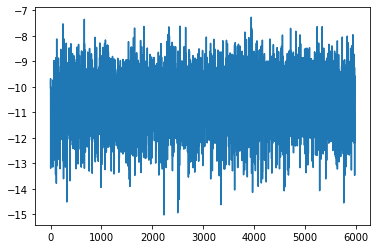

In [3]:
plt.plot(reward_records)

In [4]:
import misc

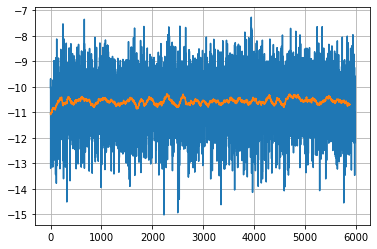

In [8]:
plt.plot(reward_records)
plt.plot(misc.smooth(reward_records,100))
plt.grid()


ValueError: setting an array element with a sequence.

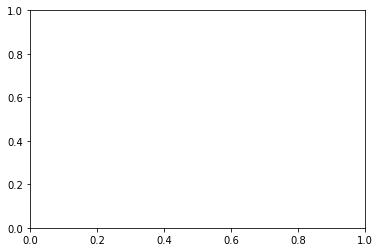

In [9]:
plt.plot(buffer.critic_loss_buffer)

In [38]:
buffer.critic_loss_buffer

[<tf.Tensor 'Mean:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean:0' shape=() dtype=float32>]

In [11]:
buffer.actor_loss_buffer

[<tf.Tensor 'Neg:0' shape=() dtype=float32>,
 <tf.Tensor 'Neg:0' shape=() dtype=float32>]

In [20]:
buffer.state_buffer[5]

array([-1.22213177e-03,  3.65813896e-02,  3.05984747e-02, ...,
       -1.49960070e+01, -1.53535566e+01,  4.70000000e+01])

In [21]:
buffer.next_state_buffer[5]

array([ 9.43847001e-03,  1.98416784e-02,  3.56539562e-02, ...,
       -1.53535566e+01, -1.58012362e+01,  4.80000000e+01])

In [22]:
buffer.state_buffer[5+32]

array([6.19922206e-03, 6.71781972e-03, 1.01871835e-02, ...,
       4.86585522e+00, 4.50606394e+00, 2.10000000e+01])

In [16]:
buffer.state_buffer[18].shape

(50221,)

In [17]:
deterministic_action

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
       [-0.0989508 , -0.34980485],
      

In [24]:
buffer.buffer_counter

813016

In [26]:
len(reward_records)*34 #there are 50-16=34 timesteps when buffer is updated

203252

In [27]:
len(reward_records)*34*4

813008

In [28]:
ep

5978

In [29]:
ep*config.batch_size*(env.config.t_max-1 - env.config.t_ignore)

6312768

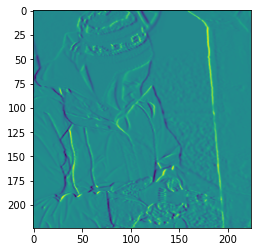

In [36]:
plt.imshow(env.unflatten_observation(buffer.next_state_buffer[5:5+config.batch_size])[0][1])

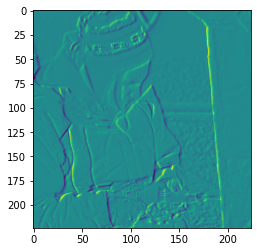

In [37]:
plt.imshow(env.unflatten_observation(buffer.state_buffer[5:5+config.batch_size])[0][1])

In [32]:
buffer.next_state_buffer[5].shape

(50221,)